# Week HW 18

Last Audit: HW18

# Import


In [1]:
import gurobipy as gp
from gurobipy import GRB
import gurobipy_pandas as gppd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import min_, max_
from scipy.stats import multivariate_normal, norm
import pickle
import os
import glob
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import itertools
import math

params = {
    "WLSACCESSID": "73a6e3bf-2a9d-41e8-85eb-dd9b9eda802b",
    "WLSSECRET": "c394298a-96ea-4c8c-9d5e-ef2bd5032427",
    "LICENSEID": 2563044,
}

env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2563044
Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw


# Settings


In [2]:
#####################

salvage_value = 0
cost = 800
price = 1000
holding_cost = 20

model_prefix = f"low_with_holding_cost_{holding_cost}"

#####################

data_size = 200
train_size = 0.5
testing_size = 0.5
k_fold = 2


T = 10
service_level = 0.95  # 服務水準
M = 5000000

ASSIGNED_FS = np.arange(0.1, 1.0, 0.1)
ASSIGNED_TS = list(range(2, T))  # 2 到 T-1

np.random.seed(0)

# Gurobi Model Constants
THREADS = 12
TIME_LIMIT = 400
MIPGAP = 0.3
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))

# Utils


## Models' Parameters

In [3]:
def save_model_parameters(
    name: str,
    alpha_values=None,
    beta_values=None,
    f_values=None,
    tau_values=None,
    data_size=data_size,
    current_timestamp=CURRENT_TIMESTAMP,
):
    os.makedirs("models", exist_ok=True)

    params = {}
    if alpha_values is not None:
        params["alpha"] = alpha_values
    if beta_values is not None:
        params["beta"] = beta_values
    if f_values is not None:
        params["f_values"] = f_values
    if tau_values is not None:
        params["tau_values"] = tau_values

    # 如果有參數才進行保存
    if params:
        with open(f"models/{name}_{data_size}_{current_timestamp}.pkl", "wb") as f:
            pickle.dump(params, f)
        print(
            f"Model parameters saved as models/{name}_{data_size}_{current_timestamp}.pkl"
        )
    else:
        print("No parameters provided to save.")

In [4]:
def delete_model_parameters(name: str, data_size: int):
    # 構建檔案的路徑
    file_path = f"models/{name}_{data_size}_{CURRENT_TIMESTAMP}.pkl"

    # 檢查檔案是否存在
    if os.path.exists(file_path):
        os.remove(file_path)
        print(f"Model parameters file '{file_path}' has been deleted.")
    else:
        print(f"File '{file_path}' does not exist.")

In [5]:
def show_models(model_prefix):
    file_paths = sorted(glob.glob(f"models/{model_prefix}_*.pkl"))

    # 逐一讀取並打印每個檔案的內容
    for file_path in file_paths:
        with open(file_path, "rb") as f:
            params = pickle.load(f)
            print(f"Contents of {file_path}:")
            print(params)
            print()  # 空行分隔每個檔案的內容

## Visualization 

In [6]:
def plot_strategies_profits_scatter(save_type, dfs):

    if len(dfs) <= 1:
        print("No dataframes to plot.")
        return None

    # 生成所有兩兩配對
    pairs = list(itertools.combinations(range(len(dfs)), 2))
    num_pairs = len(pairs)

    # 計算網格大小
    grid_size = math.ceil(math.sqrt(num_pairs))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    fig.suptitle("Scatter Plots of Profits (Matrix View)")

    # 繪製每個配對的散佈圖
    for idx, (i, j) in enumerate(pairs):
        row, col = divmod(idx, grid_size)

        if (dfs[i] is None or len(dfs[i]) == 0) or (dfs[j] is None or len(dfs[j]) == 0):
            continue

        profits_i = dfs[i]["profits"]
        profits_j = dfs[j]["profits"]

        if len(profits_i) != len(profits_j):
            continue

        ax = axes[row, col]
        ax.scatter(profits_i, profits_j, alpha=0.6, label=f"Profits {i} vs Profits {j}")
        ax.set_xlabel(f"Profits {i}")
        ax.set_ylabel(f"Profits {j}")

        # 繪製 45 度虛線
        max_val = max(profits_i.max(), profits_j.max())
        min_val = min(profits_i.min(), profits_j.min())
        ax.plot([min_val, max_val], [min_val, max_val], "k--", lw=1)

        ax.legend()
        ax.set_title(f"Profits {i} vs Profits {j}")

    # 隱藏未使用的子圖軸
    for idx in range(num_pairs, grid_size * grid_size):
        row, col = divmod(idx, grid_size)
        fig.delaxes(axes[row, col])

    plt.tight_layout(rect=[0, 0, 1, 0.95])

    name = "plot_strategies_profits_scatter"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [7]:
def plot_relative_profit_deviation(save_type, baseline_profit, max_profits):
    """
    繪製多個策略相對於基準的平均利潤偏差。

    :param baseline_profit: 基準利潤值
    :param max_profits: 各策略的最大利潤列表，包含 None 值或 -1 表示無效數據
    """
    print(f"Baseline is: {baseline_profit}")
    for i, profit in enumerate(max_profits):
        print(f"S{i+1}'s profit: {profit}")

    # 計算相對值
    ratios = {}
    for idx, max_profit in enumerate(max_profits, start=1):
        if max_profit is not None and max_profit != -1:
            ratio = max_profit / baseline_profit
            ratios[f"S{idx}"] = ratio - 1  # 相對偏差

    # 設置 y 軸範圍
    if ratios:
        y_min = min(ratios.values()) - 0.1
        y_max = max(ratios.values()) + 0.1
    else:
        y_min, y_max = -0.1, 0.1

    # 創建圖表顯示結果
    plt.figure(figsize=(12, 8))

    if ratios:
        bars = plt.bar(
            ratios.keys(), ratios.values(), color=plt.cm.tab10(range(len(ratios)))
        )

        # 在每個柱狀圖上標出數值
        for bar in bars:
            yval = bar.get_height()
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                yval,
                f"{yval:.4f}",
                ha="center",
                va="bottom",
            )

    # 添加基準線，表示基準值（No Opt）
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # 設置圖表標題和軸標籤
    plt.title("Relative Avg Profit Deviation from Baseline (1)")
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline (1)")
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_deviation"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [8]:
def plot_relative_profit_comparison(
    save_type,
    train_baseline_profit,
    test_baseline_profit,
    test_max_profits,
    train_max_profits,
):

    # Calculate relative deviations from baseline for test and train data
    test_ratios, train_ratios = {}, {}
    for idx, (test_profit, train_profit) in enumerate(
        zip(test_max_profits, train_max_profits), start=1
    ):
        if test_profit is not None and test_profit != -1:
            test_ratio = test_profit / test_baseline_profit - 1  # Relative deviation
            test_ratios[f"S{idx}"] = test_ratio
        if train_profit is not None and train_profit != -1:
            train_ratio = train_profit / train_baseline_profit - 1  # Relative deviation
            train_ratios[f"S{idx}"] = train_ratio

    # Define the range of the y-axis
    y_min = (
        min(min(test_ratios.values(), default=0), min(train_ratios.values(), default=0))
        - 0.1
    )
    y_max = (
        max(max(test_ratios.values(), default=0), max(train_ratios.values(), default=0))
        + 0.1
    )

    # Create bar plot for relative profit deviation comparison
    plt.figure(figsize=(14, 8))
    bar_width = 0.35
    indices = np.arange(len(train_ratios))

    # Plot bars for train and test ratios, with train on the left for each pair
    train_bars = plt.bar(
        indices - bar_width / 2,
        train_ratios.values(),
        bar_width,
        label="Train Data",
        color="salmon",
    )
    test_bars = plt.bar(
        indices + bar_width / 2,
        test_ratios.values(),
        bar_width,
        label="Test Data",
        color="skyblue",
    )

    # Add baseline line
    plt.axhline(y=0, color="gray", linestyle="--", label="Baseline (No Opt)")

    # Add labels for each bar
    for bar in train_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )
    for bar in test_bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            yval,
            f"{yval:.2f}",
            ha="center",
            va="bottom",
        )

    # Set plot labels and title
    plt.xlabel("Strategies")
    plt.ylabel("Deviation from Baseline")
    plt.title("Relative Profit Deviation Comparison between Train and Test Data")
    plt.xticks(indices, train_ratios.keys())
    plt.ylim(y_min, y_max)
    plt.legend()

    name = "plot_relative_profit_comparison"

    os.makedirs("plots", exist_ok=True)
    save_path = f"plots/{name}_{save_type}_{data_size}_{CURRENT_TIMESTAMP}.png"

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

In [9]:
def plot_Q0_Q1_distribution(save_type, stimulation_results_dfs):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is None or len(df) == 0:
            continue

        df["Q0"] = pd.to_numeric(df["Q0"], errors="coerce")
        df["Q1"] = pd.to_numeric(df["Q1"], errors="coerce")
        df.dropna(subset=["Q0", "Q1"], inplace=True)

        plt.figure(figsize=(10, 6))
        plt.hist(df["Q0"], bins=20, alpha=0.6, label="Q0", edgecolor="black")
        plt.hist(df["Q1"], bins=20, alpha=0.6, label="Q1", edgecolor="black")
        plt.title(f"Histogram of Q0 and Q1 for stimulation_results_df_{idx}")
        plt.xlabel("Value")
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)

        name = "plot_Q0_Q1_distribution"

        os.makedirs("plots", exist_ok=True)
        save_path = (
            f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
        )

        plt.savefig(save_path, format="png", bbox_inches="tight")
        print(f"Plot saved as {save_path}")

        plt.show()

In [10]:
import seaborn as sns


def plot_profits_deviation_box_plot(
    save_type, stimulation_results_dfs, baseline_avg_profits
):

    for idx, df in enumerate(stimulation_results_dfs, start=1):
        if df is not None and "profits" in df.columns:
            df["profits"] = pd.to_numeric(df["profits"], errors="coerce")
            df.dropna(subset=["profits"], inplace=True)

            # Calculate deviation
            df["Deviation"] = df["profits"] - baseline_avg_profits

            # Plot deviation as a boxplot
            plt.figure(figsize=(8, 6))
            sns.boxplot(y=df["Deviation"])
            plt.axhline(0, color="red", linestyle="--", label="Baseline")
            plt.title(
                f"Boxplot of Deviation of Profits from Baseline for stimulation_results_df_{idx}"
            )
            plt.ylabel("Deviation")
            plt.legend()
            plt.grid(True, axis="y")

            name = "plot_profits_deviation_box_plot"

            os.makedirs("plots", exist_ok=True)
            save_path = (
                f"plots/{name}_{save_type}_{data_size}_S{idx}_{CURRENT_TIMESTAMP}.png"
            )

            plt.savefig(save_path, format="png", bbox_inches="tight")
            print(f"Plot saved as {save_path}")

            plt.show()
        else:
            print(f"Skipping stimulation_results_df_{idx}: Missing 'profits' column.")

## Others

In [11]:
# Function to replace negative values with 0
def replace_negative_with_zero(df):
    return df.applymap(lambda x: max(x, 0))

In [12]:
def check_values(
    Q1_vars,
    Q_hat_adjusteds,
    Q0_vars,
    Sold_0s,
    total_demand_up_to_k_minus_1_vars,
    Sold_1s,
    total_demand_from_k_to_T_vars,
    Q1_plus_lefts,
    Left_0s,
    Lost_0s,
    Left_1s,
    Lost_1s,
):

    # 用於存儲每個條件的統計結果
    results = {
        "Condition": [],
        "Average_Error_Percentage": [],
        "Max_Error_Percentage": [],
        "Min_Error_Percentage": [],
        "Max_Error": [],
        "Min_Error": [],
    }

    # 定義存儲每個條件下的誤差和誤差百分比
    conditions_errors = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 存儲每個條件下的誤差百分比
    conditions_error_percentage = {
        "Q1_vars": [],
        "Sold_0s": [],
        "Sold_1s": [],
        "Left_0s": [],
        "Left_1s": [],
        "Lost_0s": [],
        "Lost_1s": [],
    }

    # 遍歷每一個變量集合
    for i in range(len(Q1_vars)):
        # 提取變量的值
        Q1 = Q1_vars[i].X
        Q_hat_adjusted = Q_hat_adjusteds[i].X
        Q0 = Q0_vars[i].X
        Sold_0 = Sold_0s[i].X
        total_demand_up_to_k_minus_1 = total_demand_up_to_k_minus_1_vars[i].X
        Sold_1 = Sold_1s[i].X
        total_demand_from_k_to_T = total_demand_from_k_to_T_vars[i].X
        Q1_plus_left = Q1_plus_lefts[i].X
        Left_0 = Left_0s[i].X
        Lost_0 = Lost_0s[i].X
        Left_1 = Left_1s[i].X
        Lost_1 = Lost_1s[i].X

        # 計算理論值
        theoretical_sold_0 = min(total_demand_up_to_k_minus_1, Q0)
        theoretical_left_0 = max(Q0 - theoretical_sold_0, 0)
        theoretical_Q1_plus_left = Q1 + theoretical_left_0  # Q1_plus_left 的理論值
        theoretical_sold_1 = min(total_demand_from_k_to_T, theoretical_Q1_plus_left)
        theoretical_left_1 = max(theoretical_Q1_plus_left - theoretical_sold_1, 0)
        theoretical_lost_0 = max(total_demand_up_to_k_minus_1 - Q0, 0)
        theoretical_lost_1 = max(total_demand_from_k_to_T - theoretical_Q1_plus_left, 0)

        # 檢查條件 2：Sold_0 一定等於理論值
        if not (Sold_0 == theoretical_sold_0):
            error = abs(Sold_0 - theoretical_sold_0)
            conditions_errors["Sold_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_0s"].append(
                (error / theoretical_sold_0) * 100 if theoretical_sold_0 != 0 else 0
            )

        # 檢查條件 3：Sold_1 一定等於理論值
        if not (Sold_1 == theoretical_sold_1):
            error = abs(Sold_1 - theoretical_sold_1)
            conditions_errors["Sold_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Sold_1s"].append(
                (error / theoretical_sold_1) * 100 if theoretical_sold_1 != 0 else 0
            )

        # 檢查條件 4：Left_0 一定等於理論值
        if not (Left_0 == theoretical_left_0):
            error = abs(Left_0 - theoretical_left_0)
            conditions_errors["Left_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_0s"].append(
                (error / theoretical_left_0) * 100 if theoretical_left_0 != 0 else 0
            )

        # 檢查條件 5：Left_1 一定等於理論值
        if not (Left_1 == theoretical_left_1):
            error = abs(Left_1 - theoretical_left_1)
            conditions_errors["Left_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Left_1s"].append(
                (error / theoretical_left_1) * 100 if theoretical_left_1 != 0 else 0
            )

        # 檢查條件 6：Lost_0 一定等於理論值
        if not (Lost_0 == theoretical_lost_0):
            error = abs(Lost_0 - theoretical_lost_0)
            conditions_errors["Lost_0s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_0s"].append(
                (error / theoretical_lost_0) * 100 if theoretical_lost_0 != 0 else 0
            )

        # 檢查條件 7：Lost_1 一定等於理論值
        if not (Lost_1 == theoretical_lost_1):
            error = abs(Lost_1 - theoretical_lost_1)
            conditions_errors["Lost_1s"].append(error)
            # 計算誤差百分比
            conditions_error_percentage["Lost_1s"].append(
                (error / theoretical_lost_1) * 100 if theoretical_lost_1 != 0 else 0
            )

    # 計算每個條件的統計結果
    for condition, errors in conditions_errors.items():
        error_percentages = conditions_error_percentage[condition]
        if errors:
            # 統計數據，並將所有數值四捨五入至小數點后三位
            avg_error_percentage = (
                round(sum(error_percentages) / len(error_percentages), 3)
                if error_percentages
                else 0.0
            )
            max_error_percentage = (
                round(max(error_percentages), 3) if error_percentages else 0.0
            )
            min_error_percentage = (
                round(min(error_percentages), 3) if error_percentages else 0.0
            )
            max_error = round(max(errors), 3) if errors else 0.0
            min_error = round(min(errors), 3) if errors else 0.0

            # 存儲結果
            results["Condition"].append(condition)
            results["Average_Error_Percentage"].append(avg_error_percentage)
            results["Max_Error_Percentage"].append(max_error_percentage)
            results["Min_Error_Percentage"].append(min_error_percentage)
            results["Max_Error"].append(max_error)
            results["Min_Error"].append(min_error)

    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    return results_df

In [13]:
# Calculate service level
def calculate_service_level(*, salvage_value, cost, price):

    cu = price - cost
    co = cost - salvage_value
    service_lv = cu / (co + cu)

    return service_lv

In [14]:
def make_s3_related_strtegies_result(
    *,
    all_Rs,
    losses,
    lefts,
    profits,
    operation_profits,
    alpha_values,
    beta_values,
    F_vars,
    Q0_vars,
    Q1_vars,
    f_values,
    tau_values,
    holding_costs_0s,
    holding_costs_1s,
    all_left0s,
    all_left1s,
    all_lost0s,
    all_lost1s,
):

    results_dict = {
        "average_profits": [sum(profits) / len(profits) if profits else 0],
        "average_losses": [sum(losses) / len(losses) if losses else 0],
        "average_lefts": [sum(lefts) / len(lefts) if lefts else 0],
        "average_operation_profits": [
            sum(operation_profits) / len(operation_profits) if operation_profits else 0
        ],
        "alpha_values": [alpha_values],
        "beta_values": [beta_values],
        "tau_values": [tau_values],
    }
    stimulations_result = {
        "R(T)": all_Rs,
        "R": [x - 2 for x in all_Rs],
        "F": F_vars,
        "f_values": f_values,
        "profits": profits,
        "losses": losses,
        "lefts": lefts,
        "operation_profits": operation_profits,
        "Q0": Q0_vars,
        "Q1": Q1_vars,
        "hc0": holding_costs_0s,
        "hc1": holding_costs_1s,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(stimulations_result)

# Generate Data


## Data1: Training data for LR


### Making full data


In [15]:
np.random.seed(0)

full_df = pd.DataFrame(
    {
        "X1": np.random.uniform(100, 150, data_size),
        "X2": np.random.uniform(-30, -10, data_size),
    }
)

full_df

X1         X2
0    127.440675 -23.764082
1    135.759468 -16.073130
2    130.138169 -22.444963
3    127.244159 -26.407926
4    121.182740 -29.506425
..          ...        ...
195  124.522940 -10.820346
196  111.370731 -22.892623
197  112.717824 -22.865862
198  102.901458 -29.673430
199  121.720831 -26.295353

[200 rows x 2 columns]

In [16]:
features_num = full_df.shape[1]
features_num

2

### Split training and testing data


In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


def train_data_split_and_normalize_k_fold(data, train_size=0.8, k_fold=2):
    folds = []
    scalers = []

    for i in range(k_fold):
        # Randomly split the data into train and test sets
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)

        # Normalize the train and test data
        scaler = StandardScaler()
        train_data_normalized = scaler.fit_transform(train_data)
        test_data_normalized = scaler.transform(test_data)

        # Convert normalized data back to DataFrame
        train_data_normalized = pd.DataFrame(
            train_data_normalized, columns=data.columns
        )
        test_data_normalized = pd.DataFrame(test_data_normalized, columns=data.columns)

        # Append the fold and scaler
        folds.append((train_data_normalized, test_data_normalized))
        scalers.append(scaler)

    return folds, scalers


training_data_folds, scalers = train_data_split_and_normalize_k_fold(
    full_df, train_size, k_fold=k_fold
)

# Print each fold's train and test sizes and normalized data
for i, (train, test) in enumerate(training_data_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print("Train (normalized):")
    print(train.head())
    print("Test (normalized):")
    print(test.head())
    print()

Fold 1:
Train size: (100, 2), Test size: (100, 2)
Train (normalized):
         X1        X2
0 -0.331322 -0.428261
1 -1.020232 -0.311865
2  0.237756 -0.565839
3  0.163108 -0.728488
4 -0.742481  0.012144
Test (normalized):
         X1        X2
0  0.963742  0.297962
1  0.066139  0.711127
2  0.244931 -1.687555
3  1.141026  1.725609
4  1.487127  1.674558

Fold 2:
Train size: (100, 2), Test size: (100, 2)
Train (normalized):
         X1        X2
0 -1.649706  1.566766
1  1.047402  1.309573
2  0.579833 -1.158598
3 -1.212101 -0.174007
4  0.350403 -0.350630
Test (normalized):
         X1        X2
0 -0.133863  1.609093
1 -0.512902  1.280069
2 -1.722098 -0.921862
3  0.820394 -0.500269
4  1.526709  1.135523



## Data2: demand_df


### mu of each time(t)


In [18]:
# 設定 b0, b1, b2
b0 = 0.3
b1 = 0.17
b2 = 0.2


def cal_mu_matrix_with_random_noise(data_size, T, training_df, sigma_t):
    np.random.seed(0)

    # 初始化 mu_matrix
    mu_matrix = np.zeros((data_size, T))

    # 生成每個 t 的隨機數
    random_noises = np.random.normal(0, sigma_t, T)

    # 計算 mu_matrix
    for t in range(1, T + 1):
        mu_matrix[:, t - 1] = (
            b1 * training_df["X1"] + b2 * training_df["X2"] + b0 * random_noises[t - 1]
        )

    return mu_matrix

In [19]:
# mu_matrix = cal_mu_matrix(data_size, T, full_df)
mu_matrix = cal_mu_matrix_with_random_noise(data_size, T, full_df, sigma_t=1)

print(f"mu_matrix shape: {mu_matrix.shape}")
print(f"mu_matrix[0]: \n{mu_matrix[0]}")

mu_matrix shape: (200, 10)
mu_matrix[0]: 
[17.44131402 17.03214547 17.20571971 17.58436627 17.47236571 16.61891495
 17.19712484 16.86669115 16.88113266 17.03527786]


### sigma matrix


In [20]:
X = full_df.values  # 轉換為 NumPy 矩陣
feature_num = X.shape[1]  # 特徵數量

# 生成輸入特徵矩陣 X (shape: feature_num * data_size)
np.random.seed(0)
X = np.random.rand(feature_num, data_size)

# 隨機生成常數項 c 和係數向量 coefficients
c = np.random.uniform(0, 1)
coefficients = np.random.uniform(-1, 1, (feature_num, T))  # shape: (feature_num, T)
print(f"coefficients.shape: {coefficients.shape}")
print(f"coefficients: {coefficients}")

coefficients.shape: (2, 10)
coefficients: [[ 0.85858283 -0.80077014  0.89060307  0.73897706 -0.09167521 -0.34659824
  -0.53451174  0.22892941 -0.93385082 -0.96878787]
 [-0.14240856 -0.86385185 -0.49611802 -0.55767817 -0.49361761 -0.73788954
  -0.97592755 -0.76903141  0.23696052  0.94851243]]


In [21]:
# 進行矩陣運算
# X.T 的形狀為 (data_size, feature_num)，X.T @ coefficients 的形狀為 (data_size, T)
linear_combination = c + X.T @ coefficients

# 使用 sigmoid 函數將值映射到 [0, 1] 之間
sigma_matrix = 1 / (1 + np.exp(-linear_combination))  # shape: (data_size, T)

# 再將值縮放到 [2, 10] 的範圍
sigma_matrix = 2 + sigma_matrix * 8  # shape: (data_size, T)

# 輸出 sigma_matrix 的形狀和內容
sigma_matrix_shape = sigma_matrix.shape
sigma_matrix_content = sigma_matrix

sigma_matrix_shape, sigma_matrix_content

((200, 10),
 array([[7.5675548 , 5.38968456, 7.40782018, ..., 6.57032385, 5.92527445,
         6.32988484],
        [7.7140454 , 4.52667791, 7.33261081, ..., 6.05895047, 5.79694517,
         6.72951268],
        [7.62961171, 5.19563889, 7.43460245, ..., 6.49494405, 5.85582389,
         6.35032407],
        ...,
        [7.10797759, 5.77909802, 6.88667618, ..., 6.36928619, 6.49397352,
         6.96684772],
        [6.88274932, 6.67485735, 6.87529281, ..., 6.79331962, 6.69476044,
         6.71334853],
        [7.42970389, 5.78695849, 7.33885581, ..., 6.7089548 , 6.07893361,
         6.31156183]]))

### corr matrix


In [22]:
# Generate correlation matrix
np.random.seed(0)

A = np.random.uniform(-1, 1, (T, T))
corr_matrix = np.dot(A, A.T)

D = np.diag(1 / np.sqrt(np.diag(corr_matrix)))
corr_matrix = D @ corr_matrix @ D

print(f"corr_matrix shape: {corr_matrix.shape}")
print(f"corr_matrix: \n{corr_matrix}")

corr_matrix shape: (10, 10)
corr_matrix: 
[[ 1.          0.35424279  0.5557836   0.58741064 -0.38777369 -0.16148427
  -0.0990728  -0.27594366 -0.48889127 -0.02092469]
 [ 0.35424279  1.          0.64567134  0.34424882 -0.53396229 -0.11871438
  -0.3666009   0.07223015  0.10995817 -0.04912633]
 [ 0.5557836   0.64567134  1.          0.259728   -0.42849166 -0.23652044
  -0.55154321  0.01056255 -0.4142461  -0.12870872]
 [ 0.58741064  0.34424882  0.259728    1.         -0.43371556 -0.07896157
   0.16623268 -0.63102156  0.08913915  0.24417687]
 [-0.38777369 -0.53396229 -0.42849166 -0.43371556  1.          0.37139904
   0.30031034  0.29401969 -0.15371929 -0.10854857]
 [-0.16148427 -0.11871438 -0.23652044 -0.07896157  0.37139904  1.
   0.65829169  0.52050763 -0.34173775  0.14741869]
 [-0.0990728  -0.3666009  -0.55154321  0.16623268  0.30031034  0.65829169
   1.          0.03894138 -0.00977194  0.48587032]
 [-0.27594366  0.07223015  0.01056255 -0.63102156  0.29401969  0.52050763
   0.03894138  1.

### cov matrix


In [23]:
# Generate covariance matrices
cov_matrices = []
for i in range(data_size):
    cov_matrix = np.zeros((T, T))  # 每一個模擬都會有 T*T 的共變異矩陣
    for j in range(T):
        for k in range(T):
            cov_matrix[j, k] = (
                corr_matrix[j, k] * sigma_matrix[i, j] * sigma_matrix[i, k]
            )
    cov_matrices.append(cov_matrix)

print(f"cov_matrices shape: {np.array(cov_matrices).shape}")
print(f"cov_matrices: \n{cov_matrices[0]}")

cov_matrices shape: (200, 10, 10)
cov_matrices: 
[[ 57.26788558  14.4484062   31.15672017  32.11810152 -18.75968624
   -7.28573889  -4.20491147 -13.72027361 -21.92180598  -1.00232951]
 [ 14.4484062   29.0486996   25.77895387  13.40566275 -18.39778696
   -3.81464796 -11.08163172   2.55781206   3.51155362  -1.67599793]
 [ 31.15672017  25.77895387  54.87579975  13.90150059 -20.29198169
  -10.44592495 -22.91483883   0.51409789 -18.1826563   -6.03523534]
 [ 32.11810152  13.40566275  13.90150059  52.20414181 -20.03314494
   -3.40138719   6.73621143 -29.95597453   3.81618517  11.16741901]
 [-18.75968624 -18.39778696 -20.29198169 -20.03314494  40.86799268
   14.15533764  10.76734865  12.34965546  -5.82275459  -4.39249794]
 [ -7.28573889  -3.81464796 -10.44592495  -3.40138719  14.15533764
   35.54476107  22.01167087  20.38926978 -12.07227784   5.5633471 ]
 [ -4.20491147 -11.08163172 -22.91483883   6.73621143  10.76734865
   22.01167087  31.45528841   1.43497693  -0.32474038  17.24896381]
 [-13.

In [24]:
def is_positive_definite(matrix):
    return np.all(np.linalg.eigvals(matrix) > 0)


positive_definite_check = all(is_positive_definite(cov) for cov in cov_matrices)
print("All covariance matrices are positive definite:", positive_definite_check)

All covariance matrices are positive definite: True


### MVN stimulation for demand_df


In [25]:
def simulate_demand_data(data_size, T, cov_matrices, mu_matrix):
    np.random.seed(0)

    simulated_data = np.array(
        [
            np.random.multivariate_normal(mu_matrix[i], cov_matrices[i])
            for i in range(data_size)
        ]
    )

    demand_df = pd.DataFrame(
        simulated_data, columns=[f"demand_t{t}" for t in range(1, T + 1)]
    )
    return demand_df


demand_df = simulate_demand_data(data_size, T, cov_matrices, mu_matrix)
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0    14.994492  -1.572204   6.276855   6.287719  28.739691  20.915456   
1    20.071280  16.251607  26.715321  14.674194  23.781205  23.148586   
2    41.196355  21.854076  35.010276  23.691949   3.473905  12.013088   
3    13.040559  24.446241  17.697447  10.495227  13.839201  12.064073   
4    16.528012  10.191629  24.149544  11.654052  11.746460   0.473485   
..         ...        ...        ...        ...        ...        ...   
195  17.253189  25.237284  23.766712  26.179814   9.628401   9.767283   
196  21.956541   4.294186  14.525894  10.742570  15.250108  12.318408   
197  10.158613   9.475920   3.918365  13.067729  20.527375  18.688244   
198  15.759690  15.990070  14.545696  10.870981   0.933917   8.237161   
199  14.661914  11.928858   5.071973  15.868069  23.422667  24.587557   

     demand_t7  demand_t8  demand_t9  demand_t10  
0    24.111980  18.040681   5.732286   15.006440  
1    19.693185  24.397170  10.082824   17.010596  
2    12.572294  17.180781   9.533029   24.148866  
3    13.949793  23.442417  25.253318   21.636339  
4    -0.442483   7.689177   8.079971    1.624042  
..         ...        ...        ...         ...  
195  10.475803  13.149192  27.449960   15.942872  
196  10.589735  12.193294   0.187484    3.109506  
197  20.156489  15.270096  20.163896   16.825194  
198   8.016725  12.579079  12.296184   14.537757  
199  27.158232  22.710644  17.699906   20.612525  

[200 rows x 10 columns]

### Replace negative values to 0


In [26]:
demand_df = replace_negative_with_zero(demand_df)
demand_df

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/2799096767.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return df.applymap(lambda x: max(x, 0))


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0    14.994492   0.000000   6.276855   6.287719  28.739691  20.915456   
1    20.071280  16.251607  26.715321  14.674194  23.781205  23.148586   
2    41.196355  21.854076  35.010276  23.691949   3.473905  12.013088   
3    13.040559  24.446241  17.697447  10.495227  13.839201  12.064073   
4    16.528012  10.191629  24.149544  11.654052  11.746460   0.473485   
..         ...        ...        ...        ...        ...        ...   
195  17.253189  25.237284  23.766712  26.179814   9.628401   9.767283   
196  21.956541   4.294186  14.525894  10.742570  15.250108  12.318408   
197  10.158613   9.475920   3.918365  13.067729  20.527375  18.688244   
198  15.759690  15.990070  14.545696  10.870981   0.933917   8.237161   
199  14.661914  11.928858   5.071973  15.868069  23.422667  24.587557   

     demand_t7  demand_t8  demand_t9  demand_t10  
0    24.111980  18.040681   5.732286   15.006440  
1    19.693185  24.397170  10.082824   17.010596  
2    12.572294  17.180781   9.533029   24.148866  
3    13.949793  23.442417  25.253318   21.636339  
4     0.000000   7.689177   8.079971    1.624042  
..         ...        ...        ...         ...  
195  10.475803  13.149192  27.449960   15.942872  
196  10.589735  12.193294   0.187484    3.109506  
197  20.156489  15.270096  20.163896   16.825194  
198   8.016725  12.579079  12.296184   14.537757  
199  27.158232  22.710644  17.699906   20.612525  

[200 rows x 10 columns]

### Validate the mean and std of total demand


檢查生成的需求數據是否符合上述總需求的特性。例如，從生成的需求 demand_df 中計算總需求
𝐷
D，然後檢查其均值和標準差是否接近理論值（即均值為所有
𝜇
𝑡
μ
t
​
的和，標準差根據共變異數矩陣計算）。


In [27]:
def check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix):
    results = []
    for i in range(len(demand_df)):

        demand_i = demand_df.iloc[i, :]

        # theoretical mean
        theoretical_mean = mu_matrix[i].sum()

        # theoretical std
        variance_sum = np.sum(np.diag(cov_matrices[i]))
        covariance_sum = np.sum(cov_matrices[i]) - variance_sum
        theoretical_variance = variance_sum + covariance_sum
        theoretical_std = np.sqrt(theoretical_variance)

        # empirical mean and std
        empirical_mean = demand_i.sum()
        empirical_std = demand_i.std(ddof=0)  # 指定除以 n 而非 n-1
        std_relative_error = abs(theoretical_std - empirical_std) / empirical_std * 100

        # save the results
        results.append(
            {
                "theoretical_mean": theoretical_mean,
                "empirical_mean": empirical_mean,
                "theoretical_std": theoretical_std,
                "empirical_std": empirical_std,
                "std_relative_error": std_relative_error,
            }
        )

    return pd.DataFrame(results)


results_df = check_theoretical_vs_empirical(demand_df, cov_matrices, mu_matrix)
results_df

theoretical_mean  empirical_mean  theoretical_std  empirical_std  \
0          171.335053      140.105600        21.350277       8.770082   
1          200.858905      195.825966        20.393002       4.865185   
2          178.559030      200.674620        21.161056      11.038154   
3          165.713287      175.864615        21.678572       5.340957   
4          149.211877       92.136373        22.148793       7.158220   
..                ...             ...              ...            ...   
195        192.262377      178.850511        19.915332       6.815474   
196        145.759067      105.167725        21.469501       6.129773   
197        148.102646      148.251921        21.444306       5.300941   
198        117.799688      113.767260        22.468855       4.396287   
199        156.548776      183.722345        21.736581       6.356689   

     std_relative_error  
0            143.444440  
1            319.161885  
2             91.708286  
3            305.893019  
4            209.417593  
..                  ...  
195          192.207570  
196          250.249540  
197          304.537760  
198          411.087099  
199          241.948167  

[200 rows x 5 columns]

### Validate normal distribution


In [28]:
demand_df

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0    14.994492   0.000000   6.276855   6.287719  28.739691  20.915456   
1    20.071280  16.251607  26.715321  14.674194  23.781205  23.148586   
2    41.196355  21.854076  35.010276  23.691949   3.473905  12.013088   
3    13.040559  24.446241  17.697447  10.495227  13.839201  12.064073   
4    16.528012  10.191629  24.149544  11.654052  11.746460   0.473485   
..         ...        ...        ...        ...        ...        ...   
195  17.253189  25.237284  23.766712  26.179814   9.628401   9.767283   
196  21.956541   4.294186  14.525894  10.742570  15.250108  12.318408   
197  10.158613   9.475920   3.918365  13.067729  20.527375  18.688244   
198  15.759690  15.990070  14.545696  10.870981   0.933917   8.237161   
199  14.661914  11.928858   5.071973  15.868069  23.422667  24.587557   

     demand_t7  demand_t8  demand_t9  demand_t10  
0    24.111980  18.040681   5.732286   15.006440  
1    19.693185  24.397170  10.082824   17.010596  
2    12.572294  17.180781   9.533029   24.148866  
3    13.949793  23.442417  25.253318   21.636339  
4     0.000000   7.689177   8.079971    1.624042  
..         ...        ...        ...         ...  
195  10.475803  13.149192  27.449960   15.942872  
196  10.589735  12.193294   0.187484    3.109506  
197  20.156489  15.270096  20.163896   16.825194  
198   8.016725  12.579079  12.296184   14.537757  
199  27.158232  22.710644  17.699906   20.612525  

[200 rows x 10 columns]

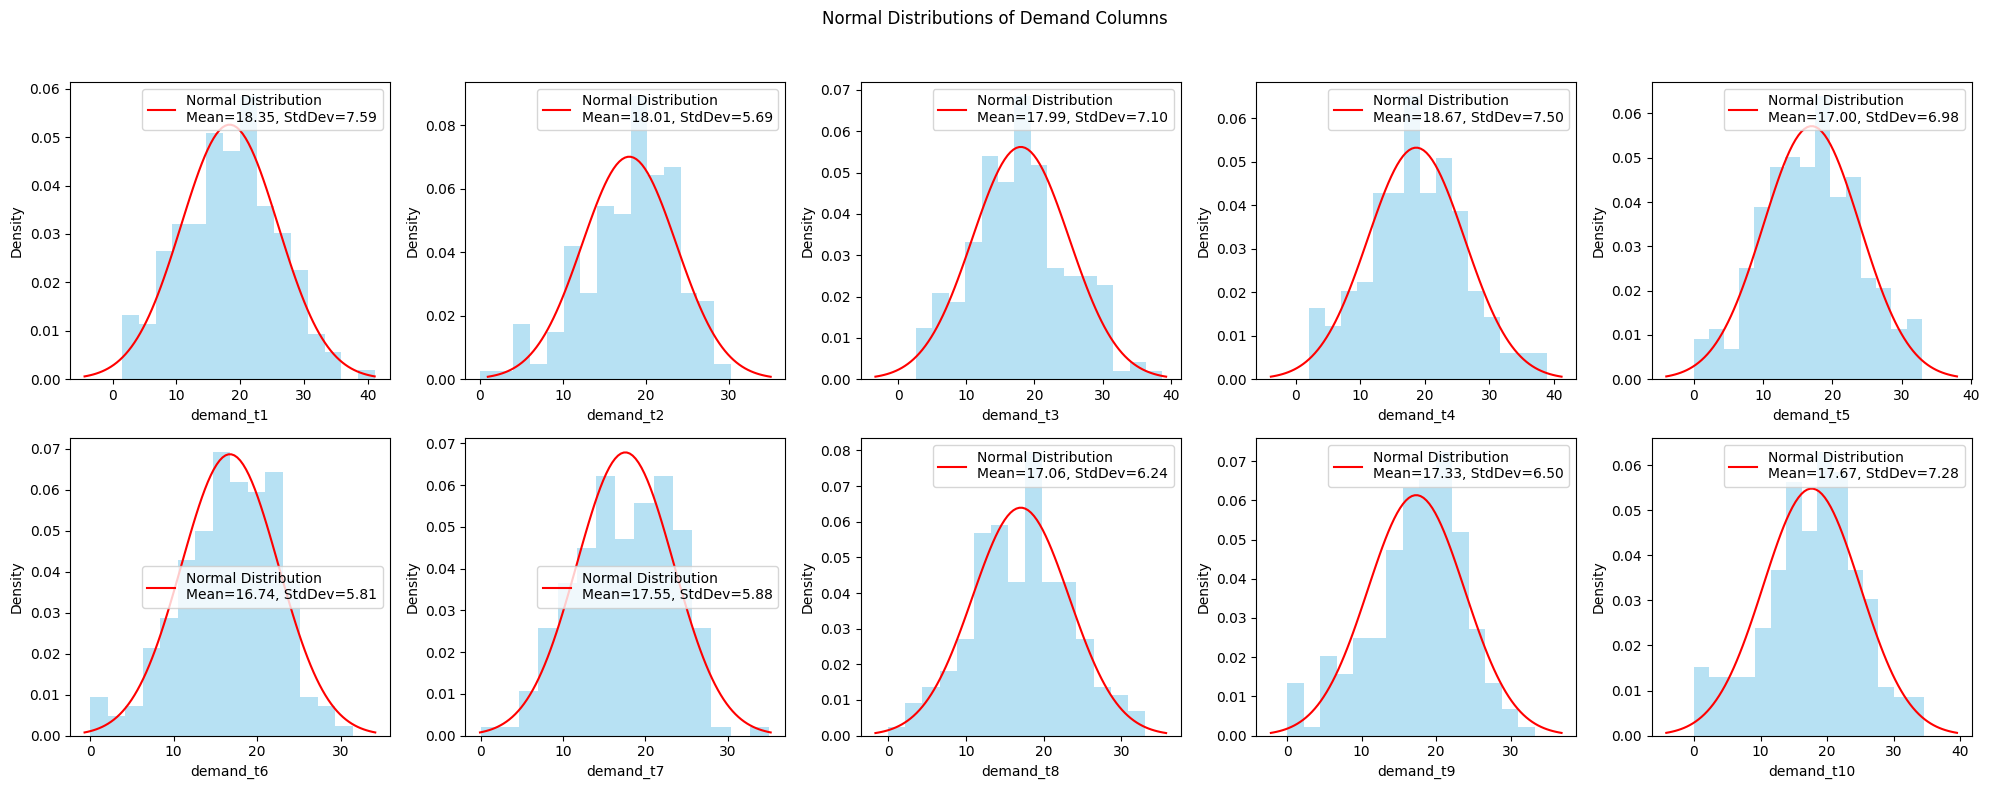

In [29]:
# 創建 2x5 的子圖網格
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle("Normal Distributions of Demand Columns")

for idx, column in enumerate(demand_df.columns):
    data = demand_df[column].dropna()  # 移除缺失值
    mean, std_dev = np.mean(data), np.std(data)

    # 產生 x 值範圍
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 100)
    pdf = norm.pdf(x, mean, std_dev)

    # 確定當前的軸位置
    ax = axes[idx // 5, idx % 5]
    ax.hist(data, bins=15, density=True, alpha=0.6, color="skyblue")
    ax.plot(
        x,
        pdf,
        "r-",
        label=f"Normal Distribution\nMean={mean:.2f}, StdDev={std_dev:.2f}",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("Density")
    ax.legend()

# 移除空白子圖（若有）
for idx in range(len(demand_df.columns), 10):
    fig.delaxes(axes[idx // 5, idx % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Validate the covariance


In [30]:
demand_df.cov()

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1   57.839906  15.814695  32.877992  36.293904 -11.205835   0.133079   
demand_t2   15.814695  32.515903  26.910521  16.664194 -12.918372  -0.185099   
demand_t3   32.877992  26.910521  50.660916  18.115250 -14.580114  -5.128000   
demand_t4   36.293904  16.664194  18.115250  56.516982  -7.876009   6.830898   
demand_t5  -11.205835 -12.918372 -14.580114  -7.876009  48.996005  20.835721   
demand_t6    0.133079  -0.185099  -5.128000   6.830898  20.835721  33.875052   
demand_t7    4.643257  -4.959216 -13.707221  16.054049  18.974080  24.311143   
demand_t8   -7.668639   8.061790   5.817679 -18.936258  14.186079  18.139145   
demand_t9  -16.307310  11.701953  -9.455594   8.914354   4.692970  -2.466831   
demand_t10   8.676886   6.585857   3.097490  22.007390   0.757245  10.557481   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    4.643257  -7.668639 -16.307310    8.676886  
demand_t2   -4.959216   8.061790  11.701953    6.585857  
demand_t3  -13.707221   5.817679  -9.455594    3.097490  
demand_t4   16.054049 -18.936258   8.914354   22.007390  
demand_t5   18.974080  14.186079   4.692970    0.757245  
demand_t6   24.311143  18.139145  -2.466831   10.557481  
demand_t7   34.731892   5.376990   8.473852   24.667608  
demand_t8    5.376990  39.112930   3.697526   10.584576  
demand_t9    8.473852   3.697526  42.501984   22.885760  
demand_t10  24.667608  10.584576  22.885760   53.215507

In [31]:
empirical_covariance = demand_df.cov()
covariance_diff = np.abs(empirical_covariance - np.array(cov_matrices).mean(axis=0))
covariance_diff

demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    2.398708   2.204969   3.223522   5.798046   6.738003   7.010539   
demand_t2    2.204969   5.231733   3.013106   4.247298   4.400598   3.378117   
demand_t3    3.223522   3.013106   0.729909   5.126389   4.510272   4.575759   
demand_t4    5.798046   4.247298   5.126389   7.846568  10.939223   9.986501   
demand_t5    6.738003   4.400598   4.510272  10.939223  10.167793   7.529810   
demand_t6    7.010539   3.378117   4.575759   9.986501   7.529810   0.773702   
demand_t7    8.563398   5.312156   7.328410   9.876274   8.956365   3.997663   
demand_t8    5.223054   5.701250   5.342127   8.725596   2.671551   0.668980   
demand_t9    5.739432   8.207740   8.483711   5.155043  10.524971   9.496205   
demand_t10   9.717615   8.298500   9.236197  10.670985   5.288356   4.889200   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    8.563398   5.223054   5.739432    9.717615  
demand_t2    5.312156   5.701250   8.207740    8.298500  
demand_t3    7.328410   5.342127   8.483711    9.236197  
demand_t4    9.876274   8.725596   5.155043   10.670985  
demand_t5    8.956365   2.671551  10.524971    5.288356  
demand_t6    3.997663   0.668980   9.496205    4.889200  
demand_t7    5.933709   4.066660   8.792237    7.308572  
demand_t8    4.066660   0.446172  11.458472    5.120047  
demand_t9    8.792237  11.458472   5.010675    8.189350  
demand_t10   7.308572   5.120047   8.189350    7.390492

### Validate the corr matrix of damand_df is close to original setting


In [32]:
correlation_matrix = demand_df.corr()
print("Correlation Matrix from demand_df:")
correlation_matrix

Correlation Matrix from demand_df:


demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
demand_t1    1.000000   0.364669   0.607372   0.634790  -0.210499   0.003006   
demand_t2    0.364669   1.000000   0.663037   0.388729  -0.323653  -0.005577   
demand_t3    0.607372   0.663037   1.000000   0.338547  -0.292647  -0.123786   
demand_t4    0.634790   0.388729   0.338547   1.000000  -0.149671   0.156116   
demand_t5   -0.210499  -0.323653  -0.292647  -0.149671   1.000000   0.511432   
demand_t6    0.003006  -0.005577  -0.123786   0.156116   0.511432   1.000000   
demand_t7    0.103596  -0.147571  -0.326775   0.362352   0.459956   0.708763   
demand_t8   -0.161229   0.226060   0.130693  -0.402758   0.324057   0.498330   
demand_t9   -0.328900   0.314779  -0.203774   0.181885   0.102840  -0.065012   
demand_t10   0.156398   0.158323   0.059656   0.401291   0.014830   0.248657   

            demand_t7  demand_t8  demand_t9  demand_t10  
demand_t1    0.103596  -0.161229  -0.328900    0.156398  
demand_t2   -0.147571   0.226060   0.314779    0.158323  
demand_t3   -0.326775   0.130693  -0.203774    0.059656  
demand_t4    0.362352  -0.402758   0.181885    0.401291  
demand_t5    0.459956   0.324057   0.102840    0.014830  
demand_t6    0.708763   0.498330  -0.065012    0.248657  
demand_t7    1.000000   0.145886   0.220553    0.573778  
demand_t8    0.145886   1.000000   0.090687    0.232003  
demand_t9    0.220553   0.090687   1.000000    0.481218  
demand_t10   0.573778   0.232003   0.481218    1.000000

In [33]:
print(f"Original corr_matrix shape: {corr_matrix.shape}")
corr_matrix_df = pd.DataFrame(corr_matrix)
corr_matrix_df

Original corr_matrix shape: (10, 10)


0         1         2         3         4         5         6  \
0  1.000000  0.354243  0.555784  0.587411 -0.387774 -0.161484 -0.099073   
1  0.354243  1.000000  0.645671  0.344249 -0.533962 -0.118714 -0.366601   
2  0.555784  0.645671  1.000000  0.259728 -0.428492 -0.236520 -0.551543   
3  0.587411  0.344249  0.259728  1.000000 -0.433716 -0.078962  0.166233   
4 -0.387774 -0.533962 -0.428492 -0.433716  1.000000  0.371399  0.300310   
5 -0.161484 -0.118714 -0.236520 -0.078962  0.371399  1.000000  0.658292   
6 -0.099073 -0.366601 -0.551543  0.166233  0.300310  0.658292  1.000000   
7 -0.275944  0.072230  0.010563 -0.631022  0.294020  0.520508  0.038941   
8 -0.488891  0.109958 -0.414246  0.089139 -0.153719 -0.341738 -0.009772   
9 -0.020925 -0.049126 -0.128709  0.244177 -0.108549  0.147419  0.485870   

          7         8         9  
0 -0.275944 -0.488891 -0.020925  
1  0.072230  0.109958 -0.049126  
2  0.010563 -0.414246 -0.128709  
3 -0.631022  0.089139  0.244177  
4  0.294020 -0.153719 -0.108549  
5  0.520508 -0.341738  0.147419  
6  0.038941 -0.009772  0.485870  
7  1.000000 -0.203659  0.130487  
8 -0.203659  1.000000  0.355112  
9  0.130487  0.355112  1.000000

### Split test and train demand_df


In [34]:
def demand_data_split_data_k_fold(data, train_size, k_fold=2):
    folds = []
    for i in range(k_fold):
        train_data, test_data = train_test_split(
            data, train_size=train_size, random_state=i
        )
        test_data.reset_index(drop=True, inplace=True)
        train_data.reset_index(drop=True, inplace=True)
        folds.append((train_data, test_data))
    return folds

In [35]:
demand_folds = demand_data_split_data_k_fold(demand_df, train_size, k_fold=k_fold)

for i, (train, test) in enumerate(demand_folds):
    print(f"Fold {i + 1}:")
    print(f"Train size: {train.shape}, Test size: {test.shape}")
    print(f"train.head(): \n{train.head()}")
    print()

Fold 1:
Train size: (100, 10), Test size: (100, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0  10.317599  22.936856  19.197988  12.807640  17.168208  25.707959   
1  11.877760  10.185762   2.793092  12.510755  18.302496  10.354521   
2  21.630971  16.631460  12.308551  19.675663  19.581793  23.507433   
3  14.994492   0.000000   6.276855   6.287719  28.739691  20.915456   
4  20.086069   5.535924  10.473634  17.085321  26.125642  18.109769   

   demand_t7  demand_t8  demand_t9  demand_t10  
0  11.687342  33.050261  18.107736   21.062906  
1  25.780798  14.015581  25.373772   30.763191  
2  21.043423  25.229375  17.052474   18.085573  
3  24.111980  18.040681   5.732286   15.006440  
4  16.285452  11.154995   4.600115    1.513687  

Fold 2:
Train size: (100, 10), Test size: (100, 10)
train.head(): 
   demand_t1  demand_t2  demand_t3  demand_t4  demand_t5  demand_t6  \
0   9.865213  15.597623  14.484878   2.659247  19.317135  19.348738   
1 

In [36]:
# # Only for testing
# demand_df_train = demand_df_test = demand_df

### Define the Q star(Q optimal)


In [37]:
def calculate_Q_star(demand_df, service_level=0.95):

    # 計算每一行的總和
    demand_sum = demand_df.sum(axis=1)

    # 計算總和的均值和標準差
    mean_sum = demand_sum.mean()
    std_sum = demand_sum.std()

    # 計算總和的95%百分位數值
    Q_star = norm.ppf(service_level, loc=mean_sum, scale=std_sum)

    # 打印結果
    print(f"mean of sum: {mean_sum}")
    print(f"std of sum: {std_sum}")
    print(f"{service_level*100} percentile of sum: {Q_star}")

    return Q_star

In [38]:
demand_df_train_1 = demand_folds[0][0]
Q_star = calculate_Q_star(demand_df_train_1, service_level=0.95)
print(f"Q_star: {Q_star}\n")

demand_df_train_2 = demand_folds[1][0]
Q_star = calculate_Q_star(demand_df_train_2, service_level=0.95)
print(f"Q_star: {Q_star}\n")

mean of sum: 176.95368306114221
std of sum: 31.884856997434746
95.0 percentile of sum: 229.39960573820179
Q_star: 229.39960573820179

mean of sum: 176.9730424906599
std of sum: 31.44506309574825
95.0 percentile of sum: 228.69556857341928
Q_star: 228.69556857341928



## Data3: Qk hat df


### Functions


In [39]:
# 計算條件分佈的函數
def calculate_conditional_distribution(mu, covariance_matrix, x_observed, k):
    mu_1 = mu[:k]
    mu_2 = mu[k:]
    Sigma_11 = covariance_matrix[:k, :k]
    Sigma_22 = covariance_matrix[k:, k:]
    Sigma_12 = covariance_matrix[k:, :k]
    Sigma_21 = covariance_matrix[:k, k:]

    # Compute conditional mean and covariance
    Sigma_11_inv = np.linalg.pinv(Sigma_11)
    mu_cond = mu_2 + np.dot(Sigma_12, np.dot(Sigma_11_inv, (x_observed - mu_1)))
    sigma_cond = Sigma_22 - np.dot(Sigma_12, np.dot(Sigma_11_inv, Sigma_21))

    return mu_cond, sigma_cond

In [40]:
def cal_Var_Y(sigma_cond):

    # Extract the variances (diagonal elements)
    variances = np.diag(sigma_cond)

    # Calculate the sum of covariances (off-diagonal elements)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)

    # Total variance for the sum of mu_cond
    total_variance = np.sum(variances) + covariances_sum

    return total_variance

In [41]:
def cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed):
    # predict_quantity = mu_cond + norm.ppf(service_level) * np.sqrt(np.diag(sigma_cond))
    # Qk_hat = x_observed.sum() + predict_quantity.sum()

    mean_Y = np.sum(mu_cond)
    var_Y = cal_Var_Y(sigma_cond)

    sd_Y = np.sqrt(var_Y)
    if sd_Y < 0 or np.isnan(sd_Y):  # scale must be positive
        sd_Y = 1e-6

    percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=sd_Y)

    # print(f"        mean_Y: {mean_Y}")
    # print(f"        sd_Y: {sd_Y}")
    # print(f"    percentile_95_Y: {percentile_95_Y}")

    Qk_hat = x_observed.sum() + percentile_95_Y
    return Qk_hat

In [42]:
def cal_mu_and_cov_matrix(demand_df_train):

    mu_matrix = demand_df_train.mean().values
    covariance_matrix = demand_df_train.cov().values

    # print(f"mu_matrix: {mu_matrix}")
    # print(f"covariance_matrix: \n{covariance_matrix}\n")

    return mu_matrix, covariance_matrix

In [43]:
def make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix):
    results_df = pd.DataFrame(index=demand_df.index)

    for index, row_data in demand_df.iterrows():
        for k in range(2, T):
            # print(f"Now processing index: {index}, t={k}")

            x_observed = row_data[
                : k - 1
            ].values  # 取出前 k 個觀測值 -> Qk_hat_2(t=2): 則 observerd: T=1

            mu_cond, sigma_cond = calculate_conditional_distribution(
                mu_matrix, covariance_matrix, x_observed, len(x_observed)
            )

            Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)

            results_df.loc[index, f"Qk_hat_k{k}"] = Qk_hat

            # print(f"    x_observed: {x_observed}")
            # print(f"    mu_cond: {mu_cond}")
            # print(f"    sigma_cond: \n{sigma_cond}")
            # print(f"    Qk_hat: {Qk_hat}")
            # print("\n")

    return results_df

公式連結：https://jujueffectivelife.notion.site/Qk-eab4d89ec36345efbf3a0d4a4f488474?pvs=4


### Validate the consistency of condMVN in Python and R


#### Given mu and sigma


In [44]:
from scipy.stats import multivariate_normal

# Define the mean vector and the covariance matrix
mu = np.array([10, 20, 30, 40])
covariance_matrix = np.array([[5, 1, 0, 2], [1, 8, 1, 0], [0, 1, 10, 1], [2, 0, 1, 7]])

# Mean and covariance partitioning
mu_1 = mu[:2]
mu_2 = mu[2:]
Sigma_11 = covariance_matrix[:2, :2]
Sigma_22 = covariance_matrix[2:, 2:]
Sigma_12 = covariance_matrix[2:, :2]
Sigma_21 = covariance_matrix[:2, 2:]

print(f"Sigma_11: \n{Sigma_11}\n")
print(f"Sigma_22: \n{Sigma_22}\n")
print(f"Sigma_12: \n{Sigma_12}\n")
print(f"Sigma_21: \n{Sigma_21}\n")

Sigma_11: 
[[5 1]
 [1 8]]

Sigma_22: 
[[10  1]
 [ 1  7]]

Sigma_12: 
[[0 1]
 [2 0]]

Sigma_21: 
[[0 2]
 [1 0]]



In [45]:
# Observed values of X1 and X2
x_observed = np.array([6, 30])

mu_cond, sigma_cond = calculate_conditional_distribution(
    mu, covariance_matrix, x_observed, len(x_observed)
)
print(f"mu_cond: {mu_cond}")
print(f"sigma_cond: \n{sigma_cond}")

mu_cond: [31.38461538 37.84615385]
sigma_cond: 
[[9.87179487 1.05128205]
 [1.05128205 6.17948718]]


In [46]:
# Define the conditional distribution
conditional_dist = multivariate_normal(mean=mu_cond, cov=sigma_cond)

# Values at which to evaluate the PDF and CDF
x3, x4 = 30, 40  # These can be any values of interest

# Calculate the PDF
pdf_value = conditional_dist.pdf([x3, x4])
print(f"Conditional density at X3 = {x3}, X4 = {x4}: {pdf_value}")

# Calculate the CDF
cdf_value = conditional_dist.cdf([x3, x4])
print(f"Conditional cumulative probability up to X3 = {x3}, X4 = {x4}: {cdf_value}")

# Qk hat
Qk_hat = cal_Qk_hat(mu_cond, sigma_cond, service_level, x_observed)
print(f"Qk_hat of x_observed: {Qk_hat}")

Conditional density at X3 = 30, X4 = 40: 0.012061749355189695
Conditional cumulative probability up to X3 = 30, X4 = 40: 0.2790601403798458
Qk_hat of x_observed: 112.23905144741786


```
R 中運行的結果
```

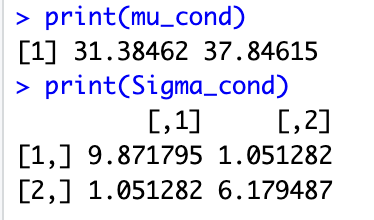
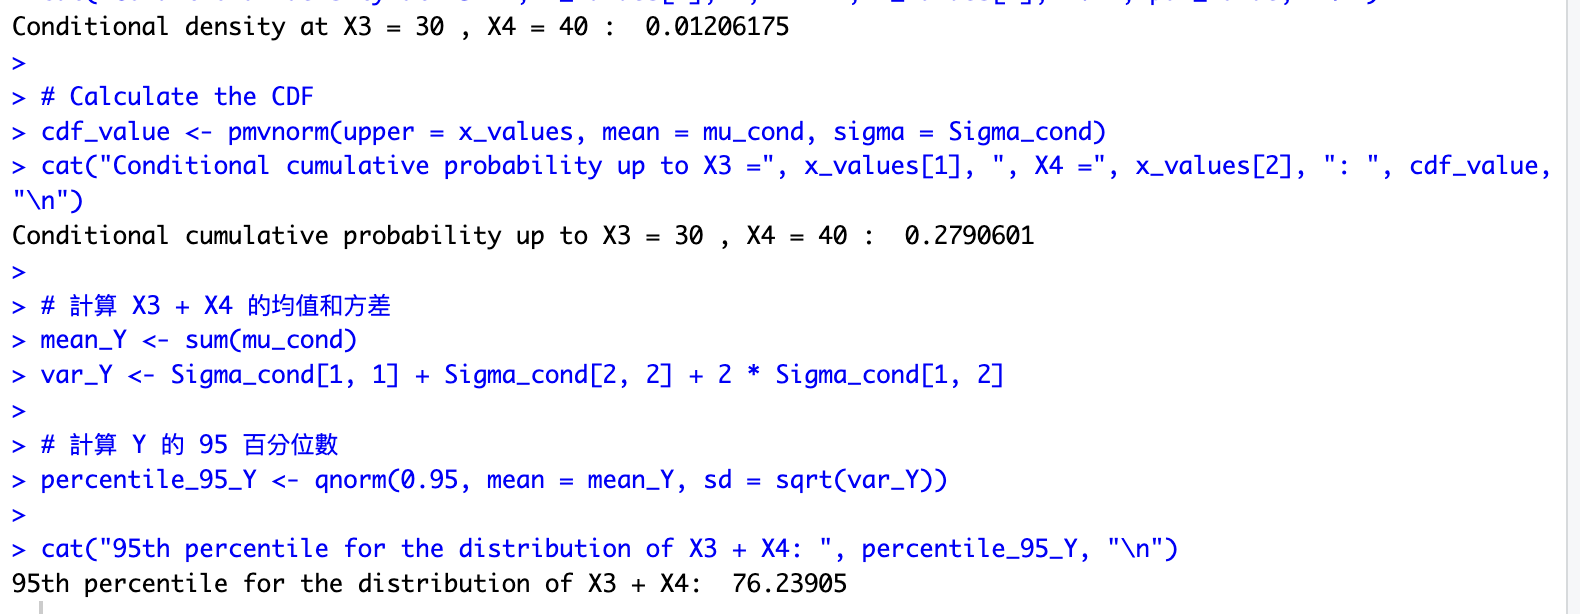


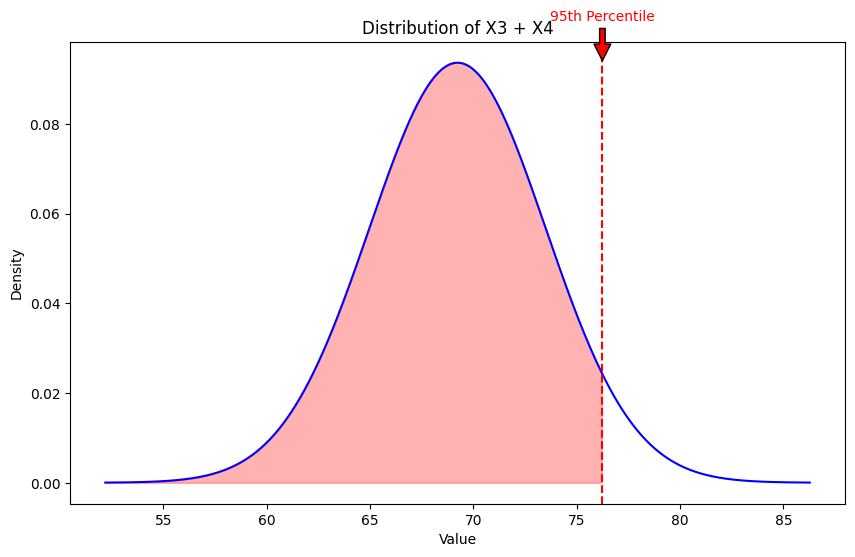

In [47]:
import matplotlib.pyplot as plt
from scipy.stats import norm

mean_Y = np.sum(mu_cond)
var_Y = cal_Var_Y(sigma_cond)

percentile_95_Y = norm.ppf(service_level, loc=mean_Y, scale=np.sqrt(var_Y))

# Generate normal distribution data
x_values = np.linspace(mean_Y - 4 * np.sqrt(var_Y), mean_Y + 4 * np.sqrt(var_Y), 1000)
y_values = norm.pdf(x_values, loc=mean_Y, scale=np.sqrt(var_Y))

# Create dataframe
data = pd.DataFrame({"x": x_values, "y": y_values})

# Plot distribution
plt.figure(figsize=(10, 6))
plt.plot(data["x"], data["y"], color="blue")
plt.axvline(x=percentile_95_Y, color="red", linestyle="dashed")
plt.fill_between(
    data["x"], data["y"], where=(data["x"] <= percentile_95_Y), color="red", alpha=0.3
)
plt.title("Distribution of X3 + X4")
plt.xlabel("Value")
plt.ylabel("Density")
plt.annotate(
    "95th Percentile",
    xy=(percentile_95_Y, max(y_values)),
    xytext=(percentile_95_Y, max(y_values) * 1.1),
    arrowprops=dict(facecolor="red", shrink=0.05),
    color="red",
    ha="center",
)
plt.show()

```
以下為 R 程式結果
```


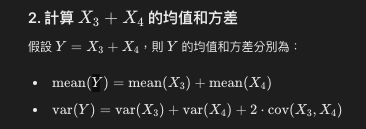


P(X3,X4∣X1=10,X2=20) 的 R 計算如下

```
install.packages("condMVNorm")
install.packages("mvtnorm")
library(condMVNorm)
library(mvtnorm)
library(ggplot2)

# Define the mean vector and covariance matrix
mu <- c(10, 20, 30, 40)
sigma <- matrix(c(
    5, 1, 0, 2,
    1, 8, 1, 0,
    0, 1, 10, 1,
    2, 0, 1, 7
), nrow = 4, byrow = TRUE)

# Observed values of X1 and X2
x_observed <- c(6, 30)

# Compute the conditional mean and covariance using condMVNorm
conditional_results <- condMVN(mean = mu, sigma = sigma, dependent.ind = c(3, 4), given.ind = c(1, 2), X.given = x_observed)

# Print the conditional mean and covariance
print(conditional_results$condMean)
print(conditional_results$condVar)

# Extract the conditional mean and covariance
mu_cond <- conditional_results$condMean
Sigma_cond <- conditional_results$condVar

# Print the conditional mean and covariance
print(mu_cond)
print(Sigma_cond)

# Values at which to evaluate the PDF and CDF
x_values <- c(30, 40)

# Calculate the PDF
pdf_value <- dmvnorm(x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional density at X3 =", x_values[1], ", X4 =", x_values[2], ": ", pdf_value, "\n")

# Calculate the CDF
cdf_value <- pmvnorm(upper = x_values, mean = mu_cond, sigma = Sigma_cond)
cat("Conditional cumulative probability up to X3 =", x_values[1], ", X4 =", x_values[2], ": ", cdf_value, "\n")

```


#### Conditional mean and variance


In [48]:
def cal_Var_Y(sigma_cond):
    variances = np.diag(sigma_cond)
    covariances_sum = np.sum(sigma_cond) - np.sum(variances)
    total_variance = np.sum(variances) + covariances_sum

    return total_variance


def simulate_Y(mu_cond, sigma_cond, num_samples=10000):
    samples = np.random.multivariate_normal(mu_cond, sigma_cond, num_samples)

    Y = samples[:, 0] + samples[:, 1]

    mean_Y = np.mean(Y)
    var_Y = np.var(Y)

    return mean_Y, var_Y


mu_cond = [2, 3]
sigma_cond = [[1, 0.5], [0.5, 1]]

mean_Y_formula = np.sum(mu_cond)
var_Y_formula = cal_Var_Y(sigma_cond)

mean_Y_simulated, var_Y_simulated = simulate_Y(mu_cond, sigma_cond)

print(f"公式計算的Y的均值: {mean_Y_formula}")
print(f"公式計算的Y的方差: {var_Y_formula}")
print(f"模擬計算的Y的均值: {mean_Y_simulated}")
print(f"模擬計算的Y的方差: {var_Y_simulated}")

公式計算的Y的均值: 5
公式計算的Y的方差: 3.0
模擬計算的Y的均值: 5.011755834494106
模擬計算的Y的方差: 2.9647224726499766


### Calculate Qk hat for 2~T-1 of demand_df_train


In [49]:
demand_df_train = demand_folds[0][0]

In [50]:
_, _ = cal_mu_and_cov_matrix(demand_df_train)

In [51]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df)
Qk_hat_df = make_Qk_hat_df(demand_df, T, service_level, mu_matrix, covariance_matrix)

In [52]:
Qk_hat_df

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0    216.468288  170.969889  169.658677  154.837078  157.369715  158.247988   
1    227.097428  216.966189  209.012057  202.437179  209.519162  215.751914   
2    271.326460  260.782172  255.781234  238.934373  205.786046  205.204326   
3    212.377387  226.319146  227.752495  209.793004  195.666050  184.717680   
4    219.678978  197.433485  187.278763  183.197258  155.363564  130.894102   
..          ...         ...         ...         ...         ...         ...   
195  221.197265  234.280557  232.513844  242.045867  219.191381  204.001193   
196  231.044551  191.234520  187.651196  173.650621  149.161083  144.480949   
197  206.343532  186.538947  190.534201  185.425028  172.962464  170.429504   
198  218.070363  210.121914  210.612106  195.034916  142.969377  138.732122   
199  215.771978  198.874234  204.658677  197.568750  194.928462  199.605117   

      Qk_hat_k8   Qk_hat_k9  
0    158.645195  148.520629  
1    215.088542  205.183534  
2    200.968218  197.470116  
3    184.536437  180.615063  
4    111.674381  105.588506  
..          ...         ...  
195  190.458137  188.570527  
196  124.276430  118.117624  
197  159.049830  151.052944  
198  125.954058  117.170575  
199  196.332162  196.326781  

[200 rows x 8 columns]

### Plot the distribuction


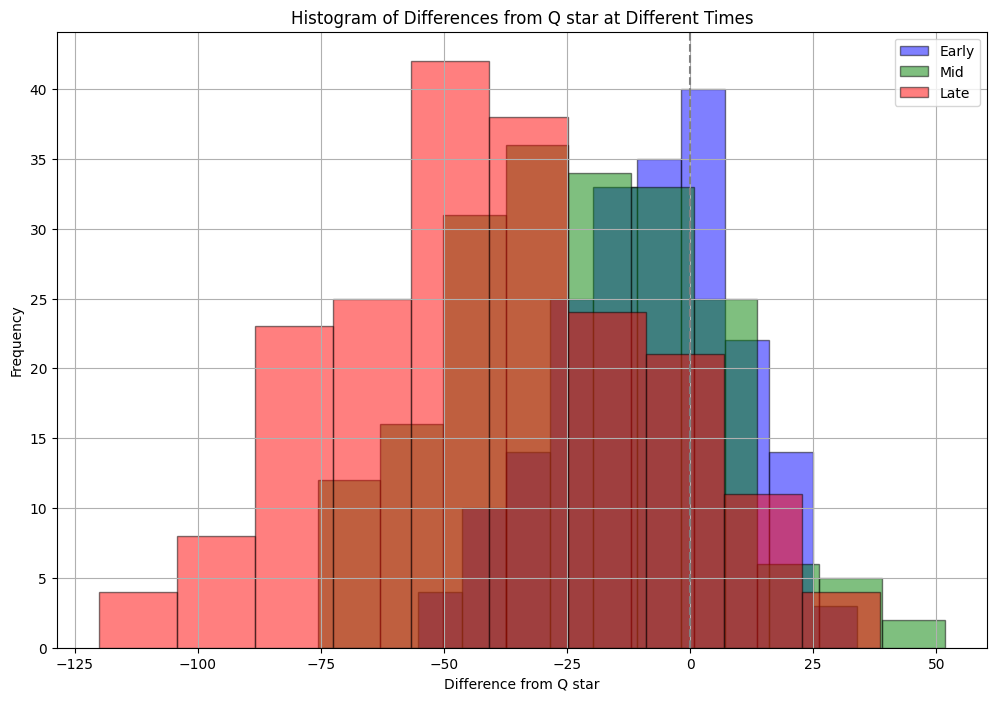

Q_star is: 228.69556857341928
Early bias: -8.57334748445925
Mid bias: -22.782802781215743
Late bias: -40.16707653422824


In [53]:
# 將 T 個時期分成三份
early_values = Qk_hat_df.iloc[:, : T // 3].mean(axis=1)
mid_values = Qk_hat_df.iloc[:, T // 3 : 2 * T // 3].mean(axis=1)
late_values = Qk_hat_df.iloc[:, 2 * T // 3 :].mean(axis=1)

# 計算與 Q_star 的差距
early_diff = early_values - Q_star
mid_diff = mid_values - Q_star
late_diff = late_values - Q_star

# 繪製直方圖
plt.figure(figsize=(12, 8))

# 早期
plt.hist(early_diff, bins=10, alpha=0.5, label="Early", color="blue", edgecolor="black")
# 中期
plt.hist(mid_diff, bins=10, alpha=0.5, label="Mid", color="green", edgecolor="black")
# 晚期
plt.hist(late_diff, bins=10, alpha=0.5, label="Late", color="red", edgecolor="black")

plt.axvline(0, color="grey", linestyle="--")

plt.xlabel("Difference from Q star")
plt.ylabel("Frequency")
plt.title("Histogram of Differences from Q star at Different Times")
plt.legend()
plt.grid(True)
plt.show()

# 計算偏差
early_bias = np.mean(early_diff)
mid_bias = np.mean(mid_diff)
late_bias = np.mean(late_diff)

print(f"Q_star is: {Q_star}")
print(f"Early bias: {early_bias}")
print(f"Mid bias: {mid_bias}")
print(f"Late bias: {late_bias}")

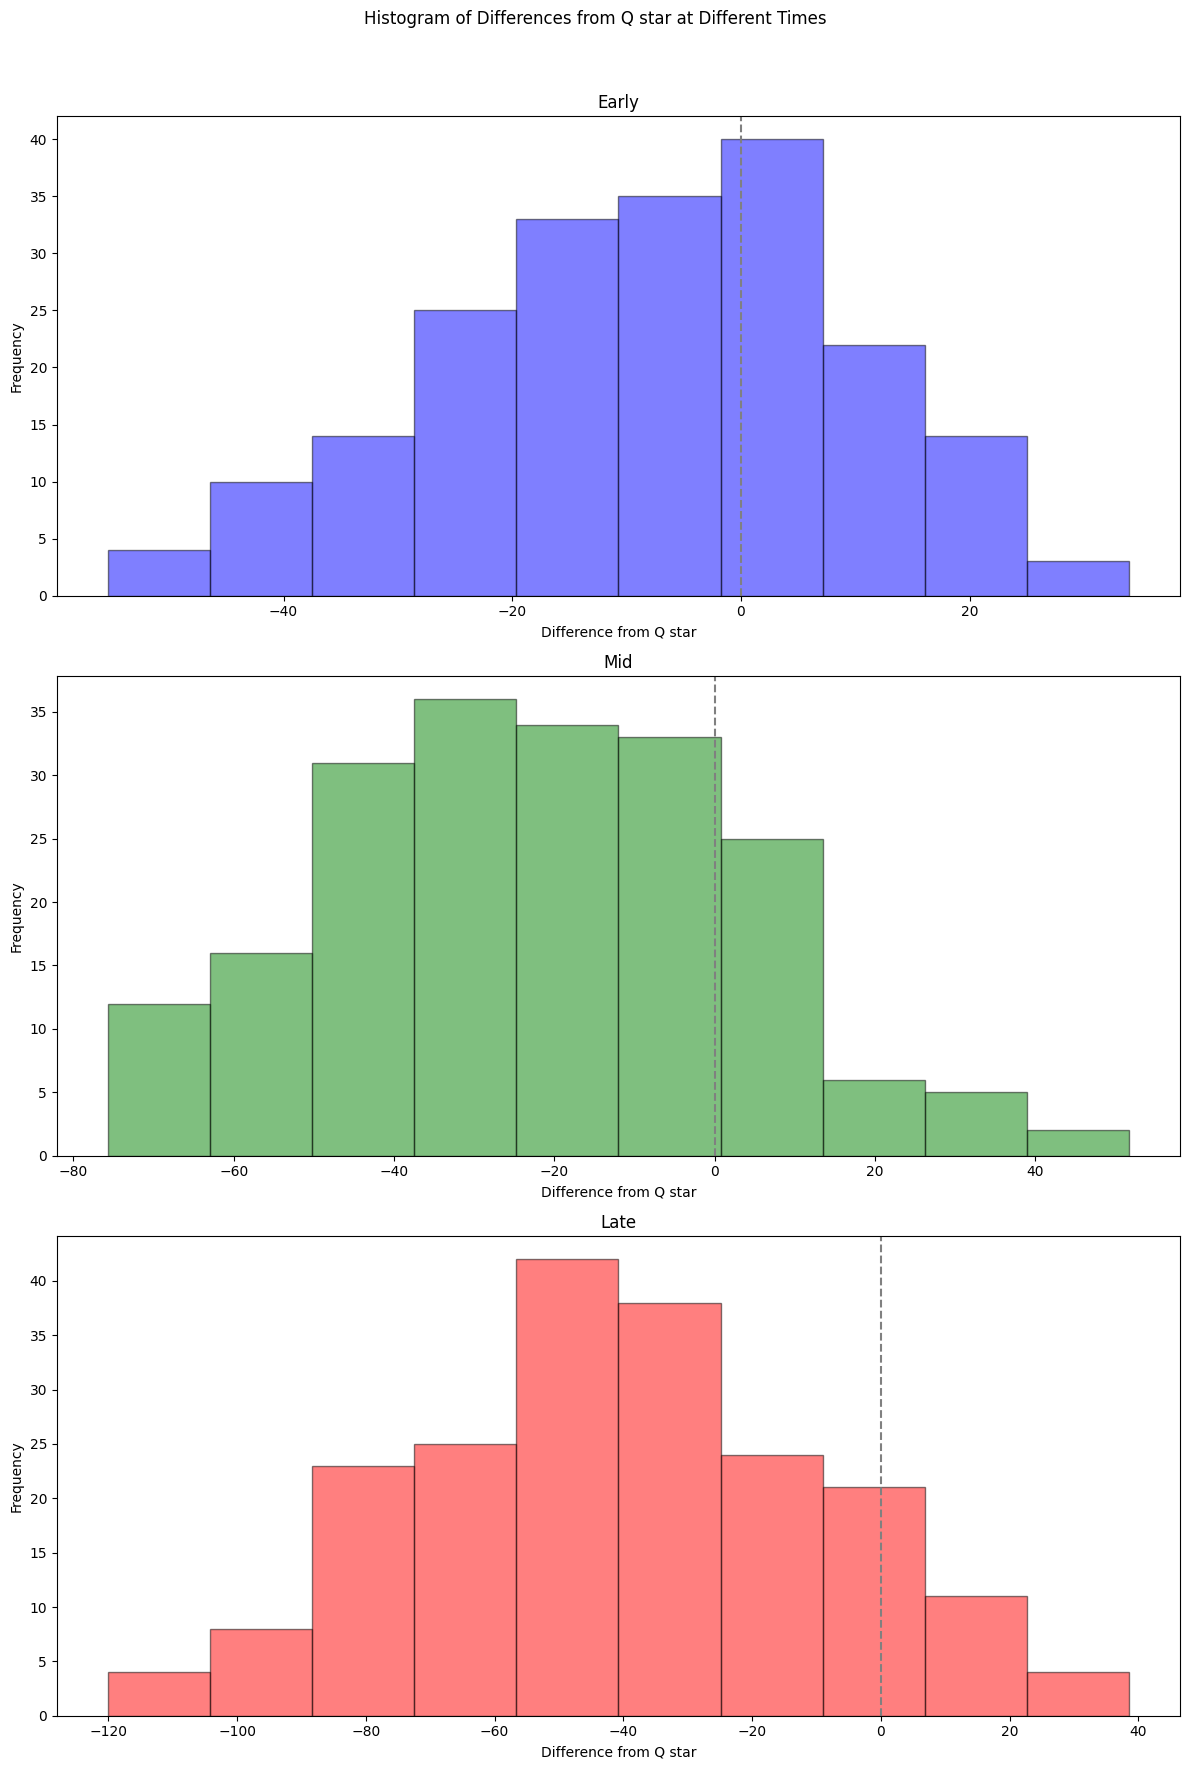

In [54]:
# 繪製直方圖
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# 早期
axes[0].hist(early_diff, bins=10, alpha=0.5, color="blue", edgecolor="black")
axes[0].axvline(0, color="grey", linestyle="--")
axes[0].set_title("Early")
axes[0].set_xlabel("Difference from Q star")
axes[0].set_ylabel("Frequency")

# 中期
axes[1].hist(mid_diff, bins=10, alpha=0.5, color="green", edgecolor="black")
axes[1].axvline(0, color="grey", linestyle="--")
axes[1].set_title("Mid")
axes[1].set_xlabel("Difference from Q star")
axes[1].set_ylabel("Frequency")

# 晚期
axes[2].hist(late_diff, bins=10, alpha=0.5, color="red", edgecolor="black")
axes[2].axvline(0, color="grey", linestyle="--")
axes[2].set_title("Late")
axes[2].set_xlabel("Difference from Q star")
axes[2].set_ylabel("Frequency")

fig.suptitle("Histogram of Differences from Q star at Different Times")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Strategies utils


## S0 - One-time Procurement


In [55]:
def one_time_procurement(Q_star, demand_df, cost, price, salvage_value):

    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []

    for i, row in demand_df.iterrows():
        inventory = Q_star
        losses = []
        lefts = []
        daily_operation_profits = []
        daily_profits = []
        total_sold = 0  # 追蹤總售出量
        total_lost = 0  # 追蹤總丟失量

        print("=" * 50)
        print(
            f"Processing row {i+1}/{len(demand_df)} with initial inventory Q_star={Q_star}"
        )
        print("=" * 50)

        for day, demand in enumerate(row):
            sales = min(inventory, demand)
            loss = max(demand - inventory, 0)
            left = max(inventory - sales, 0)
            total_sold += sales
            total_lost += loss

            inventory -= sales

            print("-" * 50)
            print(f"Day {day+1}")
            print(f"Demand      : {demand}")
            print(f"Sales       : {sales}")
            print(f"Loss        : {loss}")
            print(f"Left        : {left}")
            print(f"Inventory   : {inventory}")
            print("-" * 50)

            if day == len(row) - 1:
                left_penalty_cost = (cost - salvage_value) * left
                lefts.append(left)
                print(f"End of period: Left Penalty Cost = {left_penalty_cost}")
                print("-" * 50)
            else:
                left_penalty_cost = 0

        operation_profit = (price - cost) * total_sold
        profit = operation_profit - left_penalty_cost - (price - cost) * total_lost

        print("=" * 50)
        print(f"Row {i+1} Summary")
        print(f"Total Sold         : {total_sold}")
        print(f"Total Lost         : {total_lost}")
        print(f"Operation Profit   : {operation_profit}")
        print(f"Profit             : {profit}")
        print("=" * 50)

        all_losses.append(total_lost)
        all_lefts.append(sum(lefts))
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)

    avg_losses = np.mean(all_losses)
    avg_lefts = np.mean(all_lefts)
    avg_operation_profits = np.mean(all_operation_profits)
    avg_profits = np.mean(all_profits)

    print("=" * 50)
    print("Overall Summary")
    print(f"Average Losses           : {avg_losses}")
    print(f"Average Lefts            : {avg_lefts}")
    print(f"Average Operation Profits: {avg_operation_profits}")
    print(f"Average Profits          : {avg_profits}")
    print("=" * 50)

    stimulation_df = pd.DataFrame(
        {
            "losses": all_losses,
            "lefts": all_lefts,
            "operation_profits": all_operation_profits,
            "profits": all_profits,
        }
    )

    return avg_losses, avg_lefts, avg_profits, avg_operation_profits, stimulation_df

## S1 - Grid for Fixed F & Fixed Rk


In [56]:
def cal_fixed_F_fixed_R(
    Q_star, assigned_F, assigned_R, demand_df, cost, price, salvage_value, Qk_hat_df
):
    all_losses = []
    all_lefts = []
    all_left0s = []
    all_left1s = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = operation_profit - left_penalty_cost - lost_penalty_cost

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_left0s.append(left_0)
        all_left1s.append(left_1)

        print(f"這是第 {i+1} 筆模擬資料\n")
        print(f"F: {assigned_F}, R: {assigned_R+2}")
        print(f"Q_star 為 {Q_star}")
        print(f"期初庫存 Q0: {Q0}")
        print(f"重新估計量 Qk_hat: {Qk_hat}")
        print(f"訂貨量 Q1 為 {Q1}\n")

        print(
            f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}"
        )
        print(
            f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}\n"
        )
        print(
            f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，Profit 為 {profit}"
        )
        print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
    }

    return result_df, stimulation_result

In [57]:
def grid_fixed_F_fixed_R(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [58]:
def cal_fixed_F_fixed_R_with_holding_cost(
    Q_star,
    assigned_F,
    assigned_R,
    demand_df,
    cost,
    price,
    salvage_value,
    Qk_hat_df,
    holding_cost,
):
    all_losses = []
    all_lefts = []
    all_operation_profits = []
    all_profits = []
    all_q0s = []
    all_q1s = []
    all_holding_costs_0 = []
    all_holding_costs_1 = []
    all_left0s = []
    all_left1s = []
    all_lost0s = []
    all_lost1s = []

    Q0 = assigned_F * Q_star  # 期初庫存

    print(f"\n")
    print(f"====" * 10)
    print(f"\n")

    for i, row in demand_df.iterrows():

        # 第一階段計算
        total_sold_0 = min(Q0, row[: assigned_R + 1].sum())  # 第一階段售出量
        left_0 = max(Q0 - total_sold_0, 0)  # 第一階段剩餘
        lost_0 = max(row[: assigned_R + 1].sum() - Q0, 0)

        # 第二階段開始補貨，根據指定的 R
        Qk_hat = Qk_hat_df.iloc[i, assigned_R]
        Q1 = max((Qk_hat - Q0), 0)  # 二次訂貨量
        total_sold_1 = min(Q1 + left_0, row[assigned_R + 1 :].sum())  # 第二階段售出量
        left_1 = max((Q1 + left_0) - total_sold_1, 0)  # 第二階段剩餘
        lost_1 = max(row[assigned_R + 1 :].sum() - (Q1 + left_0), 0)

        # 統計
        total_sold = total_sold_0 + total_sold_1
        total_lost = lost_0 + lost_1

        # 計算 holding_cost
        """
        今天 T = 10, 假設 R = 5 (此時 assigned_R=3), 此時:
        第一階段是 T=1~4 -> 高為 R-1 = (assigned_R+2) - 1
        第二階段是 T=5~10 -> 高為 T - R = T - (assigned_R+2)
        """

        first_holding_cost = (Q0 + left_0 + Q1) * ((assigned_R + 2) - 1) / 2
        # T = 1 ~ R+1, R+1 才是代表 R(T)
        second_holding_cost = (Q1 + left_0 + left_1) * (T - (assigned_R + 2)) / 2
        # T = R+1 ~ T
        holding_penalty = holding_cost * (first_holding_cost + second_holding_cost)

        # 計算運營利潤和總利潤
        operation_profit = (price - cost) * total_sold
        left_penalty_cost = (cost - salvage_value) * left_1
        lost_penalty_cost = (price - cost) * total_lost
        profit = (
            operation_profit - left_penalty_cost - lost_penalty_cost - holding_penalty
        )

        all_losses.append(total_lost)
        all_lefts.append(left_1)
        all_operation_profits.append(operation_profit)
        all_profits.append(profit)
        all_q0s.append(Q0)
        all_q1s.append(Q1)
        all_holding_costs_0.append(first_holding_cost)
        all_holding_costs_1.append(second_holding_cost)
        all_left0s.append(left_0)
        all_left1s.append(left_1)
        all_lost0s.append(lost_0)
        all_lost1s.append(lost_1)

        # print(f"這是第 {i+1} 筆模擬資料\n")
        # print(f"F: {assigned_F}, R: {assigned_R+2}")
        # print(f"Q_star 為 {Q_star}")
        # print(f"期初庫存 Q0: {Q0}")
        # print(f"重新估計量 Qk_hat: {Qk_hat}")
        # print(f"訂貨量 Q1 為 {Q1}\n")

        # print(
        #     f"第一階段：期初庫存 Q0: {Q0}，需求量為 {row[:assigned_R + 1].sum()}，Sold_0 為 {total_sold_0}，Left_0 為 {left_0}，Lost_0 為 {lost_0}, first_holding_cost 為 {first_holding_cost}"
        # )
        # print(
        #     f"第二階段：期初庫存 Q1+left_0 為 {Q1+left_0}，需求量為 {row[assigned_R + 1:].sum()}，Sold_1 為 {total_sold_1}，Left_1 為 {left_1}，Lost_1 為 {lost_1}, second_holding_cost 為 {second_holding_cost}\n"
        # )
        # print(
        #     f"統計結果：Sold 為 {total_sold}, Lost 為 {total_lost} Left_Penalty_Cost 為 {left_penalty_cost}，Lost_Penalty_Cost 為 {lost_penalty_cost}，holding_penalty 為 {holding_penalty}，Profit 為 {profit}"
        # )
        # print("----" * 10)

    result_df = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "average_profits": np.mean(all_profits),
        "average_losses": np.mean(all_losses),
        "average_lefts": np.mean(all_lefts),
        "average_operation_profits": np.mean(all_operation_profits),
    }

    stimulation_result = {
        "R(T)": assigned_R + 2,
        "F": assigned_F,
        "profits": all_profits,
        "losses": all_losses,
        "lefts": all_lefts,
        "operation_profits": all_operation_profits,
        "Q0": all_q0s,
        "Q1": all_q1s,
        "hc0": all_holding_costs_0,
        "hc1": all_holding_costs_1,
        "Left0s": all_left0s,
        "Left1s": all_left1s,
        "lost0s": all_lost0s,
        "lost1s": all_lost1s,
    }

    return result_df, stimulation_result

In [59]:
def grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts,
    assigned_Fs,
    cost,
    price,
    salvage_value,
    holding_cost,
    Qk_hat_df,
    demand_df_train,
    Q_star,
):

    results_list = []
    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        for assigned_F in assigned_Fs:
            assigned_R = assigned_T - 2
            mean_result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
                Q_star,
                assigned_F,
                assigned_R,
                demand_df_train,
                cost,
                price,
                salvage_value,
                Qk_hat_df,
                holding_cost,
            )
            results_list.append(mean_result)

            if max_profit is None or max_profit < mean_result["average_profits"]:
                print(
                    f"max_profit is changed from {max_profit} to {mean_result['average_profits']}"
                )
                max_profit = mean_result["average_profits"]
                max_profit_stimulation_result = stimulation_result

    results_df_1 = pd.DataFrame(results_list).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(max_profit_stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [60]:
def cal_flexible_F_fixed_R(
    assigned_R,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            ## 只會有一個 R 為 1
            model.addConstr(R_vars[i, assigned_R] == 1, name=f"Set_R_{i}_0_To_1")
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                alpha_values = np.array([alpha.X for key, alpha in alphas.items()])

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (assigned_R+1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(assigned_R+1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [61]:
def grid_flexible_F_fixed_R(
    assigned_Ts,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "R": [],
        "average_profits": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "alpha_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_T in assigned_Ts:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is T={assigned_T} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )

        assigned_R = assigned_T - 2
        result = cal_flexible_F_fixed_R(
            assigned_R=assigned_R,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:

            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                alpha_values,
                F_vars,
                Q0_vars,
                Q1_vars,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(assigned_T)
            results_dict["R"].append([x - 2 for x in all_Rs])
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["alpha_values"].append(alpha_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)  # 紀錄該策略組合每一次模擬的 Q0
            results_dict["Q1_vars"].append(Q1_vars)  # 紀錄該策略組合每一次模擬的 Q1

            print(f"The average profits is {average_profits}")

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R": [x - 2 for x in all_Rs],
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## S3 - Grid for Fixed F & Flexible Rk(with full beta)

In [62]:
def cal_fixed_F_flexible_R(
    assigned_F,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df,
    training_df,
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            model.addConstr(F_vars[i] == assigned_F)
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )
                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    beta_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [63]:
def grid_fixed_F_flexible_R(
    assigned_Fs,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_train,
    Qk_hat_df_train,
    training_df,
):
    results_dict = {
        "R(T)": [],
        "average_losses": [],
        "average_lefts": [],
        "average_operation_profits": [],
        "average_profits": [],
        "beta_values": [],
        "F_vars": [],
        "Q0_vars": [],
        "Q1_vars": [],
        "tau_values": [],
    }

    max_profit = None
    max_profit_stimulation_result = {}

    for assigned_F in assigned_Fs:
        print(
            f"+++++++++++++++++++++++++++++++++++++++ THis is F={assigned_F} +++++++++++++++++++++++++++++++++++++++++++++++++"
        )
        result = cal_fixed_F_flexible_R(
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_train=demand_df_train,
            Qk_hat_df=Qk_hat_df_train,
            training_df=training_df,
        )

        if result is None:
            print(f"模型沒有最佳解")

        else:
            (
                all_Rs,
                losses,
                lefts,
                profits,
                operation_profits,
                F_vars,
                Q0_vars,
                Q1_vars,
                beta_values,
                tau_values,
                holding_costs_0s,
                holding_costs_1s,
                all_left0s,
                all_left1s,
                all_lost0s,
                all_lost1s,
            ) = result

            # 计算平均值
            average_losses = sum(losses) / len(losses) if losses else 0
            average_lefts = sum(lefts) / len(lefts) if lefts else 0
            average_profits = sum(profits) / len(profits) if profits else 0
            average_operation_profits = (
                sum(operation_profits) / len(operation_profits)
                if operation_profits
                else 0
            )

            # 将结果存储到字典中
            results_dict["R(T)"].append(all_Rs)
            results_dict["average_losses"].append(average_losses)
            results_dict["average_lefts"].append(average_lefts)
            results_dict["average_profits"].append(average_profits)
            results_dict["average_operation_profits"].append(average_operation_profits)
            results_dict["beta_values"].append(beta_values)
            results_dict["tau_values"].append(tau_values)
            results_dict["F_vars"].append(F_vars)
            results_dict["Q0_vars"].append(Q0_vars)
            results_dict["Q1_vars"].append(Q1_vars)

            if max_profit is None or max_profit < average_profits:
                print(f"max_profit is changed from {max_profit} to {average_profits}")
                max_profit = average_profits
                max_profit_stimulation_result = {
                    "R(T)": all_Rs,
                    "F": F_vars,
                    "profits": profits,
                    "losses": losses,
                    "lefts": lefts,
                    "operation_profits": operation_profits,
                    "Q0": Q0_vars,
                    "Q1": Q1_vars,
                    "hc0": holding_costs_0s,
                    "hc1": holding_costs_1s,
                    "Left0s": all_left0s,
                    "Left1s": all_left1s,
                    "lost0s": all_lost0s,
                    "lost1s": all_lost1s,
                }

            print(f"beta_values: \n{beta_values}")

    print(max_profit_stimulation_result)

    return pd.DataFrame(results_dict).sort_values(
        by="average_profits", ascending=False
    ), pd.DataFrame(max_profit_stimulation_result)

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [64]:
def __fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(使用 softmax)
            exp_tau_vars = []
            for k in range(K):
                model.addConstr(
                    tau_vars[i, k] == betas[k, 0], name=f"tau_computation_{i}_{k}"
                )  # 只使用截距項

                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            for k in range(K):
                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            assigned_R_var = model.addVar(vtype=GRB.INTEGER, name=f"assigned_R_{i}")
            model.addConstr(
                assigned_R_var == gp.quicksum(k * R_vars[i, k] for k in range(K)),
                name=f"Calc_assigned_R_{i}",
            )

            # 計算 Holding_Cost_0
            model.addConstr(
                Holding_Cost_0s[i]
                == ((Q0_vars[i] + Q1_plus_lefts[i]) * (assigned_R_var + 2 - 1) / 2),
                name=f"Constr_Holding_Cost_0_{i}",
            )

            # 計算 Holding_Cost_1
            model.addConstr(
                Holding_Cost_1s[i]
                == ((Q1_plus_lefts[i] + Left_1s[i]) * (T - (assigned_R_var + 2)) / 2),
                name=f"Constr_Holding_Cost_1_{i}",
            )

            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value) * Left_1s[i]  # left cost
                    - holding_cost
                    * (Holding_Cost_0s[i] + Holding_Cost_1s[i])  # holding cost
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [65]:
def fully_flexible_simple_beta_with_softmax_5(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_5(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [66]:
def __fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model

        #### 1-1. 計算兩階段 Sold, Loss, Left 以及總合的 profit
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間

            ### 訓練 beta(softmax)
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0], name=f"tau_computation_{i}_{p}"
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [67]:
def fully_flexible_simple_beta_with_softmax_6(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_simple_beta_with_softmax_6(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [68]:
def __fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas_with_ONLY_intercept"
        )  # Beta coefficients with ONLY intercept

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for p in range(K - 1):  # 一直到前一個
                model.addConstr(
                    tau_vars[i, p] == betas[p, 0] + f_vars[i],
                    name=f"tau_computation_{i}_{p}",
                )  # 只使用截距項
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{p}"
                )

                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{p}"
                )
                model.addConstr(
                    neg_tau_var == -tau_vars[i, p], name=f"neg_tau_constr_{i}_{p}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

            sum_exp_tau_vars = model.addVar(
                vtype=GRB.CONTINUOUS, name=f"sum_exp_tau_vars_{i}"
            )
            model.addConstr(
                sum_exp_tau_vars == gp.quicksum(exp_tau_vars),
                name=f"sum_exp_tau_vars_computation_{i}",
            )

            # 將 r_vars 的最後一個變量設為 1，其他變量根據 softmax 計算
            for p in range(K):
                if p == K - 1:  # 最後一個是特別處理
                    r_sum_without_last = gp.quicksum(r_vars[i, p] for p in range(K - 1))
                    model.addConstr(
                        r_vars[i, p] == 1 - r_sum_without_last,
                        name=f"r_var_fixed_{i}_{p}",
                    )
                else:
                    model.addConstr(
                        r_vars[i, p] * (sum_exp_tau_vars + 1) == exp_tau_vars[p],
                        name=f"softmax_{i}_{p}",
                    )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            # model.addGenConstrMax(Q1_vars[i], [Q_hat_adjusteds[i]], 0.0, name=f"Q1_var_{i}")
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )  # 計算 Q1 = max(Q_hat_adjusted, 0) 的線性替代
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [69]:
def fully_flexible_simple_beta_with_softmax_7(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):
    result = __fully_flexible_simple_beta_with_softmax_7(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )

    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

### S4 - Beta with softmax


In [70]:
def __fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    with gp.Model("profit_maximization", env=env) as model:

        model.setParam("OutputFlag", True)
        model.setParam("Threads", THREADS)
        model.setParam("MIPGap", MIPGAP)
        model.setParam("TimeLimit", TIME_LIMIT)

        # ======================= Global Variables =======================

        # Category 1 - Some variables that is important to future work
        K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)

        alphas = model.addVars(
            features_num + 1, name="alphas"
        )  # alpha coefficients with intercept
        betas = model.addVars(
            K, features_num + 1, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="betas"
        )  # Beta coefficients

        # Category 2 - Variables about this stimulation
        ### 1. Variables for Model 1: Maximum Profit Model
        Sold_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_0",
        )
        Left_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_0",
        )
        Lost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_0",
        )

        Sold_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Sold_1",
        )
        Left_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Left_1",
        )
        Lost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Lost_1",
        )

        Holding_Cost_0s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_0",
        )

        Holding_Cost_1s = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0.0,
            ub=GRB.INFINITY,
            name="Holding_Cost_1",
        )

        profits_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="profits_vars",
        )

        #### 1-2. 用於計算 k 時期之前與之後的需求量
        total_demand_up_to_k_minus_1_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_Up_to_K_minus_1",
        )
        total_demand_from_k_to_T_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name="Total_Demand_from_k_to_T",
        )
        Q1_plus_lefts = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=GRB.INFINITY,
            name=f"Q1_plus_left",
        )  # k 之前的剩餘 + 新進貨的 Q1 量

        ### 2. Variables for Model 2: Optimal Fraction Model
        f_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=-GRB.INFINITY,
            ub=GRB.INFINITY,
            name="f_var",
        )
        F_vars = model.addVars(
            len(demand_df_train),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=1,
            name="Fraction_for_second_order_amount",
        )
        Q0_vars = model.addVars(
            len(demand_df_train), vtype=GRB.CONTINUOUS, lb=0, ub=Q_star, name="Q0_var"
        )

        ### 3. Variables for Model 3: Optimal Order Time Model
        tau_vars = model.addVars(
            len(demand_df_train), K, lb=-GRB.INFINITY, ub=GRB.INFINITY, name="tau"
        )  # Tau變量
        r_vars = model.addVars(
            len(demand_df_train), K, vtype=GRB.CONTINUOUS, lb=0.0, ub=1.0, name="r"
        )  # but t-1 is different from others
        R_vars = model.addVars(len(demand_df_train), K, vtype=GRB.BINARY, name="R")

        ### 4. Variables for Model 4: re-estimate order-up-to-level
        Q1_vars = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=0,
            ub=demand_df_train.max().max(),
            name="Q1_var",
        )  # Every stimulation will have there own Q1 vars.
        Q_hats = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name="Q_hat",
        )
        Q_hat_adjusteds = model.addVars(
            len(Qk_hat_df),
            vtype=GRB.CONTINUOUS,
            lb=(-demand_df_train.max().max() * 100),
            ub=demand_df_train.max().max() * 100,
            name=f"Q_hat_adjusted",
        )

        # ======================= Start Stimulation! =======================

        for i, row in demand_df_train.iterrows():

            ### Data for this stimulation
            demand_row = demand_df_train.iloc[i]
            Qk_hat_df_row = Qk_hat_df.iloc[i]
            X_data = training_df.iloc[i].tolist()
            X_data.append(1)

            # =================== Model 1: Optimal Fraction Model ===================

            ### 用線性回歸計算F_var
            model.addConstr(
                f_vars[i]
                == gp.quicksum(X_data[j] * alphas[j] for j in range(features_num + 1))
            )
            model.addGenConstrLogistic(
                xvar=f_vars[i], yvar=F_vars[i], name=f"logistic_constraint_{i}"
            )

            ### Q0_var = F_vars * Q_star
            model.addConstr(Q0_vars[i] == F_vars[i] * Q_star, f"Q0_upper_bound_{i}")

            # =================== Model 2: Optimal Order Time Model ===================

            # 用線性回歸計算確定最佳補貨時間
            exp_tau_vars = []
            for k in range(K):

                # 計算 tau_vars 作為 beta 和特徵的線性組合
                model.addConstr(
                    tau_vars[i, k]
                    == gp.quicksum(
                        X_data[j] * betas[k, j] for j in range(features_num + 1)
                    ),
                    name=f"tau_computation_{i}_{k}",
                )

                # 定義指數變數
                exp_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"exp_tau_var_{i}_{k}"
                )
                neg_tau_var = model.addVar(
                    vtype=GRB.CONTINUOUS, name=f"neg_tau_var_{i}_{k}"
                )

                # 設定約束條件
                model.addConstr(
                    neg_tau_var == -tau_vars[i, k], name=f"neg_tau_constr_{i}_{k}"
                )
                model.addGenConstrExp(xvar=neg_tau_var, yvar=exp_tau_var)

                exp_tau_vars.append(exp_tau_var)

                model.addConstr(
                    r_vars[i, k] * gp.quicksum(exp_tau_vars) == exp_tau_vars[k],
                    name=f"softmax_{i}_{k}",
                )

            ### 找到最大 R 以及 r, R 的相關限制式 -> k: 0~7
            max_r_helpers = model.addVar(vtype=GRB.CONTINUOUS, name="max_r_helper")
            model.addGenConstrMax(
                max_r_helpers,
                [r_vars[i, k] for k in range(K)],
                name=f"MaxRConstraint_{i}",
            )

            ### 指定讓當 r_vars 中的值等於 max_r 時，R_vars 設為 1 -> k: 0~7
            for k in range(K):
                model.addConstr(
                    r_vars[i, k] - max_r_helpers >= (R_vars[i, k] - 1),
                    "link_r_R_{}".format(k),
                )
                model.addGenConstrIndicator(
                    R_vars[i, k], 1, r_vars[i, k] == max_r_helpers
                )

            ## 只會有一個 R 為 1
            model.addConstr(
                gp.quicksum(R_vars[i, k] for k in range(K)) == 1,
                name=f"Ensure_only_one_R_true_{i}",
            )  # 0~7

            # ============ Model 3: re-estimate order-up-to-level =================

            ### 計算 Q_hat -> k: 2~9 -> k-2: 0~7
            model.addConstr(
                Q_hats[i]
                == gp.quicksum(
                    R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)
                ),
                name=f"Define_Q_hat_{i}",
            )

            ### 將 Q_hats(重新估計的值) 與原先 Q0 值進行比較。如果發現原先估計的比較少，則補足 Q_hat_adjusted，如果不用補充，則為 0
            model.addConstr(
                Q_hat_adjusteds[i] == Q_hats[i] - Q0_vars[i], name=f"Adjust_Q_hat_{i}"
            )
            model.addConstr(
                Q1_vars[i] >= Q_hat_adjusteds[i],
                name=f"Constr_Q1_ge_Q_hat_adjusted_{i}",
            )
            model.addConstr(Q1_vars[i] >= 0, name=f"Constr_Q1_ge_0_{i}")

            # =================== Model 4: Maximum Profit Model ===================

            """
            計算每一個時間點 k 為界線。Rk = 1 時，代表選到該 k 的 timeline，其他非k則是 R=0。
            因此意義上可以理解為，model 2 挑到一個最好的 timeline k 並且將其 R 設為 1, 因此只會計算到該時間線的數值。
            """
            # ### 0~k-1 的需求量
            total_demand_up_to_k_minus_1_var = model.addVar(
                name=f"Total_Demand_Up_to_K_Minus_1_{i}"
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_Up_to_K_Minus_1_{i}",
            )
            model.addConstr(
                total_demand_up_to_k_minus_1_vars[i]
                == total_demand_up_to_k_minus_1_var,
                name=f"Calculate_Total_Demand_Up_to_K_minus_1_{i}",
            )

            # ### k~T 的需求量
            total_demand_from_k_to_T_var = model.addVar(
                name=f"Total_Demand_from_K_to_T_{i}"
            )
            model.addConstr(
                total_demand_from_k_to_T_var
                == gp.quicksum(
                    R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
                ),
                name=f"Constr_Total_Demand_from_K_to_T_{i}",
            )
            model.addConstr(
                total_demand_from_k_to_T_vars[i] == total_demand_from_k_to_T_var,
                name=f"Calculate_Total_Demand_from_k_to_T_{i}",
            )

            # 計算 Sold_0
            model.addConstr(
                Sold_0s[i] <= total_demand_up_to_k_minus_1_vars[i],
                name=f"Constr_Sold_0_1_{i}",
            )
            model.addConstr(Sold_0s[i] <= Q0_vars[i], name=f"Constr_Sold_0_2_{i}")

            # 計算 Left_0
            model.addConstr(
                Left_0s[i] >= Q0_vars[i] - Sold_0s[i], name=f"Constr_Left_0_1_{i}"
            )
            model.addConstr(Left_0s[i] >= 0, name=f"Constr_Left_0_2_{i}")

            # 計算 Lost_0
            model.addConstr(
                Lost_0s[i] >= total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i],
                name=f"Constr_Lost_0_1_{i}",
            )
            model.addConstr(Lost_0s[i] >= 0, name=f"Constr_Lost_0_2_{i}")

            # 計算 Q1 + left_0
            model.addConstr(
                Q1_plus_lefts[i] == Q1_vars[i] + Left_0s[i], name=f"Q1_plus_left_{i}"
            )

            # 計算 Sold_1
            model.addConstr(
                Sold_1s[i] <= total_demand_from_k_to_T_vars[i],
                name=f"Constr_Sold_1_1_{i}",
            )
            model.addConstr(Sold_1s[i] <= Q1_plus_lefts[i], name=f"Constr_Sold_1_2_{i}")

            # 計算 Left_1
            model.addConstr(
                Left_1s[i] >= Q1_plus_lefts[i] - Sold_1s[i], name=f"Constr_Left_1_1_{i}"
            )
            model.addConstr(Left_1s[i] >= 0, name=f"Constr_Left_1_2_{i}")

            # 計算 Lost_1
            model.addConstr(
                Lost_1s[i] >= total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i],
                name=f"Constr_Lost_1_1_{i}",
            )
            model.addConstr(Lost_1s[i] >= 0, name=f"Constr_Lost_1_2_{i}")

            # 統計本次 Profit for this stimulation
            model.addConstr(
                profits_vars[i]
                == (
                    (price - cost) * (Sold_0s[i] + Sold_1s[i])  # sold
                    - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # lost sales
                    - (cost - salvage_value)
                    * Left_1s[i]  # left, only considering Left_1
                ),
                name=f"Profit_Constraint_{i}",
            )

        #  ======================================= Model optimize =======================================

        model.setObjective(
            gp.quicksum(profits_vars[i] for i in range(len(demand_df_train))),
            GRB.MAXIMIZE,
        )

        try:
            model.optimize()

            if model.status == GRB.OPTIMAL:
                print(f"\nmodel.status is optimal: {model.status == GRB.OPTIMAL}")
                print(f"model.status is TIME_LIMIT: {model.status == GRB.TIME_LIMIT}\n")

                print("===================== 找到最佳解 ==================")
                print(f"Q0_optimal（最佳總庫存量）: {Q_star}")

                print("Alphas values:")
                for key, alpha in alphas.items():
                    print(f"alpha[{key}]: {alpha.X}")

                print("Beta values:")
                for key, beta in betas.items():
                    print(f"beta{key}: {beta.X}")

                alpha_values = np.array([alpha.X for _, alpha in alphas.items()])
                beta_values = np.array(
                    [[betas[i, j].X for j in range(1)] for i in range(K)]
                )
                f_values = np.array([f.X for _, f in f_vars.items()])
                tau_values = np.array(
                    [
                        [tau_vars[i, j].X for j in range(K)]
                        for i in range(len(demand_df_train))
                    ]
                )

                print(f"------------")
                print(f"f_values:\n{f_values}")
                print(f"tau_values:\n{tau_values}")

                all_losses = []
                all_lefts = []
                all_operation_profits = []
                all_profits = []
                all_Rs = []
                all_Q0s = []
                all_Q1s = []
                all_Fs = []
                all_holding_costs_0 = []
                all_holding_costs_1 = []
                all_left0s = []
                all_left1s = []
                all_lost0s = []
                all_lost1s = []

                for i in range(len(demand_df_train)):

                    print("----------------------------------------------")
                    print(f"第 {i+1} 筆觀察資料:")

                    sold0 = Sold_0s[i].X
                    sold1 = Sold_1s[i].X
                    left0 = Left_0s[i].X
                    left1 = Left_1s[i].X
                    lost0 = Lost_0s[i].X
                    lost1 = Lost_1s[i].X
                    Holding_Cost_0 = Holding_Cost_0s[i].X
                    Holding_Cost_1 = Holding_Cost_1s[i].X

                    operation_profit = (price - cost) * (sold0 + sold1)
                    daily_profit = profits_vars[i].X

                    all_losses.append(lost0 + lost1)
                    all_lefts.append(left0 + left1)
                    all_operation_profits.append(operation_profit)
                    all_profits.append(daily_profit)
                    all_Q0s.append(Q0_vars[i].X)
                    all_Q1s.append(Q1_vars[i].X)
                    all_Fs.append(F_vars[i].X)
                    all_holding_costs_0.append(Holding_Cost_0)
                    all_holding_costs_1.append(Holding_Cost_1)
                    all_left0s.append(left0)
                    all_left1s.append(left1)
                    all_lost0s.append(lost0)
                    all_lost1s.append(lost1)

                    reorder_day = None
                    for k in range(K):
                        R_value = R_vars[i, k].X
                        print(f"第 {k+2} 天補貨策略: R_vars = {R_value}")

                        if int(R_value) == 1:
                            reorder_day = k + 2
                    print(f"*** 於第[{reorder_day}]天進貨 ***\n")
                    all_Rs.append(reorder_day)

                    demand_row = demand_df_train.iloc[i]
                    # print(f"第一階段需求量: {demand_row[: (reorder_day-1)].sum()}")
                    # print(f"第二階段需求量: {demand_row[(reorder_day-1): ].sum()}\n")

                    # print(f"Q0_optimal（最佳總庫存量）: {Q_star}")
                    # print(f"F_var（重新訂貨量佔總訂貨量比例）: {F_vars[i].X}")
                    # print(f"Q0_var（期初庫存量）: {Q0_vars[i].X}\n")
                    # print(f"Q1_var（二次訂貨量）: {Q1_vars[i].X}")
                    # print(f"Holding_Cost_0: {Holding_Cost_0}")
                    # print(f"Holding_Cost_1: {Holding_Cost_1}\n")

                    total_demand_up = total_demand_up_to_k_minus_1_vars[i].X
                    total_demand_down = total_demand_from_k_to_T_vars[i].X

                    check_results_df = check_values(
                        Q1_vars=Q1_vars,
                        Q_hat_adjusteds=Q_hat_adjusteds,
                        Q0_vars=Q0_vars,
                        Sold_0s=Sold_0s,
                        total_demand_up_to_k_minus_1_vars=total_demand_up_to_k_minus_1_vars,
                        Sold_1s=Sold_1s,
                        total_demand_from_k_to_T_vars=total_demand_from_k_to_T_vars,
                        Q1_plus_lefts=Q1_plus_lefts,
                        Left_0s=Left_0s,
                        Lost_0s=Lost_0s,
                        Left_1s=Left_1s,
                        Lost_1s=Lost_1s,
                    )
                    print(check_results_df)

                    # for t in range(2):
                    #     if t == 0:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q0_vars[i].X}, 第一階段總需求 = {total_demand_up}, 銷售量 = {Sold_0s[i].X}, 本階段期末剩餘庫存 = {Left_0s[i].X}, 本期損失 = {Lost_0s[i].X}, 本期 holding cost = {Holding_Cost_0}"
                    #         )
                    #     else:
                    #         print(
                    #             f"  第 {t+1} 階段: 本階段期初庫存 = {Q1_plus_lefts[i].X}, 重新預估需求 = {Q_hats[i].X}, 第二階段總需求 = {total_demand_down}, 銷售量 = {Sold_1s[i].X}, 本階段期末剩餘庫存 = {Left_1s[i].X}, 本期損失 = {Lost_1s[i].X}, 本期 holding cost = {Holding_Cost_1}"
                    #         )

                    # print(f"  本觀察資料總利潤 = {daily_profit}\n")

                print("==========================================")
                print(f"最佳化模型平均利潤 = {np.mean(all_profits)}")

                return (
                    all_Rs,
                    all_losses,
                    all_lefts,
                    all_profits,
                    all_operation_profits,
                    alpha_values,
                    beta_values,
                    all_Fs,
                    all_Q0s,
                    all_Q1s,
                    f_values,
                    tau_values,
                    all_holding_costs_0,
                    all_holding_costs_1,
                    all_left0s,
                    all_left1s,
                    all_lost0s,
                    all_lost1s,
                )

            else:
                print("===================== 找不到最佳解 ==================")
                print(f"Model is feasible. Status: {model.status}")
                model.computeIIS()
                model.write("model.ilp")

                for constr in model.getConstrs():
                    if constr.IISConstr:
                        print(f"導致不可行的約束： {constr.constrName}")

                for var in model.getVars():
                    if var.IISLB > 0 or var.IISUB > 0:
                        print(
                            f"導致不可行的變量： {var.VarName}, IIS下界： {var.IISLB}, IIS上界： {var.IISUB}"
                        )

                return None

        except gp.GurobiError as e:
            print(f"Error code {str(e.errno)}: {str(e)}")
            return None

In [71]:
def fully_flexible_beta_with_softmax_4(
    salvage_value, cost, price, Q_star, demand_df_train, Qk_hat_df, training_df
):

    result = __fully_flexible_beta_with_softmax_4(
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_train=demand_df_train,
        Qk_hat_df=Qk_hat_df,
        training_df=training_df,
    )
    if result is None:
        print(f"找不到最佳解")
        return None, None
    else:
        (
            all_Rs,
            all_losses,
            all_lefts,
            all_profits,
            all_operation_profits,
            alpha_values,
            beta_values,
            all_Fs,
            all_Q0s,
            all_Q1s,
            f_values,
            tau_values,
            holding_costs_0s,
            holding_costs_1s,
            all_left0s,
            all_left1s,
            all_lost0s,
            all_lost1s,
        ) = result
        return make_s3_related_strtegies_result(
            all_Rs=all_Rs,
            losses=all_losses,
            lefts=all_lefts,
            profits=all_profits,
            operation_profits=all_operation_profits,
            alpha_values=alpha_values,
            beta_values=beta_values,
            F_vars=all_Fs,
            Q0_vars=all_Q0s,
            Q1_vars=all_Q1s,
            f_values=f_values,
            tau_values=tau_values,
            holding_costs_0s=holding_costs_0s,
            holding_costs_1s=holding_costs_1s,
            all_left0s=all_left0s,
            all_left1s=all_left1s,
            all_lost0s=all_lost0s,
            all_lost1s=all_lost1s,
        )

# Testing Utils


## S1 - Grid for Fixed F & Fixed Rk


In [72]:
def cal_test_fixed_F_fixed_R(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S8 - Grid for Fixed F & Fixed Rk(with holding cost)


In [73]:
def cal_test_fixed_F_fixed_R_with_holding_cost(
    assigned_T,
    assigned_F,
    cost,
    price,
    salvage_value,
    Qk_hat_df_test,
    demand_df_test,
    Q_star,
    holding_cost,
):

    assigned_R = assigned_T - 2
    result, stimulation_result = cal_fixed_F_fixed_R_with_holding_cost(
        Q_star,
        assigned_F,
        assigned_R,
        demand_df_test,
        cost,
        price,
        salvage_value,
        Qk_hat_df_test,
        holding_cost,
    )

    results_df_1 = pd.DataFrame([result]).sort_values(
        by="average_profits", ascending=False
    )

    return results_df_1, pd.DataFrame(stimulation_result)

## S2 - Grid for Fixed Rk & Flexible F


In [74]:
def cal_test_flexible_F_fixed_R(
    assigned_R,
    alphas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    R_vars = np.zeros((n, K), dtype=int)  # Use dtype=int to represent binary 0/1 values

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Ensure only one `R` is set to 1 in each row by setting `assigned_R` to 1 and all others to 0
        R_vars[i, assigned_R] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    print(f"assigned_R: {assigned_R}")
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "R(T)": assigned_R + 2,
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": assigned_R + 2,
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## S3 - Grid for Fixed F & Flexible Rk(原s6)


In [75]:
def cal_test_fixed_F_flexible_R(
    assigned_F,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        F_vars[i] = assigned_F
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "beta_balues": [betas],
            "F": [assigned_F],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

## Fully flexible F & Rk


### S5 - Simple beta with softmax


In [76]:
def cal_test_fully_flexible_simple_beta_with_softmax_5(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        for k in range(K):
            tau_vars[i, k] = betas[k, 0]
            exp_tau_vars[i, k] = np.exp(-tau_vars[i, k])  # Calculate exp(-tau_vars)

        sum_exp_tau_vars = np.sum(
            exp_tau_vars[i]
        )  # Sum of all exp_tau_vars for normalization

        for k in range(K):
            r_vars[i, k] = exp_tau_vars[i, k] / sum_exp_tau_vars

        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [77]:
def cal_test_fully_flexible_simple_beta_with_softmax_6(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0]  # Only intercept term is used
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate softmax-normalized r_vars
        sum_exp_tau_vars = (
            np.sum(exp_tau_vars[i]) + 1
        )  # Adding 1 as in the softmax denominator for the last element

        for p in range(K):
            if p == K - 1:
                # Set the last r_vars element to ensure the sum of all r_vars elements is 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 3: Find the maximum r_vars element and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [78]:
def cal_test_fully_flexible_simple_beta_with_softmax_7(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K - 1))
    exp_tau_vars = np.zeros((n, K - 1))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars based on betas and f_vars
        for p in range(K - 1):
            tau_vars[i, p] = betas[p, 0] + f_vars[i]
            exp_tau_vars[i, p] = np.exp(-tau_vars[i, p])  # Calculate exp(-tau_vars)

        # Step 2: Calculate the sum of exp_tau_vars for softmax normalization
        sum_exp_tau_vars = np.sum(exp_tau_vars[i]) + 1  # Adding 1 for the last r_var

        # Step 3: Calculate r_vars with softmax normalization
        for p in range(K):
            if p == K - 1:
                # Last r_var element ensures all r_vars sum to 1
                r_vars[i, p] = 1 - np.sum(r_vars[i, : K - 1])
            else:
                r_vars[i, p] = exp_tau_vars[i, p] / sum_exp_tau_vars

        # Step 4: Find the index of the maximum r_vars and set corresponding R_vars to 1
        max_r_index[i] = np.argmax(
            r_vars[i]
        )  # Find index of the maximum value in r_vars
        R_vars[i, max_r_index[i]] = (
            1  # Set only this R_vars element to 1, ensuring only one is set
        )

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

### S4 - Beta with softmax


In [79]:
def cal_test_fully_flexible_beta_with_softmax_4(
    alphas,
    betas,
    salvage_value,
    cost,
    price,
    Q_star,
    demand_df_test,
    Qk_hat_df_test,
    testing_df,
):

    # ======================= Global Variables =======================

    # Category 1 - Some variables that is important to future work
    K = T - 2  # this is for k=2~T-1. => if T = 10(1~10), K will be 8. (0~7)
    n = len(demand_df_test)

    # Initialize lists or numpy arrays to replace Gurobi variables
    Sold_0s = np.zeros(n)
    Left_0s = np.zeros(n)
    Lost_0s = np.zeros(n)
    Sold_1s = np.zeros(n)
    Left_1s = np.zeros(n)
    Lost_1s = np.zeros(n)
    all_holding_costs_0 = np.zeros(n)
    all_holding_costs_1 = np.zeros(n)
    profits_vars = np.zeros(n)

    # 1-2. Arrays for demand calculation up to certain periods
    total_demand_up_to_k_minus_1_vars = np.zeros(n)
    total_demand_from_k_to_T_vars = np.zeros(n)
    Q1_plus_lefts = np.zeros(n)

    # 2. Variables for Model 2: Optimal Fraction Model
    f_vars = np.zeros(n)
    F_vars = np.zeros(n)  # Assuming values will be between 0 and 1
    Q0_vars = np.zeros(n)  # Replace Q_star with a specific value as needed

    # 3. Variables for Model 3: Optimal Order Time Model (2D array for binary values)
    tau_vars = np.zeros((n, K))
    exp_tau_vars = np.zeros((n, K))
    r_vars = np.zeros((n, K))
    max_r_index = np.zeros(n, dtype=int)
    R_vars = np.zeros(
        (n, K), dtype=int
    )  # Binary array to select one optimal replenishment time

    # 4. Variables for Model 4: Re-estimate order-up-to-level
    Q1_vars = np.zeros(n)
    Q_hats = np.zeros(n)
    Q_hat_adjusteds = np.zeros(n)

    # ======================= Start Stimulation! =======================

    for i, row in demand_df_test.iterrows():

        ### Data for this stimulation
        demand_row = demand_df_test.iloc[i]
        Qk_hat_df_test_row = Qk_hat_df_test.iloc[i]
        X_data = testing_df.iloc[i].tolist()
        X_data.append(1)

        # =================== Model 1: Optimal Fraction Model ===================

        ### 用線性回歸計算F_var
        f_vars[i] = sum(X_data[j] * alphas[j] for j in range(features_num + 1))
        F_vars[i] = 1 / (1 + np.exp(-(f_vars[i])))
        Q0_vars[i] = F_vars[i] * Q_star

        # =================== Model 2: Optimal Order Time Model ===================

        # Step 1: Calculate tau_vars as a linear combination of X_data and betas
        for k in range(K):
            tau_vars[i, k] = sum(
                X_data[j] * betas[k, j] for j in range(features_num + 1)
            )

        # Step 2: Calculate the exponentials of -tau_vars
        exp_tau_vars[i] = np.exp(-tau_vars[i])

        # Step 3: Softmax normalization
        sum_exp_tau = np.sum(exp_tau_vars[i])  # Sum of exponentials for normalization
        r_vars[i] = exp_tau_vars[i] / sum_exp_tau  # Normalize to get softmax

        max_r_index[i] = np.argmax(r_vars[i])
        R_vars[i, max_r_index[i]] = 1

        # ============ Model 3: re-estimate order-up-to-level =================

        Q_hats[i] = sum(
            R_vars[i, k - 2] * Qk_hat_df_test_row[k - 2] for k in range(2, T)
        )
        Q_hat_adjusteds[i] = Q_hats[i] - Q0_vars[i]
        Q1_vars[i] = max(Q_hat_adjusteds[i], 0)

        # =================== Model 4: Maximum Profit Model ===================

        # Calculate the demand up to k-1
        total_demand_up_to_k_minus_1 = sum(
            R_vars[i, k - 2] * demand_row[: k - 1].sum() for k in range(2, T)
        )
        total_demand_up_to_k_minus_1_vars[i] = total_demand_up_to_k_minus_1

        # Calculate the demand from k to T
        total_demand_from_k_to_T = sum(
            R_vars[i, k - 2] * demand_row[k - 1 :].sum() for k in range(2, T)
        )
        total_demand_from_k_to_T_vars[i] = total_demand_from_k_to_T

        Sold_0s[i] = min(total_demand_up_to_k_minus_1_vars[i], Q0_vars[i])
        Left_0s[i] = max(Q0_vars[i] - Sold_0s[i], 0)
        Lost_0s[i] = max(total_demand_up_to_k_minus_1_vars[i] - Q0_vars[i], 0)
        Q1_plus_lefts[i] = Q1_vars[i] + Left_0s[i]

        Sold_1s[i] = min(total_demand_from_k_to_T_vars[i], Q1_plus_lefts[i])
        Left_1s[i] = max(Q1_plus_lefts[i] - Sold_1s[i], 0)
        Lost_1s[i] = max(total_demand_from_k_to_T_vars[i] - Q1_plus_lefts[i], 0)

        assigned_R = max_r_index[i]

        all_holding_costs_0[i] = (
            (Q0_vars[i] + Left_0s[i] + Q1_vars[i]) * ((assigned_R + 2) - 1) / 2
        )
        all_holding_costs_1[i] = (
            (Q1_vars[i] + Left_0s[i] + Left_1s[i]) * (T - (assigned_R + 2)) / 2
        )

        profits_vars[i] = (
            (price - cost) * (Sold_0s[i] + Sold_1s[i])  # Revenue from sales
            - (price - cost) * (Lost_0s[i] + Lost_1s[i])  # Lost sales cost
            - (cost - salvage_value) * Left_1s[i]
            - holding_cost * (all_holding_costs_0[i] + all_holding_costs_1[i])
        )

    # Calculate the average profit
    results_df = pd.DataFrame(
        {
            "average_profits": [np.mean(profits_vars)],
            "average_loss": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "average_left": [np.mean((price - cost) * (Lost_0s[i] + Lost_1s[i]))],
            "alpha_values": [alphas],
            "beta_balues": [betas],
        }
    )

    stimulation_result = pd.DataFrame(
        {
            "F": F_vars,
            "R(T)": [x + 2 for x in max_r_index],
            "Sold_0": Sold_0s,
            "Left_0": Left_0s,
            "Lost_0": Lost_0s,
            "Sold_1": Sold_1s,
            "Left_1": Left_1s,
            "Lost_1": Lost_1s,
            "profits": profits_vars,
            "Q0": Q0_vars,
            "Q1": Q1_vars,
            "hc0": all_holding_costs_0,
            "hc1": all_holding_costs_1,
        }
    )

    return results_df, stimulation_result

# Med Margin(P-C Med)


## Setting reasonable parameters


In [80]:
CURRENT_TIMESTAMP = int(datetime.now().strftime("%Y%m%d%H%M"))
CURRENT_TIMESTAMP

202411241650

In [81]:
status = "train"

service_lv = calculate_service_level(
    salvage_value=salvage_value, cost=cost, price=price
)
print(f"service_lv: {service_lv}")

service_lv: 0.2


In [82]:
training_df, testing_df = training_data_folds[0]
demand_df_train, demand_df_test = demand_folds[0]

In [83]:
training_df.shape

(100, 2)

In [84]:
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 176.95368306114221
std of sum: 31.884856997434746
20.0 percentile of sum: 150.11871038266523
Q_star: 150.11871038266523


In [85]:
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_train)
Qk_hat_df_train = make_Qk_hat_df(
    demand_df_train, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_train

Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0   136.091219  153.369770  152.872447  150.891546  162.472369  180.339978   
1   139.569850  128.659227  134.353879  131.423597  132.812116  124.931359   
2   161.316215  159.504410  164.241394  161.810856  173.563532  182.772460   
3   146.519110  112.176640  110.963797  102.703857  114.077430  121.482942   
4   157.871606  132.948798  132.923827  137.106055  149.346917  150.203620   
..         ...         ...         ...         ...         ...         ...   
95  129.969576  140.140100  138.992219  152.399066  126.733977  117.961371   
96  124.114074  110.008962  112.245285  135.119534  140.360005  145.100156   
97  160.112545  148.745146  148.547140  155.641997  159.294757  161.103745   
98  172.587006  174.900506  175.580287  164.826775  130.623550  119.874354   
99  168.387257  179.567420  182.201523  185.863095  183.789117  193.116631   

     Qk_hat_k8   Qk_hat_k9  
0   166.334401  183.413711  
1   146.947095  154.432080  
2   176.880632  193.468979  
3   130.946958  135.919567  
4   135.209914  135.009531  
..         ...         ...  
95  127.715906  132.762454  
96  133.721013  137.044605  
97  174.752644  187.870731  
98  124.753600  134.753753  
99  199.042444  202.751361  

[100 rows x 8 columns]

## Training


### S0 - One-time procurement strategy


In [86]:
(
    baseline_avg_losses,
    baseline_avg_lefts,
    baseline_avg_profits,
    baseline_avg_operation_profits,
    baseline_stimulation_df,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_train,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {baseline_avg_profits}")

Processing row 1/100 with initial inventory Q_star=150.11871038266523
--------------------------------------------------
Day 1
Demand      : 10.317599037558363
Sales       : 10.317599037558363
Loss        : 0
Left        : 139.80111134510688
Inventory   : 139.80111134510688
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 22.93685618528736
Sales       : 22.93685618528736
Loss        : 0
Left        : 116.86425515981952
Inventory   : 116.86425515981952
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 19.197988042356485
Sales       : 19.197988042356485
Loss        : 0
Left        : 97.66626711746304
Inventory   : 97.66626711746304
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 12.80763964317492
Sales       : 12.80763964317492
Loss        : 0
Left        : 84.858627474288

In [87]:
baseline_stimulation_df

losses      lefts  operation_profits       profits
0   41.925784   0.000000       30023.742077  21638.585249
1   11.839016   0.000000       30023.742077  27655.938854
2   44.628005   0.000000       30023.742077  21098.141117
3    0.000000  10.013111       28021.119970  20010.631545
4    0.000000  19.148103       26194.121558  10875.639482
..        ...        ...                ...           ...
95   0.000000  13.899124       27243.917220  16124.617794
96   0.599647   0.000000       30023.742077  29903.812761
97  45.666757   0.000000       30023.742077  20890.390658
98   0.000000  12.568453       27510.051401  17455.288701
99  60.419591   0.000000       30023.742077  17939.823842

[100 rows x 4 columns]

### S1 - Grid for Fixed F & Fixed Rk


In [88]:
results_df_1, stimulation_results_df_1 = None, None

results_df_1, stimulation_results_df_1 = grid_fixed_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
)
results_df_1





這是第 1 筆模擬資料

F: 0.1, R: 2
Q_star 為 150.11871038266523
期初庫存 Q0: 15.011871038266523
重新估計量 Qk_hat: 136.0912188309414
訂貨量 Q1 為 121.07934779267487

第一階段：期初庫存 Q0: 15.011871038266523，需求量為 10.317599037558363，Sold_0 為 10.317599037558363，Left_0 為 4.69427200070816，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 125.77361979338303，需求量為 181.72689548159826，Sold_1 為 125.77361979338303，Left_1 為 0.0，Lost_1 為 55.95327568821523

統計結果：Sold 為 136.0912188309414, Lost 為 55.95327568821523 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 11190.655137643045，Profit 為 16027.58862854523
----------------------------------------
這是第 2 筆模擬資料

F: 0.1, R: 2
Q_star 為 150.11871038266523
期初庫存 Q0: 15.011871038266523
重新估計量 Qk_hat: 139.56985008148826
訂貨量 Q1 為 124.55797904322174

第一階段：期初庫存 Q0: 15.011871038266523，需求量為 11.877759808363281，Sold_0 為 11.877759808363281，Left_0 為 3.134111229903242，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 127.69209027312498，需求量為 150.07996668718528，Sold_1 為 127.69209027312498，Left_1 為 0.0，Lost_1 為 22.3878764140603

統計結果：Sold 

R(T)    F                                                 Q0  \
53     7  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
43     6  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
44     6  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
52     7  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
42     6  0.7  [105.08309726786567, 105.08309726786567, 105.0...   
..   ...  ...                                                ...   
55     8  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
65     9  0.3  [45.035613114799574, 45.035613114799574, 45.03...   
54     8  0.1  [15.011871038266523, 15.011871038266523, 15.01...   
64     9  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
63     9  0.1  [15.011871038266523, 15.011871038266523, 15.01...   

                                                   Q1  average_profits  \
53  [45.233138902774414, 0, 47.665621045845, 0, 15...     28771.124722   
43  [42.37740099333078, 12.717147296851635, 53.468...     27839.166432   
44  [27.36552995506426, 0, 38.45669281808958, 0, 1...     27706.570913   
52  [60.245009941040934, 4.8363908628087415, 62.67...     27368.181670   
42  [57.3892720315973, 27.729018335118155, 68.4804...     26700.764536   
..                                                ...              ...   
55  [136.31065896602934, 116.92335325937444, 146.8...    -71022.022564   
65  [138.37809792594197, 109.39646687197732, 148.4...    -76750.311000   
54  [151.32253000429586, 131.93522429764096, 161.8...    -89036.267810   
64  [153.3899689642085, 124.40833791024386, 163.44...    -94764.556246   
63  [168.401840002475, 139.42020894851038, 178.457...   -112778.801492   

    average_losses  average_lefts  average_operation_profits  
53       10.877190       2.835920               33215.298692  
43       14.063531       2.407697               32578.030384  
44       13.119655       3.045380               32766.805683  
52       13.249391       3.403498               32740.858372  
42       15.377981       3.173475               32315.140430  
..             ...            ...                        ...  
55       93.985732      86.023083               16593.590173  
65       96.096510      92.128054               16171.434588  
54      108.997603     101.034954               13591.215965  
64      111.108381     107.139925               13169.060380  
63      126.120252     122.151797               10166.686172  

[72 rows x 8 columns]

In [89]:
stimulation_results_df_1

R(T)    F       profits     losses      lefts     Left0s     Left1s  \
0      7  0.9  33727.092395  11.704516   0.000000  26.970590   0.000000   
1      7  0.9  21651.190439  26.850887   0.000000  69.082454   0.000000   
2      7  0.9  34159.641120  11.974255   0.000000  21.770969   0.000000   
3      7  0.9  26021.615768   4.998761   0.000000  57.892626   0.000000   
4      7  0.9  10807.712155   0.000000  19.233012  37.690480  19.233012   
..   ...  ...           ...        ...        ...        ...        ...   
95     7  0.9  26798.818518   1.112747   0.000000  69.235102   0.000000   
96     7  0.9  27896.391200   5.618200   0.000000  61.055798   0.000000   
97     7  0.9  25284.404649  34.681722   0.000000  29.753294   0.000000   
98     7  0.9  26532.684336   2.443418   0.000000  49.144740   0.000000   
99     7  0.9  35138.992215  17.421670   0.000000   9.531349   0.000000   

    operation_profits          Q0         Q1  
0        36067.995649  135.106839  45.233139  
1        27021.367869  135.106839   0.000000  
2        36554.492078  135.106839  47.665621  
3        27021.367869  135.106839   0.000000  
4        26194.121558  135.106839  15.096780  
..                ...         ...        ...  
95       27021.367869  135.106839   0.000000  
96       29020.031296  135.106839   9.993317  
97       32220.749072  135.106839  25.996906  
98       27021.367869  135.106839   0.000000  
99       38623.326263  135.106839  58.009792  

[100 rows x 10 columns]

In [90]:
# 比較結果
max_profit = results_df_1["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 150.11871038266523
Maximum Profit: 28771.12472245604


In [91]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_1.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
53     7  0.9     28771.124722
43     6  0.8     27839.166432
44     6  0.9     27706.570913

Plot saved as plots/grid_fixed_F_fixed_R_metrics_train_low_with_holding_cost_20_200_202411241650.png


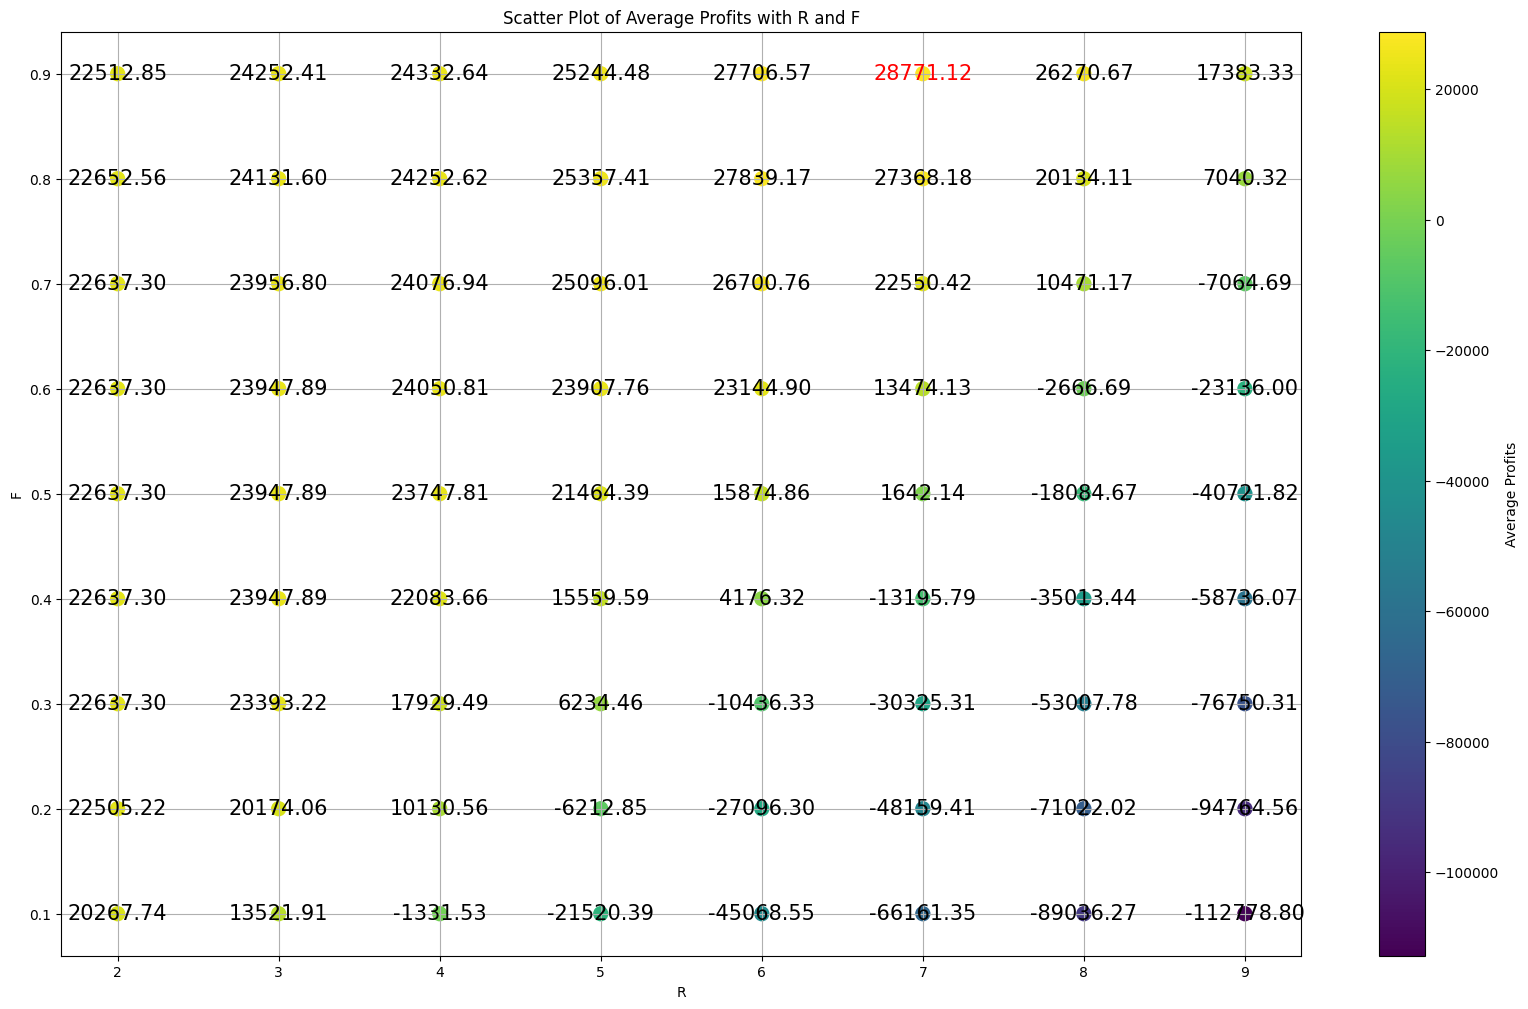

In [92]:
# 找到 'average_profits' 的最大值
max_profit = results_df_1["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_1["R(T)"],
    results_df_1["F"],
    c=results_df_1["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_1)):
    avg_profit = results_df_1["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_1["R(T)"].iloc[i],
            results_df_1["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_train_low_with_holding_cost_20_200_202411241650.png


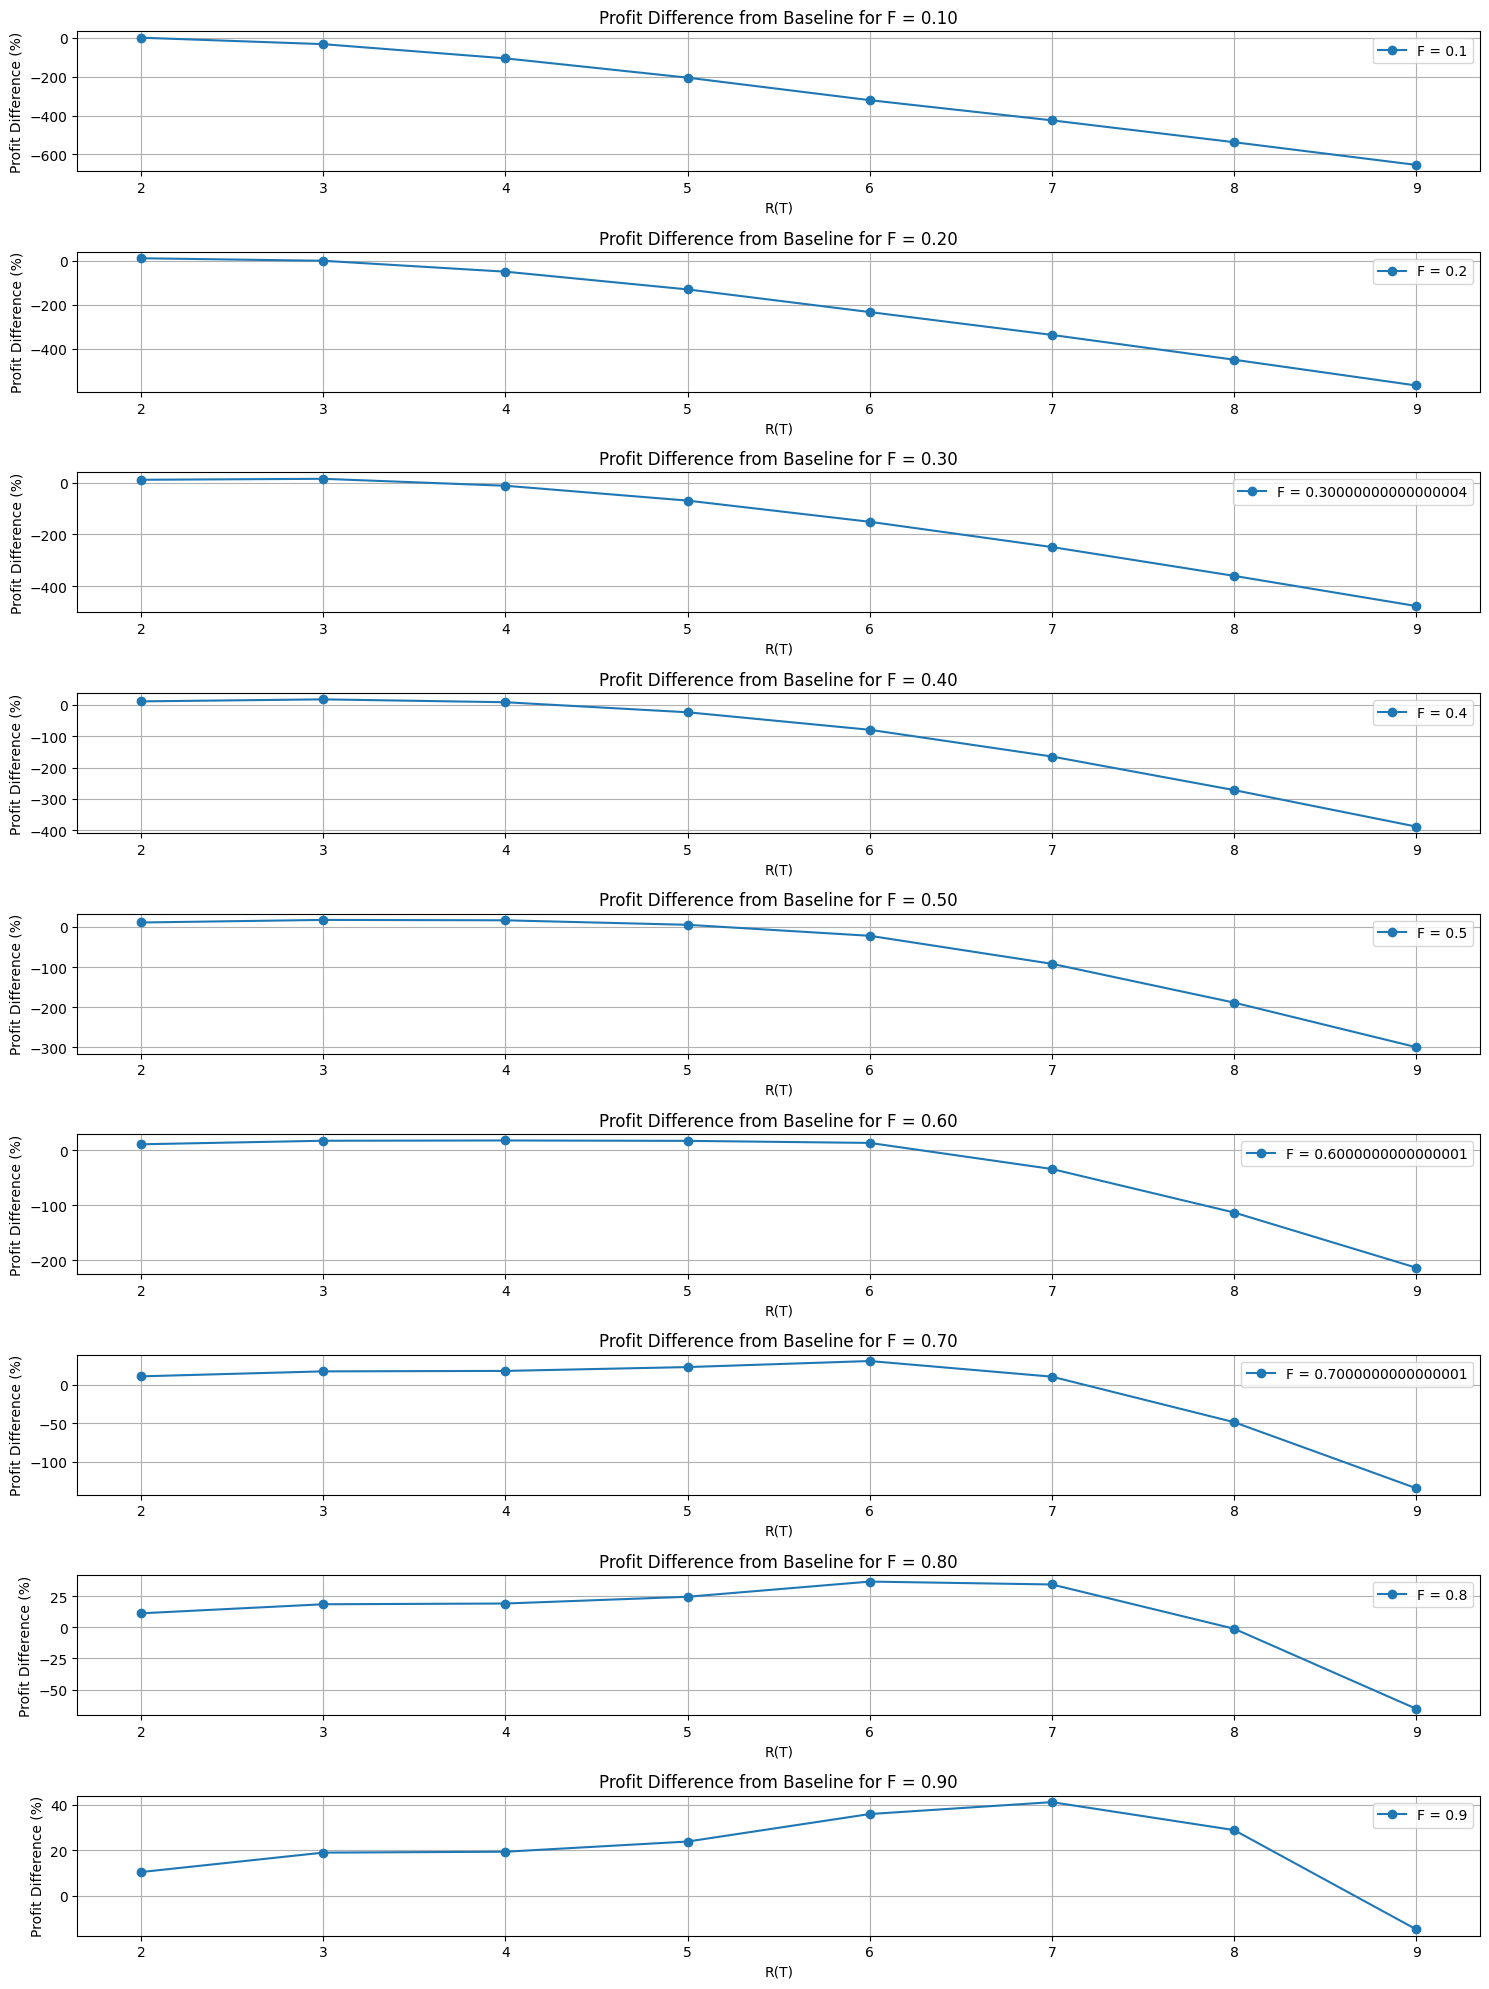

In [93]:
results_df_1["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_1["profit_diff_percent"] = (
    (results_df_1["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_1[results_df_1["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S8 - Grid for Fixed F & Fixed Rk


In [94]:
results_df_8, stimulation_results_df_8 = None, None

results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
    assigned_Ts=ASSIGNED_TS,
    assigned_Fs=ASSIGNED_FS,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
    Qk_hat_df=Qk_hat_df_train,
    demand_df_train=demand_df_train,
    Q_star=Q_star,
    holding_cost=holding_cost,
)
results_df_8





max_profit is changed from None to 6977.0694627739485




max_profit is changed from 6977.0694627739485 to 9684.312590302045




max_profit is changed from 9684.312590302045 to 9692.568445641004




































max_profit is changed from 9692.568445641004 to 11310.643708608002




max_profit is changed from 11310.643708608002 to 11704.363477421668








































max_profit is changed from 11704.363477421668 to 12026.492056490337








































max_profit is changed from 12026.492056490337 to 12129.132849394513




max_profit is changed from 12129.132849394513 to 12954.912353220443




































max_profit is changed from 12954.912353220443 to 14348.008726022488




max_profit is changed from 14348.008726022488 to 14932.109676649654


















































































































R(T)    F                                                 Q0  \
43     6  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
53     7  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
42     6  0.7  [105.08309726786567, 105.08309726786567, 105.0...   
52     7  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
44     6  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
..   ...  ...                                                ...   
55     8  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
65     9  0.3  [45.035613114799574, 45.035613114799574, 45.03...   
54     8  0.1  [15.011871038266523, 15.011871038266523, 15.01...   
64     9  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
63     9  0.1  [15.011871038266523, 15.011871038266523, 15.01...   

                                                   Q1  average_profits  \
43  [42.37740099333078, 12.717147296851635, 53.468...     14932.109677   
53  [45.233138902774414, 0, 47.665621045845, 0, 15...     14871.259376   
42  [57.3892720315973, 27.729018335118155, 68.4804...     14348.008726   
52  [60.245009941040934, 4.8363908628087415, 62.67...     14227.789700   
44  [27.36552995506426, 0, 38.45669281808958, 0, 1...     13924.575457   
..                                                ...              ...   
55  [136.31065896602934, 116.92335325937444, 146.8...    -87351.202416   
65  [138.37809792594197, 109.39646687197732, 148.4...    -92789.905879   
54  [151.32253000429586, 131.93522429764096, 161.8...   -105965.922504   
64  [153.3899689642085, 124.40833791024386, 163.44...   -111104.388546   
63  [168.401840002475, 139.42020894851038, 178.457...   -129418.871212   

    average_losses  average_lefts  average_operation_profits  
43       14.063531       2.407697               32578.030384  
53       10.877190       2.835920               33215.298692  
42       15.377981       3.173475               32315.140430  
52       13.249391       3.403498               32740.858372  
44       13.119655       3.045380               32766.805683  
..             ...            ...                        ...  
55       93.985732      86.023083               16593.590173  
65       96.096510      92.128054               16171.434588  
54      108.997603     101.034954               13591.215965  
64      111.108381     107.139925               13169.060380  
63      126.120252     122.151797               10166.686172  

[72 rows x 8 columns]

In [95]:
stimulation_results_df_8

R(T)    F       profits     losses      lefts  operation_profits  \
0      6  0.8  13371.333356  29.572125   0.000000       32494.473860   
1      6  0.8   7785.749938  29.145611   0.000000       26562.423121   
2      6  0.8  16935.162847  21.183183   0.000000       34712.706432   
3      6  0.8   8270.460009  20.010632   0.000000       24018.993661   
4      6  0.8  -1550.355709   0.000000  18.376309       26194.121558   
..   ...  ...           ...        ...        ...                ...   
95     6  0.8  11802.889203   9.485609   0.000000       25346.795332   
96     6  0.8  12322.347087  10.358352   0.000000       28072.000995   
97     6  0.8  12209.346464  36.490711   0.000000       31858.951360   
98     6  0.8  14715.089621   6.926707   0.000000       26124.709979   
99     6  0.8  18348.019507  26.749185   0.000000       36757.823392   

            Q0         Q1         hc0         hc1     Left0s     Left1s  \
0   120.094968  42.377401  500.347616  160.088157  37.666677   0.000000   
1   120.094968  12.717147  493.093048  154.284502  64.425104   0.000000   
2   120.094968  53.468564  509.575159  167.470190  30.266531   0.000000   
3   120.094968   0.000000  459.727947  127.592421  63.796210   0.000000   
4   120.094968  29.251948  475.338237  176.833270  40.788378  18.376309   
..         ...        ...         ...         ...        ...        ...   
95  120.094968   6.639008  456.960638  125.378574  56.050279   0.000000   
96  120.094968  20.265037  513.382840  170.516335  64.993131   0.000000   
97  120.094968  39.199788  476.535041  141.038097  31.319260   0.000000   
98  120.094968  10.528582  411.891046   89.322900  34.132869   0.000000   
99  120.094968  63.694149  496.215714  156.782634  14.697169   0.000000   

    lost0s     lost1s  
0      0.0  29.572125  
1      0.0  29.145611  
2      0.0  21.183183  
3      0.0  20.010632  
4      0.0   0.000000  
..     ...        ...  
95     0.0   9.485609  
96     0.0  10.358352  
97     0.0  36.490711  
98     0.0   6.926707  
99     0.0  26.749185  

[100 rows x 14 columns]

In [96]:
# 比較結果
max_profit = results_df_8["average_profits"].max()

print("\n============ Below is the comparison results =================")
print(f"Q_star: {Q_star}")
print(f"Maximum Profit: {max_profit}")


============ Below is the comparison results =================
Q_star: 150.11871038266523
Maximum Profit: 14932.109676649654


In [97]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_8.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "F", "average_profits"]]
top_three_info

R(T)    F  average_profits
43     6  0.8     14932.109677
53     7  0.9     14871.259376
42     6  0.7     14348.008726

Plot saved as plots/grid_fixed_F_fixed_R_metrics_s8_train_low_with_holding_cost_20_200_202411241650.png


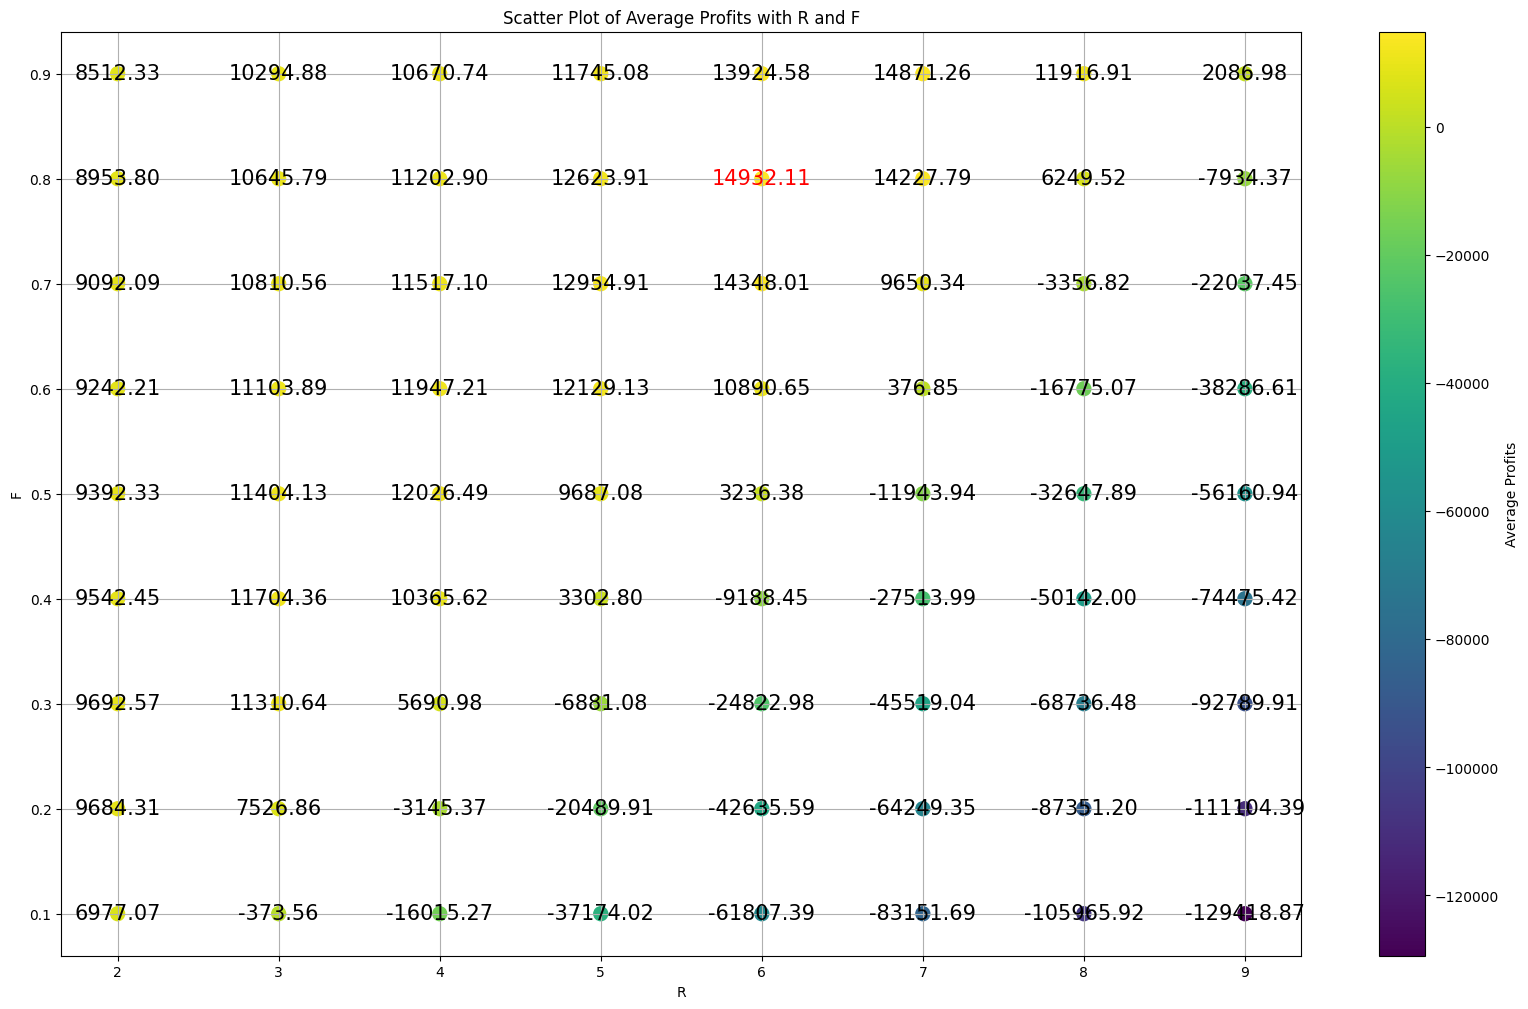

In [98]:
# 找到 'average_profits' 的最大值
max_profit = results_df_8["average_profits"].max()

# 画出散点图
plt.figure(figsize=(20, 12))
sc = plt.scatter(
    results_df_8["R(T)"],
    results_df_8["F"],
    c=results_df_8["average_profits"],
    cmap="viridis",
    s=100,
)
plt.colorbar(label="Average Profits")
plt.xlabel("R")
plt.ylabel("F")
plt.title("Scatter Plot of Average Profits with R and F")
plt.grid(True)

# 在每个数据点上标注数值
for i in range(len(results_df_8)):
    avg_profit = results_df_8["average_profits"].iloc[i]
    # 判断是否等于 max_profit 的整數部分
    if int(avg_profit) == int(max_profit):
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="red",
        )
    else:
        plt.text(
            results_df_8["R(T)"].iloc[i],
            results_df_8["F"].iloc[i],
            f"{avg_profit:.2f}",
            fontsize=15,
            ha="center",
            va="center",
            color="black",
        )

name = "grid_fixed_F_fixed_R_metrics_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

Plot saved as plots/grid_fixed_F_fixed_R_trend_s8_train_low_with_holding_cost_20_200_202411241650.png


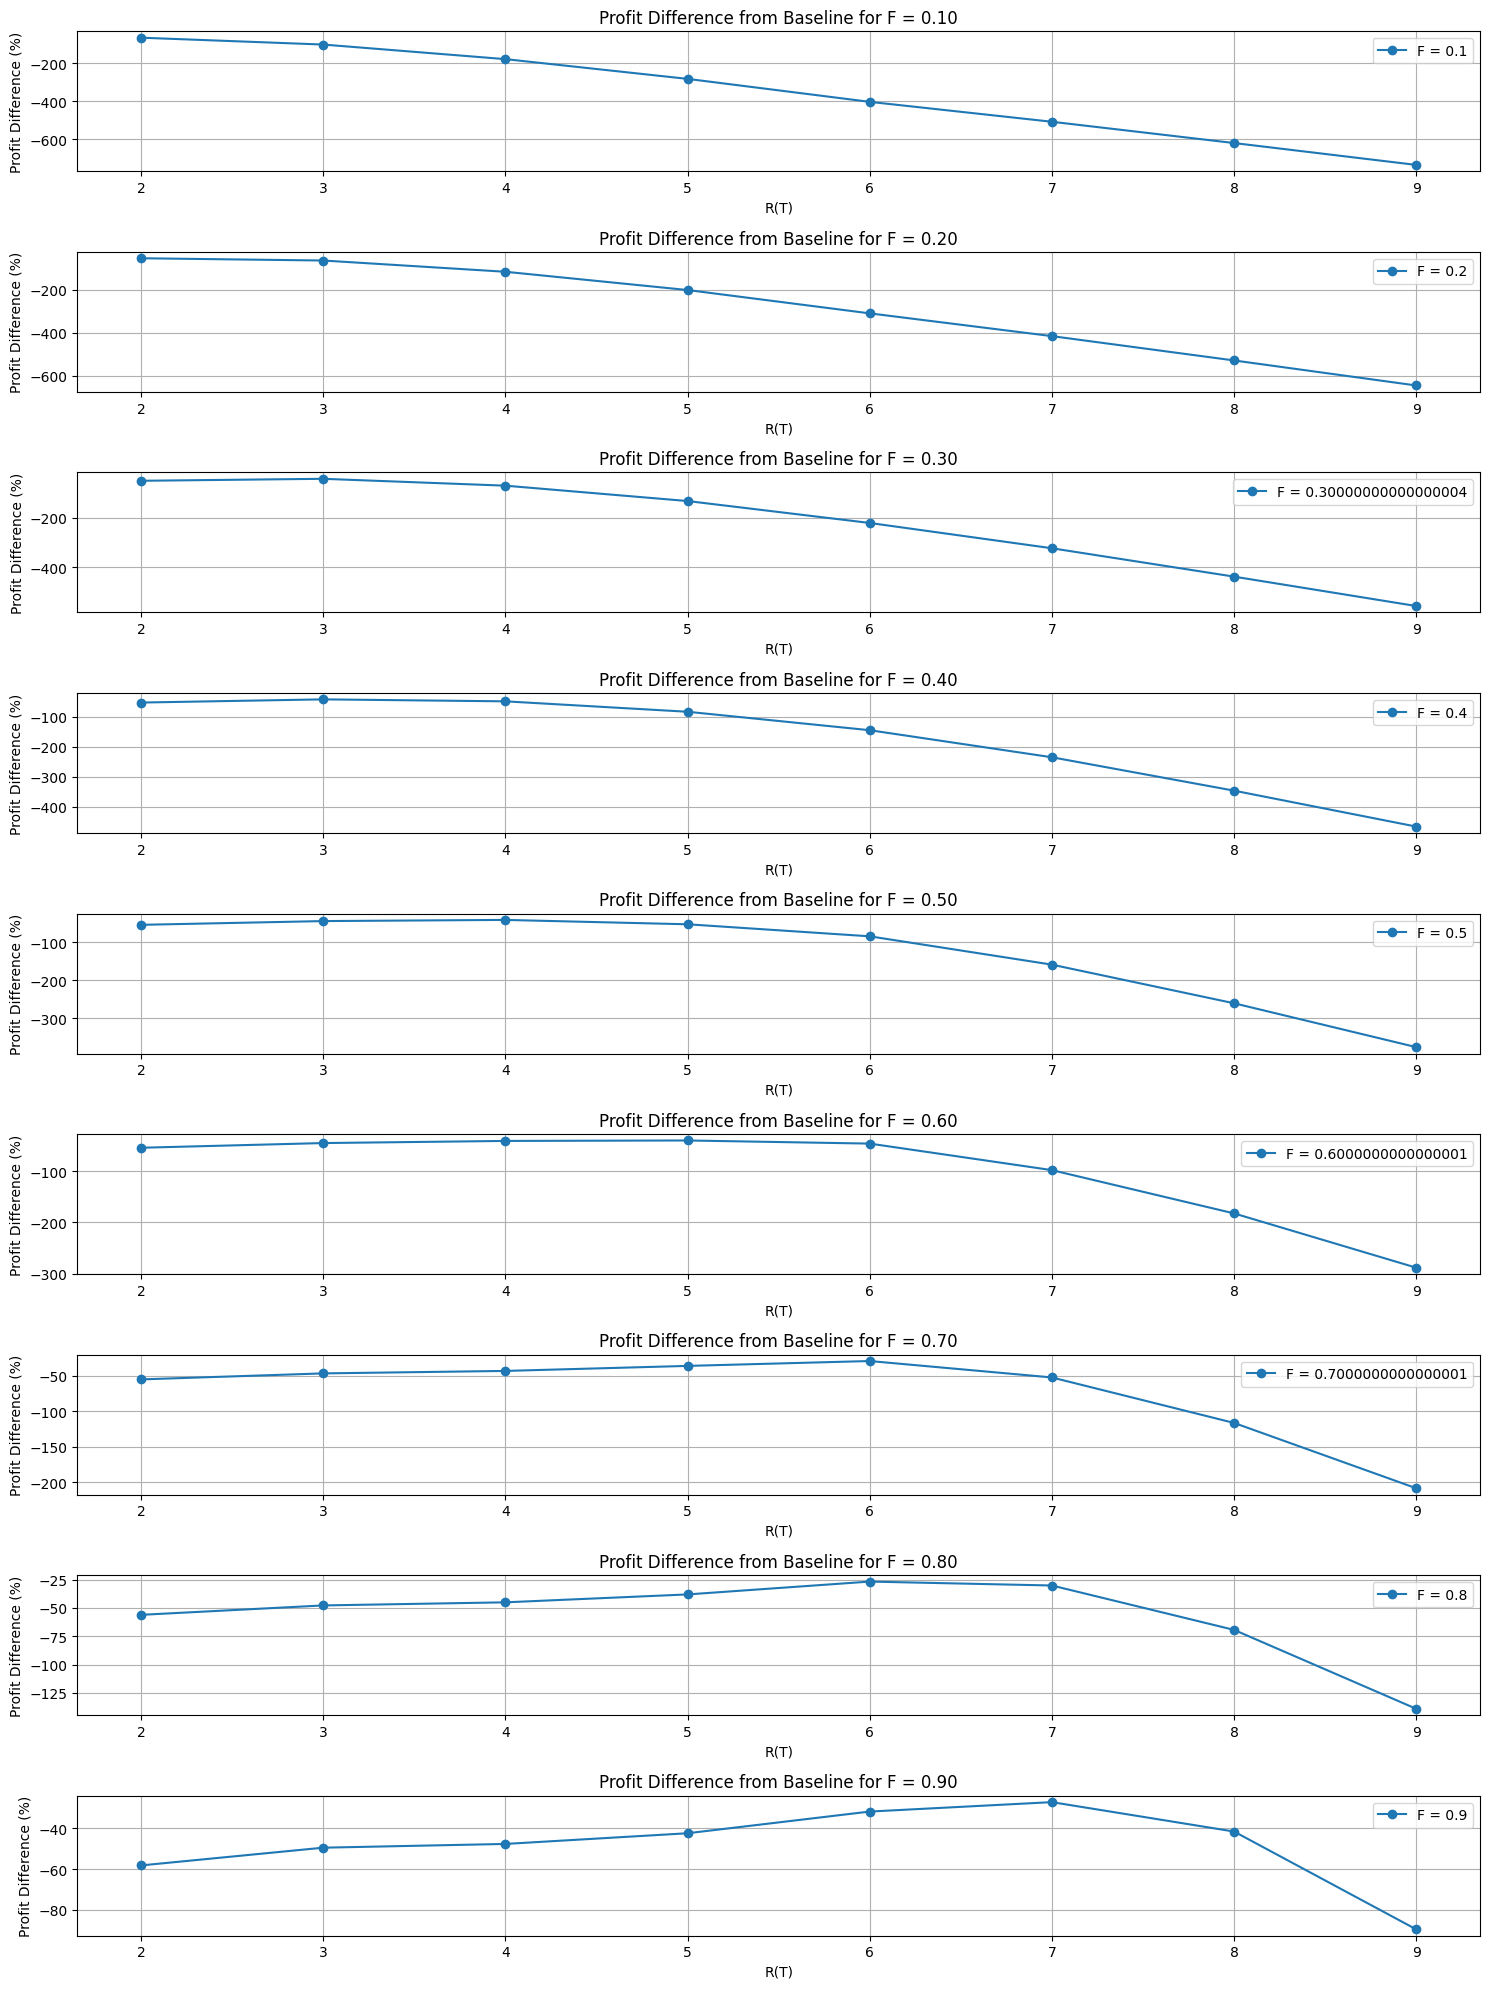

In [99]:
results_df_8["baseline_profit"] = baseline_avg_profits

# Calculate percentage difference from baseline profit
results_df_8["profit_diff_percent"] = (
    (results_df_8["average_profits"] - baseline_avg_profits) / baseline_avg_profits
) * 100

# Plot subplots for different values of F
plt.figure(figsize=(15, 20))

for idx, F in enumerate(ASSIGNED_FS):
    plt.subplot(len(ASSIGNED_FS), 1, idx + 1)
    subset = results_df_8[results_df_8["F"] == F].sort_values(by="R(T)").dropna()
    plt.plot(
        subset["R(T)"],
        subset["profit_diff_percent"],
        marker="o",
        linestyle="-",
        label=f"F = {F}",
    )
    plt.xlabel("R(T)")
    plt.ylabel("Profit Difference (%)")
    plt.title(f"Profit Difference from Baseline for F = {F:.2f}")
    plt.grid(True)
    plt.legend()

plt.tight_layout()

name = "grid_fixed_F_fixed_R_trend_s8"

os.makedirs("plots", exist_ok=True)
save_path = f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"

plt.savefig(save_path, format="png", bbox_inches="tight")
print(f"Plot saved as {save_path}")

# Show plot
plt.show()
plt.close()

### S2 - Grid for Fixed Rk & Flexible F


In [100]:
results_df_2, stimulation_results_df_2 = None, None
results_df_2, stimulation_results_df_2 = grid_flexible_F_fixed_R(
    assigned_Ts=ASSIGNED_TS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)
results_df_2

+++++++++++++++++++++++++++++++++++++++ THis is T=2 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 2800 rows, 2803 columns and 9300 nonzeros
Model fingerprint: 0xe088a777
Model has 100 general constraints
Variable types: 2003 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 600 rows and 100 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 12 ava

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/2248767889.py:205: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 2800 rows, 2803 columns and 9300 nonzeros
Model fingerprint: 0x8603158e
Model has 100 general constraints
Variable types: 2003 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
Presolve removed 600 rows and 100 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbounded
Best objective -, best bound -, gap -
===================== 找不到最佳解 ==================
Model is feasible. Status: 4
Academic license 2563

Empty DataFrame
Columns: [R(T), R, average_profits, average_losses, average_lefts, average_operation_profits, alpha_values, F_vars, Q0_vars, Q1_vars]
Index: []

In [101]:
stimulation_results_df_2

Empty DataFrame
Columns: []
Index: []

In [102]:
if results_df_2 is not None and len(results_df_2) > 0:
    save_model_parameters(
        f"{model_prefix}_s2", alpha_values=results_df_2.iloc[0]["alpha_values"]
    )

In [103]:
# 找出 average_profits 前三名的資料
top_three_results = results_df_2.head(3)

# 提取 R (T), F 和 average_profits
top_three_info = top_three_results[["R(T)", "average_profits"]]
top_three_info

Empty DataFrame
Columns: [R(T), average_profits]
Index: []

### S3 - Grid for Fixed F & Flexible Rk


In [104]:
results_df_3, stimulation_results_df_3 = None, None
results_df_3, stimulation_results_df_3 = grid_fixed_F_flexible_R(
    assigned_Fs=ASSIGNED_FS,
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df_train=Qk_hat_df_train,
    training_df=training_df,
)


results_df_3

+++++++++++++++++++++++++++++++++++++++ THis is F=0.1 +++++++++++++++++++++++++++++++++++++++++++++++++
Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 5000 rows, 6124 columns and 16300 nonzeros
Model fingerprint: 0x10821d8d
Model has 1000 quadratic constraints
Model has 1700 general constraints
Variable types: 5224 continuous, 900 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1200 ro

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/3862898589.py:246: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 5000 rows, 6124 columns and 16300 nonzeros
Model fingerprint: 0xc3627583
Model has 1000 quadratic constraints
Model has 1700 general constraints
Variable types: 5224 continuous, 900 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [2e-01, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1200 rows and 500 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.11 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unbo

Empty DataFrame
Columns: [R(T), average_losses, average_lefts, average_operation_profits, average_profits, beta_values, F_vars, Q0_vars, Q1_vars, tau_values]
Index: []

In [105]:
if results_df_3 is not None and len(results_df_3) > 0:
    save_model_parameters(
        f"{model_prefix}_s3",
        beta_values=results_df_3.iloc[0]["beta_values"],
        tau_values=results_df_3.iloc[0]["tau_values"],
    )

In [106]:
stimulation_results_df_3

Empty DataFrame
Columns: []
Index: []

In [107]:
if results_df_3 is not None and len(results_df_3) > 0:

    r_values = results_df_3["R(T)"].explode().values
    f_values = results_df_3["F_vars"].explode().values

    plt.figure(figsize=(10, 6))
    plt.plot(f_values, r_values, marker="o", linestyle="-", color="b")

    plt.title("R(T) vs F_vars Visualization")
    plt.xlabel("F_vars")
    plt.ylabel("R(T)")

    plt.grid(True)

    name = "result_3_metrics"

    os.makedirs("plots", exist_ok=True)
    save_path = (
        f"plots/{name}_{status}_{model_prefix}_{data_size}_{CURRENT_TIMESTAMP}.png"
    )

    plt.savefig(save_path, format="png", bbox_inches="tight")
    print(f"Plot saved as {save_path}")

    # Show plot
    plt.show()
    plt.close()

else:
    print("results_df_3 is None")

results_df_3 is None


### Fully flexible F & Rk


#### S5 - Simple beta with softmax


In [108]:
results_df_5, stimulation_results_df_5 = None, None
results_df_5, stimulation_results_df_5 = fully_flexible_simple_beta_with_softmax_5(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_5

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 5000 rows, 6235 columns and 15000 nonzeros
Model fingerprint: 0x420a7843
Model has 1000 quadratic constraints
Model has 1800 general constraints
Variable types: 5335 continuous, 900 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [5e-01, 1e+00]
  QLMatrix range   [5e-01, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1601 rows and 1125 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/2669542237.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Presolve removed 1801 rows and 1325 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -

Computing Irreducible Inconsistent Subsystem (IIS)...

           Constraints          |            Bounds           |  Runtime
      Min       Max     Guess   |   Min       Max     Guess   |
--------------------------------------------------------------------------
        0      7800         -         0      5703         -           0s
        4         4         4         2         2         2           0s

IIS computed: 4 constraints, 2 bounds
IIS runtime: 0.06 seconds (0.03 work units)
導致不可行的約束： Ensure_only_one_R_true_60
導致不可行的約束： Define_Q_hat_60
導致不可行的約束： Adjust_Q_hat_60
導致不可行的約束： Constr_Q1_ge_Q_hat_adjusted_60
導致不可行的變量： Q0_var[60], IIS下界： 0, IIS上界： 1
導致不可行的變量： Q1_var[60], IIS下界： 

In [109]:
if results_df_5 is not None:
    save_model_parameters(
        f"{model_prefix}_s5",
        alpha_values=results_df_5.iloc[0]["alpha_values"],
        beta_values=results_df_5.iloc[0]["beta_values"],
        tau_values=results_df_5.iloc[0]["tau_values"],
        f_values=stimulation_results_df_5["f_values"].values,
    )

In [110]:
stimulation_results_df_5

#### S6 - Simple beta and softmax with T is 1 - sum(T-1)


In [111]:
results_df_6, stimulation_results_df_6 = None, None
results_df_6, stimulation_results_df_6 = fully_flexible_simple_beta_with_softmax_6(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_6

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 4900 rows, 6011 columns and 15200 nonzeros
Model fingerprint: 0xb1e34853
Model has 700 quadratic constraints
Model has 1700 general constraints
Variable types: 5211 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 1501 rows and 1302 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 w

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/2637688773.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


        4         4         4         2         2         2           0s

IIS computed: 4 constraints, 2 bounds
IIS runtime: 0.07 seconds (0.02 work units)
導致不可行的約束： Ensure_only_one_R_true_60
導致不可行的約束： Define_Q_hat_60
導致不可行的約束： Adjust_Q_hat_60
導致不可行的約束： Constr_Q1_ge_Q_hat_adjusted_60
導致不可行的變量： Q0_var[60], IIS下界： 0, IIS上界： 1
導致不可行的變量： Q1_var[60], IIS下界： 0, IIS上界： 1
找不到最佳解


In [112]:
if results_df_6 is not None:
    save_model_parameters(
        f"{model_prefix}_s6",
        alpha_values=results_df_6.iloc[0]["alpha_values"],
        beta_values=results_df_6.iloc[0]["beta_values"],
        tau_values=results_df_6.iloc[0]["tau_values"],
        f_values=stimulation_results_df_6["f_values"].values,
    )

In [113]:
stimulation_results_df_6

#### S7 - Simple beat and softmax with T is 1 - sum(T-1) & tau with f


In [114]:
results_df_7, stimulation_results_df_7 = None, None
results_df_7, stimulation_results_df_7 = fully_flexible_simple_beta_with_softmax_7(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_7

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 4900 rows, 6011 columns and 15900 nonzeros
Model fingerprint: 0x6af421d6
Model has 700 quadratic constraints
Model has 1700 general constraints
Variable types: 5211 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 801 rows and 602 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 wor

/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/3438512483.py:267: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


In [115]:
if results_df_7 is not None:

    save_model_parameters(
        f"{model_prefix}_s7",
        alpha_values=results_df_7.iloc[0]["alpha_values"],
        beta_values=results_df_7.iloc[0]["beta_values"],
        tau_values=results_df_7.iloc[0]["tau_values"],
        f_values=stimulation_results_df_7["f_values"].values,
    )

In [116]:
stimulation_results_df_7

#### S4 - Beta with softmax


In [117]:
results_df_4, stimulation_results_df_4 = None, None
results_df_4, stimulation_results_df_4 = fully_flexible_beta_with_softmax_4(
    salvage_value=salvage_value,
    cost=cost,
    price=price,
    Q_star=Q_star,
    demand_df_train=demand_df_train,
    Qk_hat_df=Qk_hat_df_train,
    training_df=training_df,
)
results_df_4

Set parameter Threads to value 12
Set parameter MIPGap to value 0.3
Set parameter TimeLimit to value 400


/var/folders/ky/18rg_26d0nx_dq3q0413qtv80000gr/T/ipykernel_8459/4267343300.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  R_vars[i, k - 2] * Qk_hat_df_row[k - 2] for k in range(2, T)


Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 22.5.0 22F66)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2563044 - for non-commercial use only - registered to 11___@g.nccu.edu.tw
Optimize a model with 4900 rows, 6127 columns and 15600 nonzeros
Model fingerprint: 0xbbb861de
Model has 800 quadratic constraints
Model has 1800 general constraints
Variable types: 5327 continuous, 800 integer (800 binary)
Coefficient statistics:
  Matrix range     [3e-03, 8e+02]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 1e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 801 rows and 501 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 0

Model is infeasible or unboun

In [118]:
if results_df_4 is not None:
    save_model_parameters(
        f"{model_prefix}_s4",
        alpha_values=results_df_4.iloc[0]["alpha_values"],
        beta_values=results_df_4.iloc[0]["beta_values"],
        tau_values=results_df_4.iloc[0]["tau_values"],
        f_values=stimulation_results_df_4["f_values"].values,
    )

### Analysis


#### Baseline


In [119]:
print(f"The Average profit of One-time procurement: {baseline_avg_profits}")

The Average profit of One-time procurement: 20372.155719311697


#### S1


In [120]:
# 策略一
results_df_1

R(T)    F                                                 Q0  \
53     7  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
43     6  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
44     6  0.9  [135.1068393443987, 135.1068393443987, 135.106...   
52     7  0.8  [120.09496830613219, 120.09496830613219, 120.0...   
42     6  0.7  [105.08309726786567, 105.08309726786567, 105.0...   
..   ...  ...                                                ...   
55     8  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
65     9  0.3  [45.035613114799574, 45.035613114799574, 45.03...   
54     8  0.1  [15.011871038266523, 15.011871038266523, 15.01...   
64     9  0.2  [30.023742076533047, 30.023742076533047, 30.02...   
63     9  0.1  [15.011871038266523, 15.011871038266523, 15.01...   

                                                   Q1  average_profits  \
53  [45.233138902774414, 0, 47.665621045845, 0, 15...     28771.124722   
43  [42.37740099333078, 12.717147296851635, 53.468...     27839.166432   
44  [27.36552995506426, 0, 38.45669281808958, 0, 1...     27706.570913   
52  [60.245009941040934, 4.8363908628087415, 62.67...     27368.181670   
42  [57.3892720315973, 27.729018335118155, 68.4804...     26700.764536   
..                                                ...              ...   
55  [136.31065896602934, 116.92335325937444, 146.8...    -71022.022564   
65  [138.37809792594197, 109.39646687197732, 148.4...    -76750.311000   
54  [151.32253000429586, 131.93522429764096, 161.8...    -89036.267810   
64  [153.3899689642085, 124.40833791024386, 163.44...    -94764.556246   
63  [168.401840002475, 139.42020894851038, 178.457...   -112778.801492   

    average_losses  average_lefts  average_operation_profits  baseline_profit  \
53       10.877190       2.835920               33215.298692     20372.155719   
43       14.063531       2.407697               32578.030384     20372.155719   
44       13.119655       3.045380               32766.805683     20372.155719   
52       13.249391       3.403498               32740.858372     20372.155719   
42       15.377981       3.173475               32315.140430     20372.155719   
..             ...            ...                        ...              ...   
55       93.985732      86.023083               16593.590173     20372.155719   
65       96.096510      92.128054               16171.434588     20372.155719   
54      108.997603     101.034954               13591.215965     20372.155719   
64      111.108381     107.139925               13169.060380     20372.155719   
63      126.120252     122.151797               10166.686172     20372.155719   

    profit_diff_percent  
53            41.227689  
43            36.653022  
44            36.002156  
52            34.341118  
42            31.064993  
..                  ...  
55          -448.623010  
65          -476.741235  
54          -537.048828  
64          -565.167052  
63          -653.592870  

[72 rows x 10 columns]

In [121]:
if results_df_1 is None or len(results_df_1) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s1 = -1
else:
    max_profit_row = results_df_1.loc[results_df_1["average_profits"].idxmax()]
    max_profit_for_s1 = max_profit_row["average_profits"]
    avg_profit_for_s1 = results_df_1["average_profits"].mean()

    print(f"策略1平均利潤為：{avg_profit_for_s1}")
    print(f"策略1最佳策略在：R={max_profit_row['R(T)']}, F={max_profit_row['F']}")
    print(f"策略1最佳策略之下最大利潤為：{max_profit_for_s1}")

策略1平均利潤為：890.6175400963493
策略1最佳策略在：R=7, F=0.9
策略1最佳策略之下最大利潤為：28771.12472245604


#### S2


In [122]:
if results_df_2 is None or len(results_df_2) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s2 = -1
else:
    max_profit_row = results_df_2.loc[results_df_2["average_profits"].idxmax()]
    max_profit_for_s2 = max_profit_row["average_profits"]
    avg_profit_for_s2 = results_df_2["average_profits"].mean()

    print(f"策略2平均利潤為：{avg_profit_for_s2}")
    print(f"策略2最佳策略在：R={max_profit_row['R(T)']}, F為彈性")
    print(f"策略2最佳策略之下最大利潤為：{max_profit_for_s2}")

Model didn't find optimized result.


#### S3


In [123]:
# 策略三
results_df_3

Empty DataFrame
Columns: [R(T), average_losses, average_lefts, average_operation_profits, average_profits, beta_values, F_vars, Q0_vars, Q1_vars, tau_values]
Index: []

In [124]:
if results_df_3 is None or len(results_df_3) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s3 = -1
else:
    max_profit_row = stimulation_results_df_3.loc[
        stimulation_results_df_3["profits"].idxmax()
    ]
    max_profit_for_s3 = max_profit_row["profits"]

    print(f"策略3最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略3最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s3}")

Model didn't find optimized result.


#### S4


In [125]:
results_df_4

In [126]:
if results_df_4 is None or len(results_df_4) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s4 = -1
else:
    max_profit_row = results_df_4.loc[results_df_4["average_profits"].idxmax()]
    max_profit_for_s4 = max_profit_row["average_profits"]

    print(f"策略4最佳策略在：\nR為彈性, F={max_profit_row['F_vars'][0]}")
    print(f"策略4最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s4}")

Model didn't find optimized result.


#### S5


In [127]:
if results_df_5 is None or len(results_df_5) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s5 = -1
else:
    max_profit_row = stimulation_results_df_5.loc[
        stimulation_results_df_5["profits"].idxmax()
    ]
    max_profit_for_s5 = max_profit_row["profits"]

    print(f"策略5最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略5最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s5}")

Model didn't find optimized result.


#### S6


In [128]:
if results_df_6 is None or len(results_df_6) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s6 = -1
else:
    max_profit_row = stimulation_results_df_6.loc[
        stimulation_results_df_6["profits"].idxmax()
    ]
    max_profit_for_s6 = max_profit_row["profits"]

    print(f"策略6最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略6最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s6}")

Model didn't find optimized result.


#### S7


In [129]:
if results_df_7 is None or len(results_df_7) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s7 = -1
else:
    max_profit_row = stimulation_results_df_7.loc[
        stimulation_results_df_7["profits"].idxmax()
    ]
    max_profit_for_s7 = max_profit_row["profits"]

    print(f"策略7最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略7最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s7}")

Model didn't find optimized result.


#### S8

In [130]:
if results_df_8 is None or len(results_df_8) == 0:
    print(f"Model didn't find optimized result.")
    max_profit_for_s8 = -1
else:
    max_profit_row = stimulation_results_df_8.loc[
        stimulation_results_df_8["profits"].idxmax()
    ]
    max_profit_for_s8 = max_profit_row["profits"]

    print(f"策略8最佳策略在：\nR={max_profit_row['R(T)']}, \nF={max_profit_row['F']}")
    print(f"策略8最佳策略之下最大利潤(Avg profit)為：{max_profit_for_s8}")

策略8最佳策略在：
R=6.0, 
F=0.8
策略8最佳策略之下最大利潤(Avg profit)為：27669.897897200022


#### 比較&分析


##### 不同策略 Scatter

Plot saved as plots/plot_strategies_profits_scatter_train_low_with_holding_cost_20_200_202411241650.png


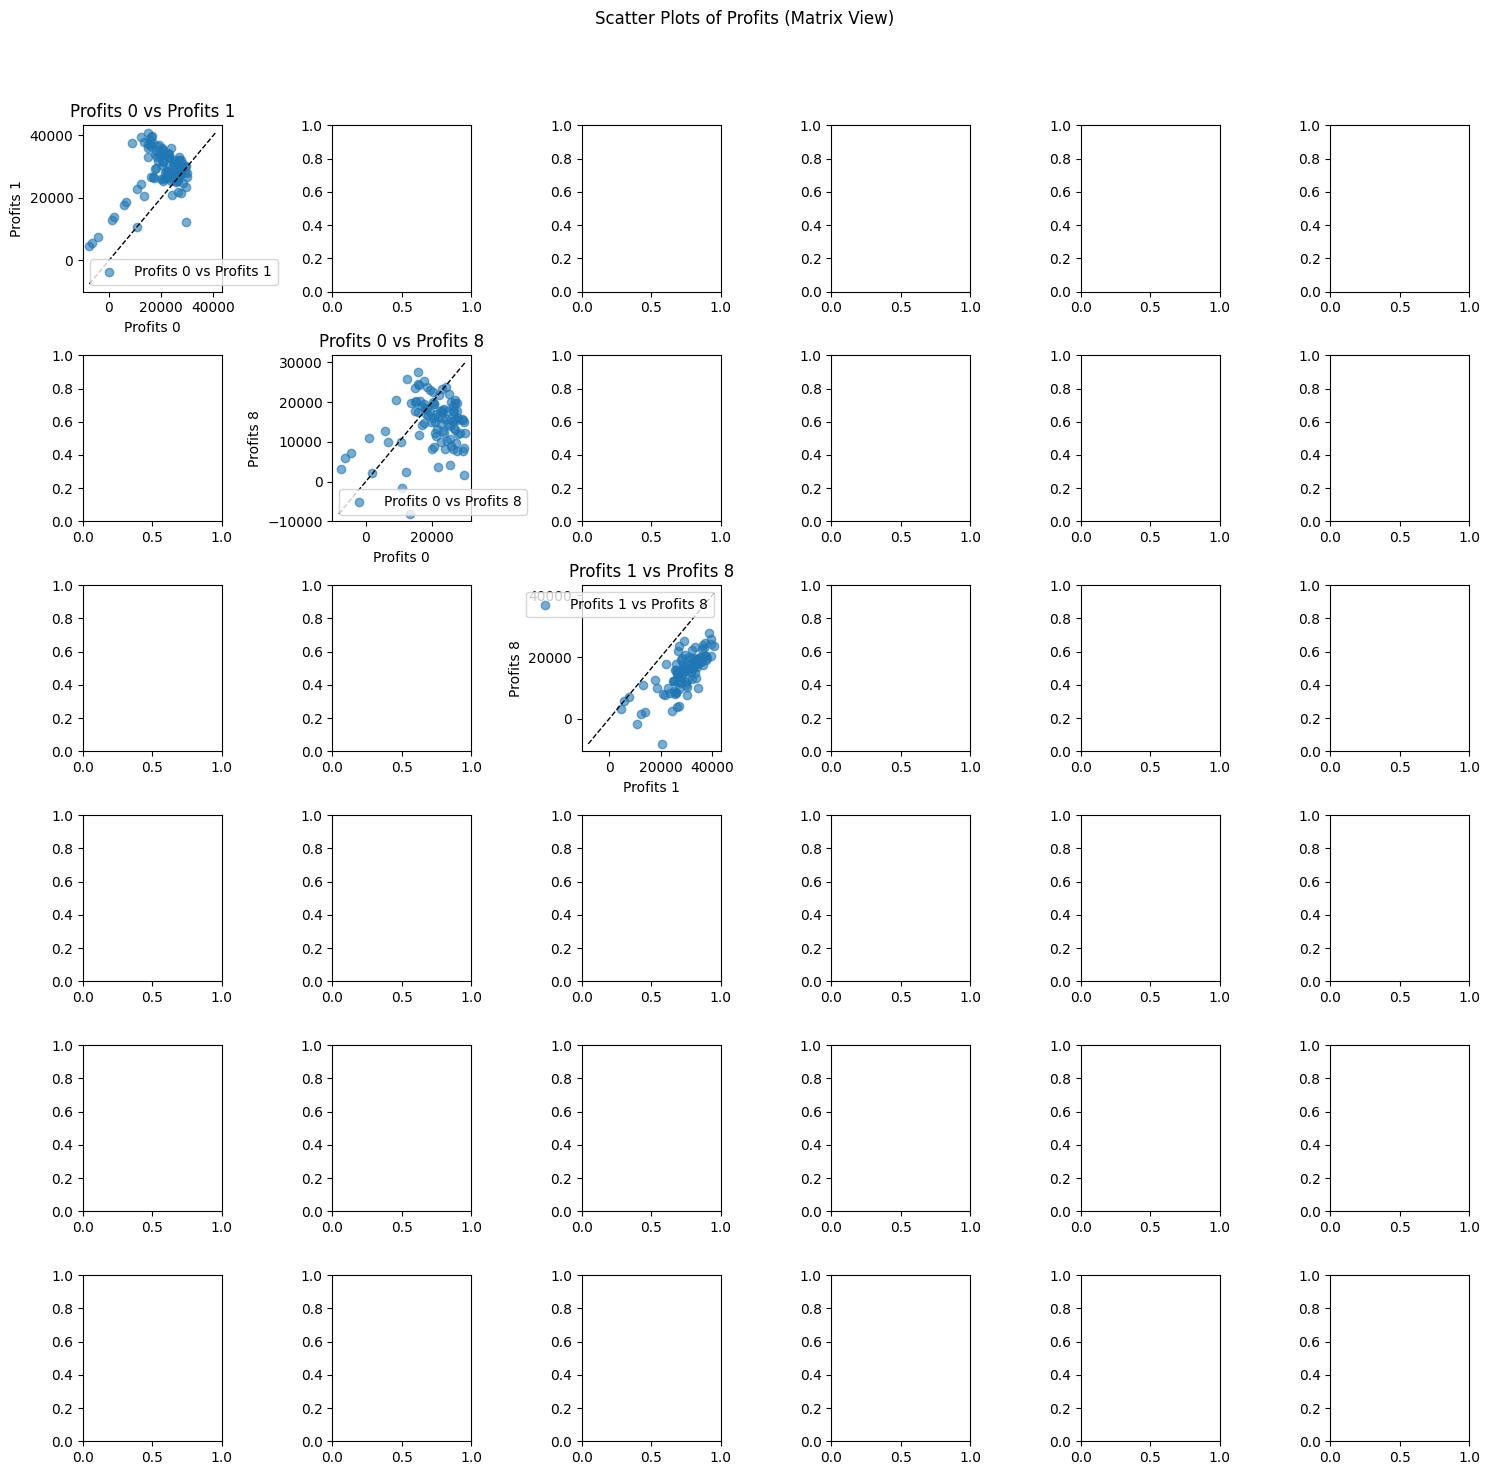

In [131]:
dfs = [
    baseline_stimulation_df,
    stimulation_results_df_1,
    stimulation_results_df_2,
    stimulation_results_df_3,
    stimulation_results_df_4,
    stimulation_results_df_5,
    stimulation_results_df_6,
    stimulation_results_df_7,
    stimulation_results_df_8,
]
plot_strategies_profits_scatter(save_type=f"{status}_{model_prefix}", dfs=dfs)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_train_low_with_holding_cost_20_200_S1_202411241650.png


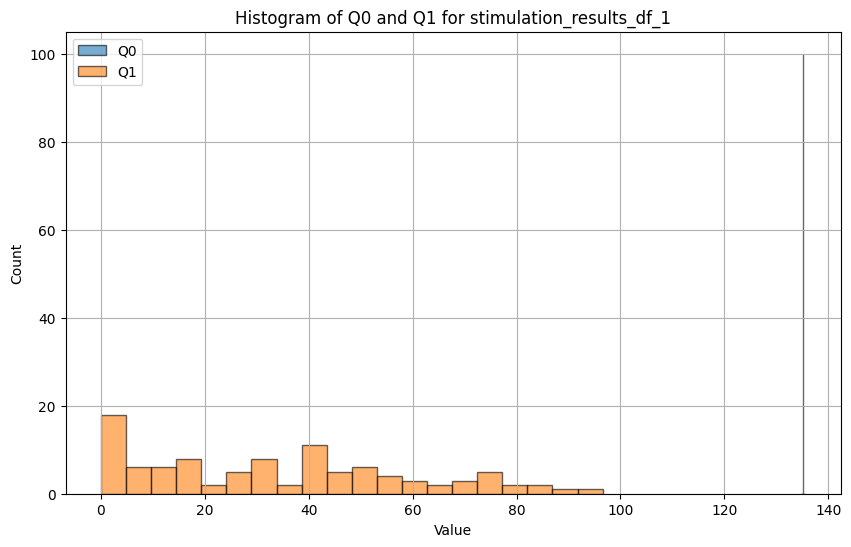

Plot saved as plots/plot_Q0_Q1_distribution_train_low_with_holding_cost_20_200_S8_202411241650.png


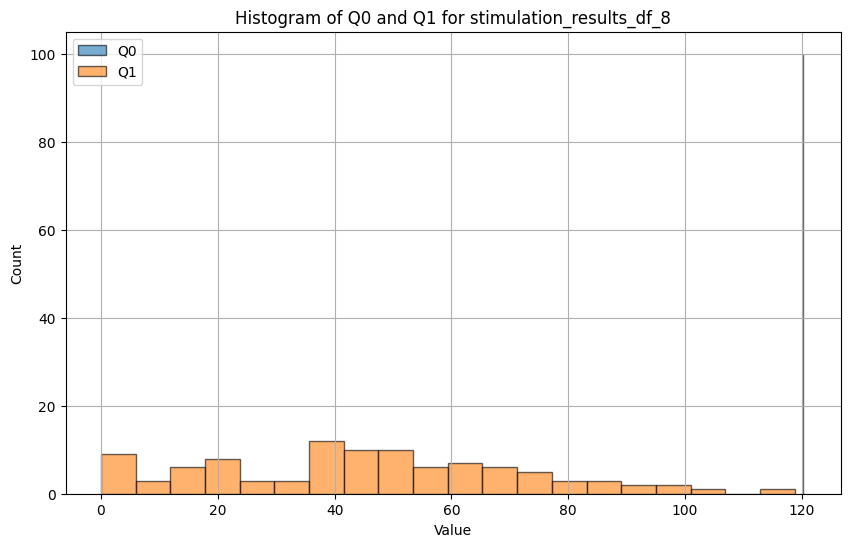

In [132]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_train_low_with_holding_cost_20_200_S1_202411241650.png


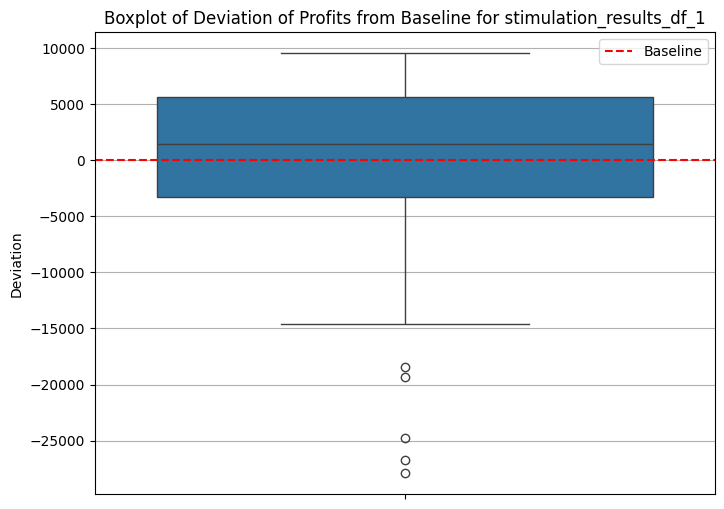

Plot saved as plots/plot_profits_deviation_box_plot_train_low_with_holding_cost_20_200_S2_202411241650.png


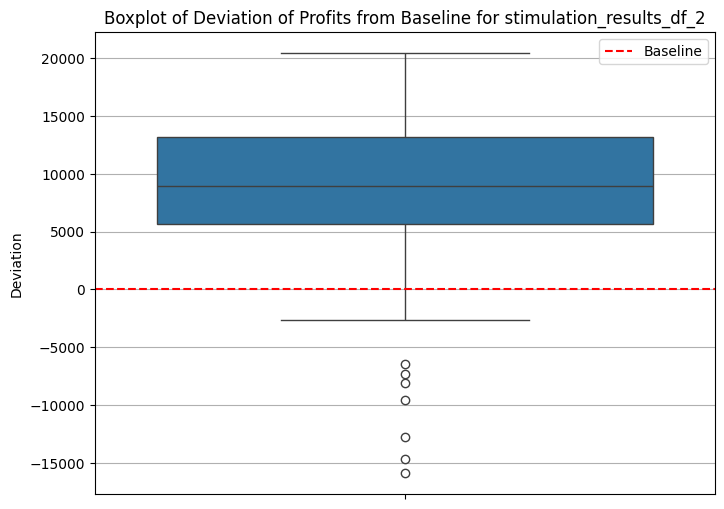

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_train_low_with_holding_cost_20_200_S9_202411241650.png


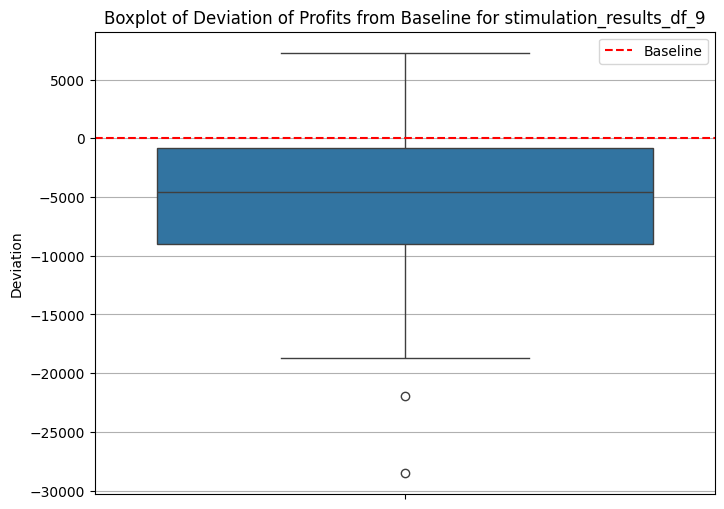

In [133]:
plot_profits_deviation_box_plot(
    f"{status}_{model_prefix}",
    dfs,
    baseline_avg_profits,
)

##### 最大利潤比較


Baseline is: 20372.155719311697
S1's profit: 28771.12472245604
S2's profit: -1
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: 27669.897897200022
Plot saved as plots/plot_relative_profit_deviation_train_low_with_holding_cost_20_200_202411241650.png


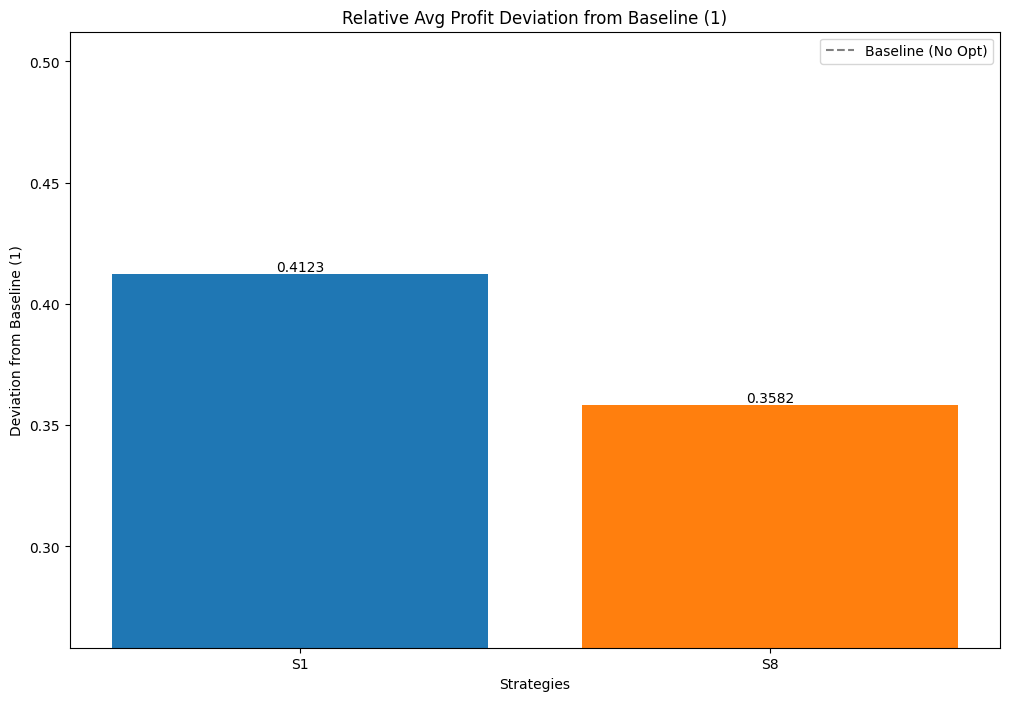

In [134]:
train_max_profits = [
    max_profit_for_s1,
    max_profit_for_s2,
    max_profit_for_s3,
    max_profit_for_s4,
    max_profit_for_s5,
    max_profit_for_s6,
    max_profit_for_s7,
    max_profit_for_s8,
]

plot_relative_profit_deviation(
    f"{status}_{model_prefix}", float(baseline_avg_profits), train_max_profits
)

#### Preparation


In [135]:
# overview
low_results_df_1 = results_df_1
low_results_df_2 = results_df_2
low_results_df_3 = results_df_3
low_results_df_4 = results_df_4
low_results_df_5 = results_df_5
low_results_df_6 = results_df_6
low_results_df_7 = results_df_7
low_results_df_8 = results_df_8

# max stimulation result
low_stimulation_results_df_1 = stimulation_results_df_1
low_stimulation_results_df_2 = stimulation_results_df_2
low_stimulation_results_df_3 = stimulation_results_df_3
low_stimulation_results_df_4 = stimulation_results_df_4
low_stimulation_results_df_5 = stimulation_results_df_5
low_stimulation_results_df_6 = stimulation_results_df_6
low_stimulation_results_df_7 = stimulation_results_df_7
low_stimulation_results_df_8 = stimulation_results_df_8

# max value
low_baseline_profit = baseline_avg_profits
low_max_profit_for_s1 = max_profit_for_s1
low_max_profit_for_s2 = max_profit_for_s2
low_max_profit_for_s3 = max_profit_for_s3
low_max_profit_for_s4 = max_profit_for_s4
low_max_profit_for_s5 = max_profit_for_s5
low_max_profit_for_s6 = max_profit_for_s6
low_max_profit_for_s7 = max_profit_for_s7
low_max_profit_for_s8 = max_profit_for_s8

## Testing


### Setting reasonable parameters


In [136]:
status = "test"

In [137]:
# Q star have to from demand_df_train
Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)
print(f"Q_star: {Q_star}")

mean of sum: 176.95368306114221
std of sum: 31.884856997434746
20.0 percentile of sum: 150.11871038266523
Q_star: 150.11871038266523


In [138]:
# compute Qk_hat_test with demand_df_test
mu_matrix, covariance_matrix = cal_mu_and_cov_matrix(demand_df_test)
Qk_hat_df_test = make_Qk_hat_df(
    demand_df_test, T, service_lv, mu_matrix, covariance_matrix
)
Qk_hat_df_test = Qk_hat_df_test.reset_index(drop=True)

print(f"Qk_hat_df_test shape: {Qk_hat_df_test.shape}")
Qk_hat_df_test.head()

Qk_hat_df_test shape: (100, 8)


Qk_hat_k2   Qk_hat_k3   Qk_hat_k4   Qk_hat_k5   Qk_hat_k6   Qk_hat_k7  \
0  156.672250  178.380673  185.000727  183.244816  167.987647  169.203422   
1  166.535919  184.136895  180.178560  199.043047  216.122279  219.436324   
2  154.195464  179.022691  174.740093  173.462893  176.802183  173.869788   
3  152.459485  164.436276  167.354194  175.568907  205.231554  207.262665   
4  153.878724  157.282734  157.929134  172.835215  200.924450  204.774738   

    Qk_hat_k8   Qk_hat_k9  
0  181.027112  201.669086  
1  223.753868  230.614496  
2  163.562016  182.449543  
3  219.019472  219.604788  
4  219.457511  214.695139

### Run all the strategies


Baseline

In [139]:
(
    test_baseline_avg_loss,
    test_baseline_avg_lefts,
    test_baseline_avg_profits,
    test_baseline_avg_operation_profits,
    test_stimulation_df_baseline,
) = one_time_procurement(
    Q_star=Q_star,
    demand_df=demand_df_test,
    cost=cost,
    price=price,
    salvage_value=salvage_value,
)

print(f"baseline_profit: {test_baseline_avg_profits}")

Processing row 1/100 with initial inventory Q_star=150.11871038266523
--------------------------------------------------
Day 1
Demand      : 21.535463220942717
Sales       : 21.535463220942717
Loss        : 0
Left        : 128.5832471617225
Inventory   : 128.5832471617225
--------------------------------------------------
--------------------------------------------------
Day 2
Demand      : 26.25142753924688
Sales       : 26.25142753924688
Loss        : 0
Left        : 102.33181962247563
Inventory   : 102.33181962247563
--------------------------------------------------
--------------------------------------------------
Day 3
Demand      : 16.64969745808753
Sales       : 16.64969745808753
Loss        : 0
Left        : 85.6821221643881
Inventory   : 85.6821221643881
--------------------------------------------------
--------------------------------------------------
Day 4
Demand      : 23.084916525642456
Sales       : 23.084916525642456
Loss        : 0
Left        : 62.59720563874565
I

In [140]:
test_stimulation_df_baseline.head()

losses  lefts  operation_profits       profits
0  64.866202    0.0       30023.742077  17050.501594
1  80.876854    0.0       30023.742077  13848.371326
2  36.085185    0.0       30023.742077  22806.705037
3  66.884555    0.0       30023.742077  16646.831155
4  74.080142    0.0       30023.742077  15207.713603

S1

In [141]:
test_results_df_1, test_stimulation_results_df_1 = None, None

if results_df_1 is not None:
    assigned_T = results_df_1.iloc[0]["R(T)"]
    assigned_F = results_df_1.iloc[0]["F"]

    test_results_df_1, test_stimulation_results_df_1 = cal_test_fixed_F_fixed_R(
        assigned_T=int(assigned_T),
        assigned_F=assigned_F,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
    )

test_results_df_1





這是第 1 筆模擬資料

F: 0.9, R: 7
Q_star 為 150.11871038266523
期初庫存 Q0: 135.1068393443987
重新估計量 Qk_hat: 169.20342212899953
訂貨量 Q1 為 34.09658278460083

第一階段：期初庫存 Q0: 135.1068393443987，需求量為 110.78514232910175，Sold_0 為 110.78514232910175，Left_0 為 24.321697015296962，Lost_0 為 0
第二階段：期初庫存 Q1+left_0 為 58.41827979989779，需求量為 104.19977046862726，Sold_1 為 58.41827979989779，Left_1 為 0.0，Lost_1 為 45.781490668729475

統計結果：Sold 為 169.20342212899953, Lost 為 45.781490668729475 Left_Penalty_Cost 為 0.0，Lost_Penalty_Cost 為 9156.298133745895，Profit 為 24684.38629205401
----------------------------------------
這是第 2 筆模擬資料

F: 0.9, R: 7
Q_star 為 150.11871038266523
期初庫存 Q0: 135.1068393443987
重新估計量 Qk_hat: 219.43632368320164
訂貨量 Q1 為 84.32948433880293

第一階段：期初庫存 Q0: 135.1068393443987，需求量為 154.02778205304972，Sold_0 為 135.1068393443987，Left_0 為 0.0，Lost_0 為 18.920942708651012
第二階段：期初庫存 Q1+left_0 為 84.32948433880293，需求量為 76.96778208053428，Sold_1 為 76.96778208053428，Left_1 為 7.36170225826865，Lost_1 為 0

統計結果：Sold 為 212.

R(T)    F                                                 Q0  \
0     7  0.9  [135.1068393443987, 135.1068393443987, 135.106...   

                                                  Q1  average_profits  \
0  [34.09658278460083, 84.32948433880293, 38.7629...     27204.140077   

   average_losses  average_lefts  average_operation_profits  
0       13.377268       3.258039               32486.025243

S2

In [142]:
test_results_df_2, test_stimulation_results_df_2 = None, None

if results_df_2 is not None and len(results_df_2) > 0:
    assigned_R = results_df_2.iloc[0]["R"]
    alphas = results_df_2.iloc[0]["alpha_values"]

    test_results_df_2, test_stimulation_results_df_2 = cal_test_flexible_F_fixed_R(
        assigned_R=assigned_R[0],
        alphas=alphas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_2

S3

In [143]:
results_df_3.head()

Empty DataFrame
Columns: [R(T), average_losses, average_lefts, average_operation_profits, average_profits, beta_values, F_vars, Q0_vars, Q1_vars, tau_values]
Index: []

In [144]:
test_results_df_3, test_stimulation_results_df_3 = None, None

if results_df_3 is not None and len(results_df_3) > 0:
    assigned_F = results_df_3.iloc[0]["F_vars"]
    betas = results_df_3.iloc[0]["beta_values"]
    test_results_df_3, test_stimulation_results_df_3 = cal_test_fixed_F_flexible_R(
        assigned_F=assigned_F[0],
        betas=betas,
        salvage_value=salvage_value,
        cost=cost,
        price=price,
        Q_star=Q_star,
        demand_df_test=demand_df_test,
        Qk_hat_df_test=Qk_hat_df_test,
        testing_df=testing_df,
    )

test_results_df_3

S4

In [145]:
test_results_df_4, test_stimulation_results_df_4 = None, None

if results_df_4 is not None:
    alphas = results_df_4.iloc[0]["alpha_values"]
    betas = results_df_4.iloc[0]["beta_values"]

    test_results_df_4, test_stimulation_results_df_4 = (
        cal_test_fully_flexible_beta_with_softmax_4(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_4

S5

In [146]:
test_results_df_5, test_stimulation_results_df_5 = None, None

if results_df_5 is not None:
    alphas = results_df_5.iloc[0]["alpha_values"]
    betas = results_df_5.iloc[0]["beta_values"]

    test_results_df_5, test_stimulation_results_df_5 = (
        cal_test_fully_flexible_simple_beta_with_softmax_5(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_5

S6

In [147]:
test_results_df_6, test_stimulation_results_df_6 = None, None

if results_df_6 is not None:
    alphas = results_df_6.iloc[0]["alpha_values"]
    betas = results_df_6.iloc[0]["beta_values"]

    test_results_df_6, test_stimulation_results_df_6 = (
        cal_test_fully_flexible_simple_beta_with_softmax_6(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_6

S7

In [148]:
test_results_df_7, test_stimulation_results_df_7 = None, None

if results_df_7 is not None:
    alphas = results_df_7.iloc[0]["alpha_values"]
    betas = results_df_7.iloc[0]["beta_values"]

    print(f"alphas: {alphas}")
    print(f"betas: {betas}")

    test_results_df_7, test_stimulation_results_df_7 = (
        cal_test_fully_flexible_simple_beta_with_softmax_7(
            alphas=alphas,
            betas=betas,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            testing_df=testing_df,
        )
    )

test_results_df_7

S8

In [149]:
test_results_df_8, test_stimulation_results_df_8 = None, None

if results_df_8 is not None:
    assigned_T = results_df_8.iloc[0]["R(T)"]
    assigned_F = results_df_8.iloc[0]["F"]

    test_results_df_8, test_stimulation_results_df_8 = (
        cal_test_fixed_F_fixed_R_with_holding_cost(
            assigned_T=int(assigned_T),
            assigned_F=assigned_F,
            salvage_value=salvage_value,
            cost=cost,
            price=price,
            Q_star=Q_star,
            demand_df_test=demand_df_test,
            Qk_hat_df_test=Qk_hat_df_test,
            holding_cost=holding_cost,
        )
    )

test_results_df_8

R(T)    F                                                 Q0  \
0     6  0.8  [120.09496830613219, 120.09496830613219, 120.0...   

                                                  Q1  average_profits  \
0  [47.892678368506296, 96.02731111561403, 56.707...     13392.577154   

   average_losses  average_lefts  average_operation_profits  
0       17.692386       2.634584               31623.001677

### Analysis

#### 組內比較

##### Profits Scatter

Plot saved as plots/plot_strategies_profits_scatter_test_low_with_holding_cost_20_200_202411241650.png


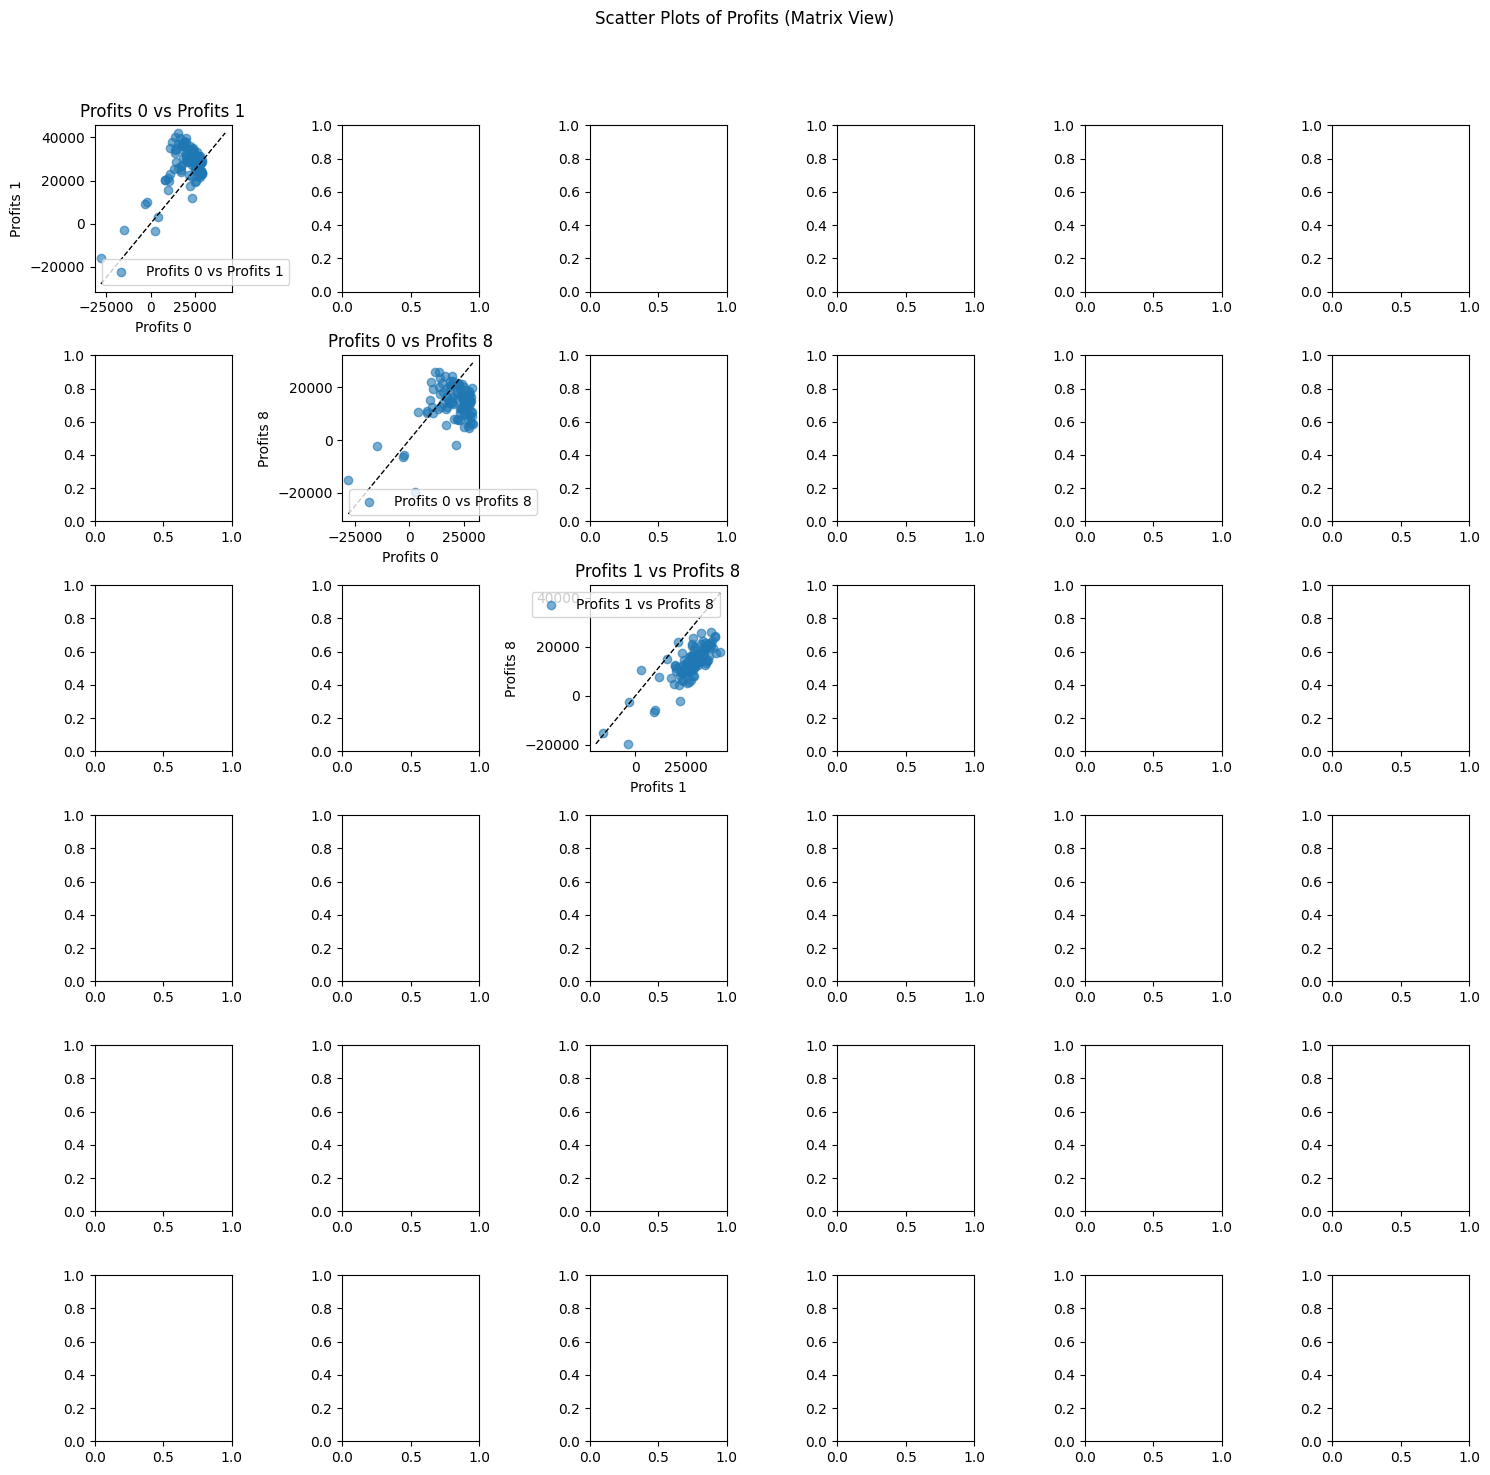

In [150]:
dfs = [
    test_stimulation_df_baseline,
    test_stimulation_results_df_1,
    test_stimulation_results_df_2,
    test_stimulation_results_df_3,
    test_stimulation_results_df_4,
    test_stimulation_results_df_5,
    test_stimulation_results_df_6,
    test_stimulation_results_df_7,
    test_stimulation_results_df_8,
]

plot_strategies_profits_scatter(f"{status}_{model_prefix}", dfs)

##### Profit Deviation

Baseline is: 20006.34457929116
S1's profit: 27204.140077130654
S2's profit: -1
S3's profit: -1
S4's profit: -1
S5's profit: -1
S6's profit: -1
S7's profit: -1
S8's profit: 13392.577153781003
Plot saved as plots/plot_relative_profit_deviation_test_low_with_holding_cost_20_200_202411241650.png


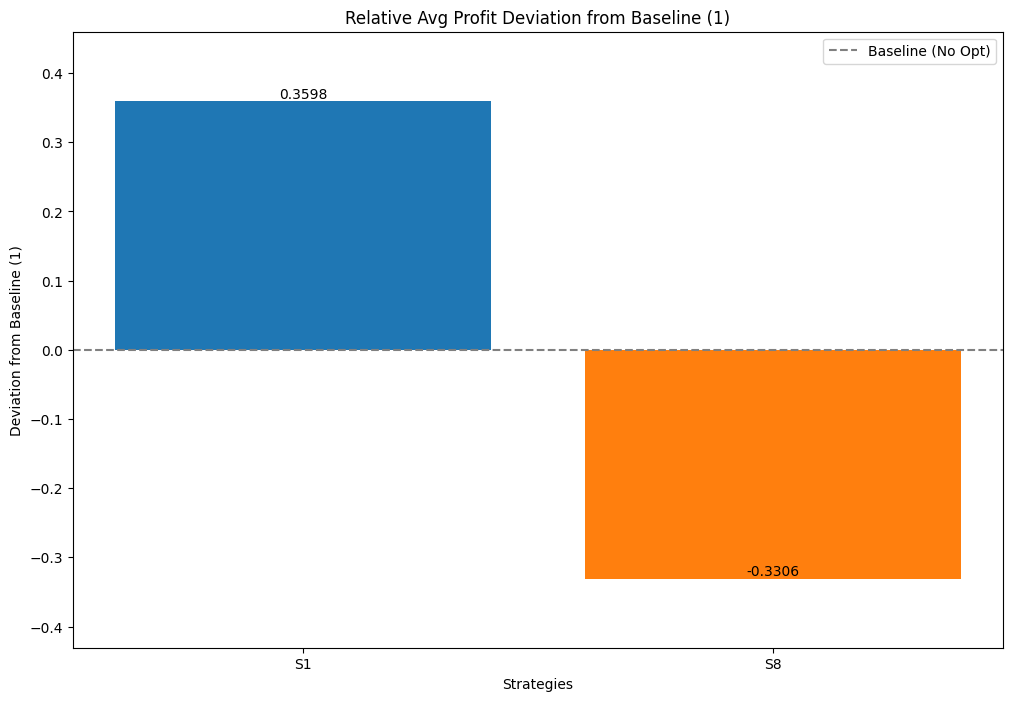

In [151]:
test_max_profits = [
    (
        test_results_df_1.iloc[0]["average_profits"]
        if test_results_df_1 is not None
        else -1
    ),
    (
        test_results_df_2.iloc[0]["average_profits"]
        if test_results_df_2 is not None
        else -1
    ),
    (
        test_results_df_3.iloc[0]["average_profits"]
        if test_results_df_3 is not None
        else -1
    ),
    (
        test_results_df_4.iloc[0]["average_profits"]
        if test_results_df_4 is not None
        else -1
    ),
    (
        test_results_df_5.iloc[0]["average_profits"]
        if test_results_df_5 is not None
        else -1
    ),
    (
        test_results_df_6.iloc[0]["average_profits"]
        if test_results_df_6 is not None
        else -1
    ),
    (
        test_results_df_7.iloc[0]["average_profits"]
        if test_results_df_7 is not None
        else -1
    ),
    (
        test_results_df_8.iloc[0]["average_profits"]
        if test_results_df_8 is not None
        else -1
    ),
]
plot_relative_profit_deviation(
    f"{status}_{model_prefix}", test_baseline_avg_profits, test_max_profits
)

##### 二次補貨量

Plot saved as plots/plot_Q0_Q1_distribution_test_low_with_holding_cost_20_200_S1_202411241650.png


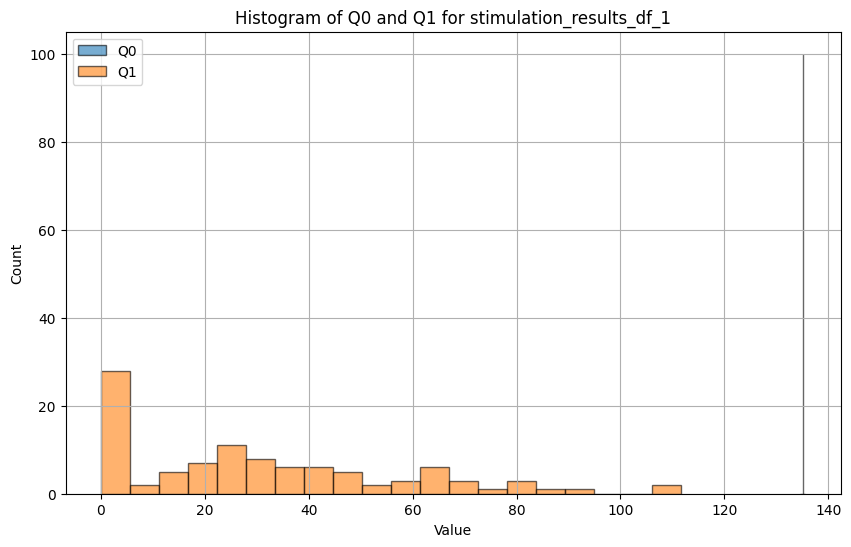

Plot saved as plots/plot_Q0_Q1_distribution_test_low_with_holding_cost_20_200_S8_202411241650.png


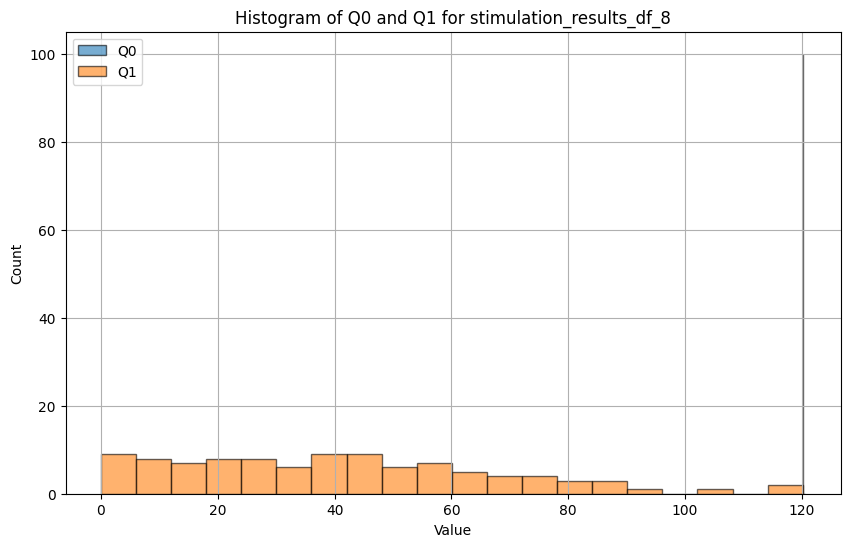

In [152]:
plot_Q0_Q1_distribution(f"{status}_{model_prefix}", dfs[1:])

##### 每一個 profits 對 Baseline 的 Deviation

Plot saved as plots/plot_profits_deviation_box_plot_test_low_with_holding_cost_20_200_S1_202411241650.png


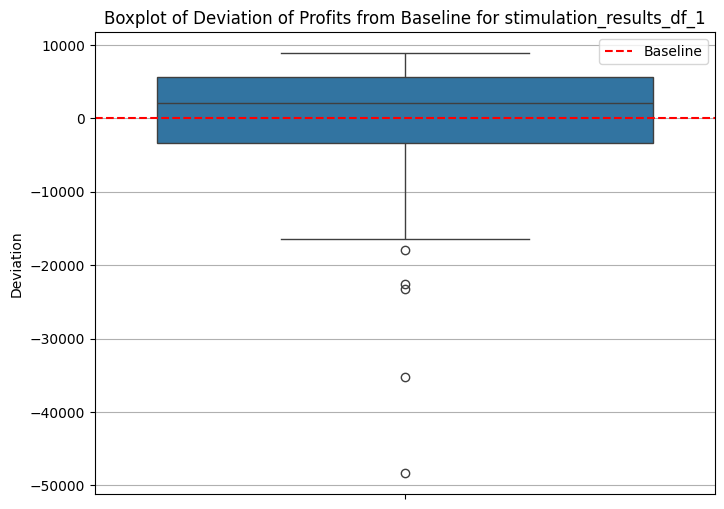

Plot saved as plots/plot_profits_deviation_box_plot_test_low_with_holding_cost_20_200_S2_202411241650.png


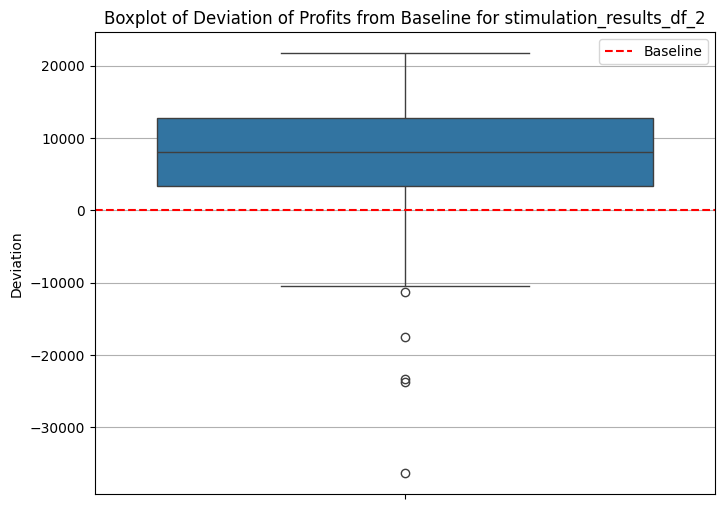

Skipping stimulation_results_df_3: Missing 'profits' column.
Skipping stimulation_results_df_4: Missing 'profits' column.
Skipping stimulation_results_df_5: Missing 'profits' column.
Skipping stimulation_results_df_6: Missing 'profits' column.
Skipping stimulation_results_df_7: Missing 'profits' column.
Skipping stimulation_results_df_8: Missing 'profits' column.
Plot saved as plots/plot_profits_deviation_box_plot_test_low_with_holding_cost_20_200_S9_202411241650.png


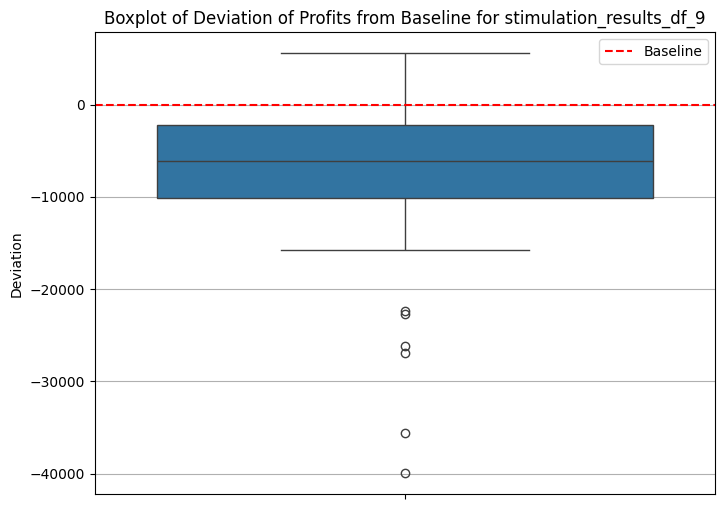

In [153]:
plot_profits_deviation_box_plot(f"{status}_{model_prefix}", dfs, baseline_avg_profits)

#### 訓練 vs. 測試

與各自的 Baseline 相比

Plot saved as plots/plot_relative_profit_comparison_test_low_with_holding_cost_20_200_202411241650.png


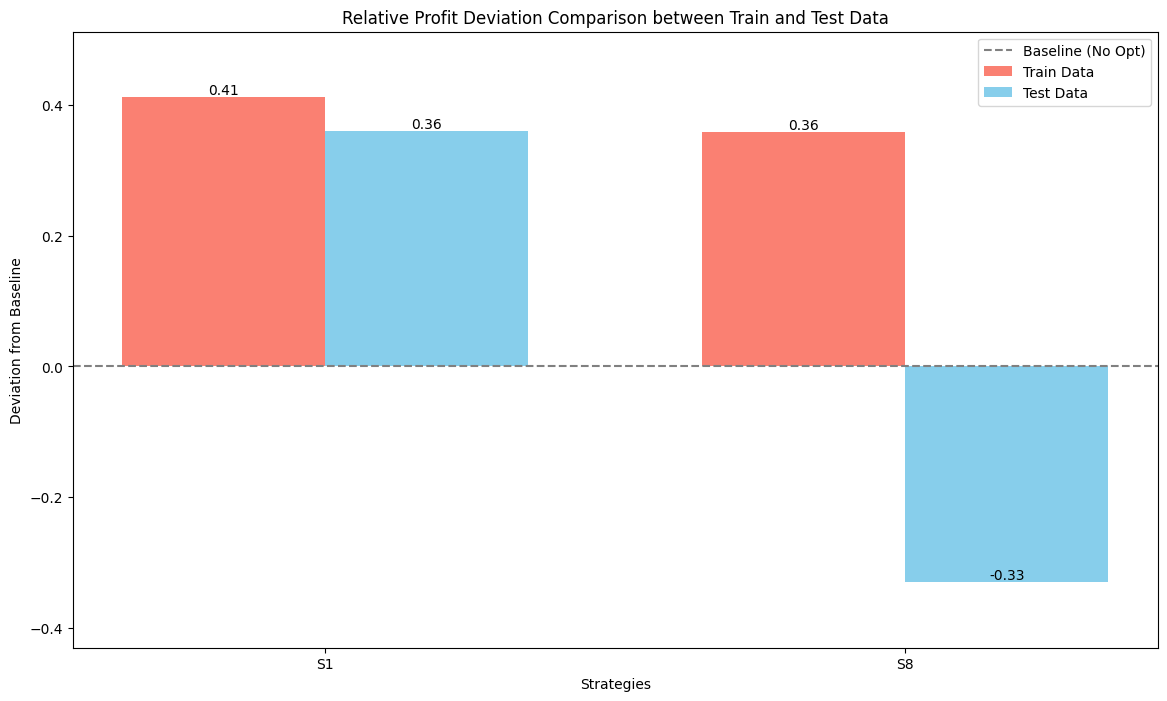

In [154]:
# Plot the comparison
plot_relative_profit_comparison(
    save_type=f"{status}_{model_prefix}",
    train_baseline_profit=baseline_avg_profits,
    test_baseline_profit=test_baseline_avg_profits,
    test_max_profits=test_max_profits,
    train_max_profits=train_max_profits,
)

#### Root Analysis

將參數 show 出來比較與分析

### Preparation

In [155]:
# 將變數名稱存取為此 Margin 特別的變數
# overview
low_test_results_df_1 = test_results_df_1
low_test_results_df_2 = test_results_df_2
low_test_results_df_3 = test_results_df_3
low_test_results_df_4 = test_results_df_4
low_test_results_df_5 = test_results_df_5
low_test_results_df_6 = test_results_df_6
low_test_results_df_7 = test_results_df_7
low_test_results_df_8 = test_results_df_8

# max stimulation result
low_test_stimulation_results_df_1 = test_stimulation_results_df_1
low_test_stimulation_results_df_2 = test_stimulation_results_df_2
low_test_stimulation_results_df_3 = test_stimulation_results_df_3
low_test_stimulation_results_df_4 = test_stimulation_results_df_4
low_test_stimulation_results_df_5 = test_stimulation_results_df_5
low_test_stimulation_results_df_6 = test_stimulation_results_df_6
low_test_stimulation_results_df_7 = test_stimulation_results_df_7
low_test_stimulation_results_df_8 = test_stimulation_results_df_8

# max value
low_test_baseline_profit = test_baseline_avg_profits
low_test_max_profit_for_s1 = test_max_profits[0]
low_test_max_profit_for_s2 = test_max_profits[1]
low_test_max_profit_for_s3 = test_max_profits[2]
low_test_max_profit_for_s4 = test_max_profits[3]
low_test_max_profit_for_s5 = test_max_profits[4]
low_test_max_profit_for_s6 = test_max_profits[5]
low_test_max_profit_for_s7 = test_max_profits[6]
low_test_max_profit_for_s8 = test_max_profits[7]

In [156]:
# # 測試 HC 與 最佳 R, F 的變化

# def visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits):
#     plt.figure(figsize=(15, 10))

#     # Plot R changes
#     plt.subplot(3, 1, 1)
#     plt.plot(holding_cost_list, best_Rs, marker="o", label="Best R")
#     plt.title("HC vs. Best R(T)")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("R(T)")
#     plt.grid(True)
#     plt.legend()

#     # Plot F changes
#     plt.subplot(3, 1, 2)
#     plt.plot(holding_cost_list, best_Fs, marker="o", color="orange", label="Best F")
#     plt.title("HC vs. Best F")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("F")
#     plt.grid(True)
#     plt.legend()

#     # Plot profits
#     plt.subplot(3, 1, 3)
#     plt.plot(
#         holding_cost_list,
#         best_profits,
#         marker="o",
#         color="green",
#         label="Average Profits",
#     )
#     plt.title("HC vs. Average Profits")
#     plt.xlabel("Holding Cost (HC)")
#     plt.ylabel("Average Profits")
#     plt.grid(True)
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# holding_cost_list = [x for x in range(0, 1050, 50)]
# margins = [
#     {
#         "type": "low",
#         "price": 1000,
#         "cost": 800,
#         "salvage_value": 0,
#     },
#     {
#         "type": "med",
#         "price": 1000,
#         "cost": 500,
#         "salvage_value": 0,
#     },
#     {
#         "type": "high",
#         "price": 1000,
#         "cost": 200,
#         "salvage_value": 0,
#     },
# ]

# for margin in margins:

#     price = margin["price"]
#     cost = margin["cost"]
#     salvage_value = margin["salvage_value"]

#     service_lv = calculate_service_level(
#         salvage_value=salvage_value, cost=cost, price=price
#     )
#     Q_star = calculate_Q_star(demand_df_train, service_level=service_lv)

#     best_Rs = []
#     best_Fs = []
#     best_profits = []

#     for holding_cost in holding_cost_list:

#         results_df_8, stimulation_results_df_8 = grid_fixed_F_fixed_R_with_holding_cost(
#             assigned_Ts=ASSIGNED_TS,
#             assigned_Fs=ASSIGNED_FS,
#             cost=cost,
#             price=price,
#             salvage_value=salvage_value,
#             Qk_hat_df=Qk_hat_df_train,
#             demand_df_train=demand_df_train,
#             Q_star=Q_star,
#             holding_cost=holding_cost,
#         )

#         best_Rs.append(results_df_8.iloc[0]["R(T)"])
#         best_Fs.append(results_df_8.iloc[0]["F"])
#         best_profits.append(results_df_8.iloc[0]["average_profits"])

#     print(f"Now at {margin['type']}...\n")
#     visualize_holding_cost_changes(holding_cost_list, best_Rs, best_Fs, best_profits)